In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.linear_model import LinearRegression
from patsy import dmatrices

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
InvStock = pd.read_csv('Inventory_Stock_Data.csv')
InvStock

order-now  product id                                product name  \
0       green          19     Nike Men's Fingertrap Max Training Shoe   
1      orange          24                 Elevation Training Mask 2.0   
2       green          35     adidas Brazuca 2014 Official Match Ball   
3       green          37       adidas Kids' F5 Messi FG Soccer Cleat   
4      orange          44  adidas Men's F10 Messi TRX FG Soccer Cleat   
..        ...         ...                                         ...   
113     green        1359                          Adult dog supplies   
114    orange        1360                                 Smart watch   
115     green        1361                                        Toys   
116    orange        1362                        Fighting video games   
117     green        1363                              Summer dresses   

     avg lead time  avg order qty  current stock  max lead time  \
0               10              1             69             30   
1               10              3            175             30   
2               10              1             65             30   
3               10              3            328             30   
4               10              3            175             30   
..             ...            ...            ...            ...   
113             10              1             69             30   
114             10              1             35             30   
115             10              1             61             30   
116             10              1             35             30   
117             10              1             63             30   

     max order qty  mod  reorder point  safety stock  
0                1    1             35            25  
1                5    0            175           144  
2                1    1             35            25  
3                5    1            175           146  
4                5    0            175           145  
..             ...  ...            ...           ...  
113              1    1             35            25  
114              1    0             35            25  
115              1    1             35            25  
116              1    0             35            25  
117              1    1             35            25  

[118 rows x 11 columns]

In [4]:
SalesShip = pd.read_csv('Sales_Shipment_Data.csv')
SalesShip

Product Category Id     Category Name                           Class  \
0                        24   Women's Apparel  Moderate Value-Moderate Number   
1                        24   Women's Apparel  Moderate Value-Moderate Number   
2                        24   Women's Apparel  Moderate Value-Moderate Number   
3                        24   Women's Apparel  Moderate Value-Moderate Number   
4                        24   Women's Apparel  Moderate Value-Moderate Number   
...                     ...               ...                             ...   
180514                   17            Cleats         High Value-Small Number   
180515                   17            Cleats         High Value-Small Number   
180516                    9  Cardio Equipment         High Value-Small Number   
180517                   17            Cleats         High Value-Small Number   
180518                   17            Cleats         High Value-Small Number   

          Customer City Customer Country Customer Fname  Customer Id  \
0               Roswell          EE. UU.           Jean         5673   
1           Los Angeles          EE. UU.           Rose         9723   
2                Harvey          EE. UU.         Joshua         9511   
3              Elmhurst          EE. UU.           Mary         3326   
4       North Las Vegas          EE. UU.       Samantha          907   
...                 ...              ...            ...          ...   
180514        Escondido          EE. UU.        Charles         9615   
180515          Seattle          EE. UU.        Richard         1971   
180516          Anaheim          EE. UU.           Mary         7663   
180517        San Diego          EE. UU.           Mary          415   
180518       Sacramento          EE. UU.           Mary         7141   

       Customer Lname Customer Segment Customer State  ...  \
0                Dunn        Corporate             NM  ...   
1               White        Corporate             CA  ...   
2               Brady        Corporate             IL  ...   
3               Smith        Corporate             IL  ...   
4               Kline        Corporate             NV  ...   
...               ...              ...            ...  ...   
180514          Smith        Corporate             CA  ...   
180515         Stokes        Corporate             WA  ...   
180516          Smith        Corporate             CA  ...   
180517          Allen        Corporate             CA  ...   
180518        Jackson        Corporate             CA  ...   

       Order Item Discount Rate  Order Item Id Order Item Product Price  \
0                          0.15         134920                50.000000   
1                          0.16           9722                50.000000   
2                          0.06         129954                50.000000   
3                          0.05           2929                50.000000   
4                          0.05         140056                50.000000   
...                         ...            ...                      ...   
180514                     0.16         124746                59.990002   
180515                     0.17          73577                59.990002   
180516                     0.25          60910                99.989998   
180517                     0.13         114288                59.990002   
180518                     0.17          60174                59.990002   

        Order Item Profit Ratio Order Item Quantity Order Item Total  \
0                          0.11                   2        85.000000   
1                          0.11                   2        84.000000   
2                          0.33                   2        94.500000   
3                          0.29                   2        95.000000   
4                          0.50                   2        95.000000   
...                         ...                 ...              ...   
180514              

# a. Data Audit

## 1. Number of rows & Number of columns

In [5]:
print(f'Inventory_Stock_Data : (rows,columns) = {InvStock.shape}')

Inventory_Stock_Data : (rows,columns) = (118, 11)


In [6]:
print(f'Sales_Shipment_Data : (rows,columns) = {SalesShip.shape}')

Sales_Shipment_Data : (rows,columns) = (180519, 46)


## 2. Number of numerical & categorical columns

In [7]:
def count_column_type(df):
    num_cols = len(df.select_dtypes(include=['number']).columns)
    cat_cols = len(df.select_dtypes(include=['object']).columns)
    return num_cols , cat_cols

In [8]:
num_columns , cat_columns = count_column_type(InvStock)
print(f'Number of numerical columns in Inventory_Stock_Data : {num_columns}')
print(f'Number of categorical columns in Inventory_Stock_Data : {cat_columns}')

Number of numerical columns in Inventory_Stock_Data : 9
Number of categorical columns in Inventory_Stock_Data : 2


In [9]:
num_columns , cat_columns = count_column_type(SalesShip)
print(f'Number of numerical columns in Sales_Shipment_Data : {num_columns}')
print(f'Number of categorical columns in Sales_Shipment_Data : {cat_columns}')

Number of numerical columns in Sales_Shipment_Data : 24
Number of categorical columns in Sales_Shipment_Data : 22


## 3. Any other observations from the data in terms of cleaning, preparation required?

In [10]:
# Missing values in DataFrame.
invt_missing_values = InvStock.isnull().sum()
sales_missing_values = SalesShip.isnull().sum()
print('Missing values in Inventory_Stock_Data' , invt_missing_values)
print('Missing values in Sales_Shipment_Data' , sales_missing_values)

Missing values in Inventory_Stock_Data order-now        0
product id       0
product name     0
avg lead time    0
avg order qty    0
current stock    0
max lead time    0
max order qty    0
mod              0
reorder point    0
safety stock     0
dtype: int64
Missing values in Sales_Shipment_Data Product Category Id              0
Category Name                    0
Class                            0
Customer City                    0
Customer Country                 0
Customer Fname                   0
Customer Id                      0
Customer Lname                   8
Customer Segment                 0
Customer State                   0
Customer Street                  0
Customer Zipcode                 3
Delivery Status                  0
Department Id                    0
Department Name                  0
Market                           0
Order City                       0
Order Country                    0
order date (DateOrders)          0
Order Id                         0
O

In [11]:
# Duplicate rows in DataFrame.
duplicate_rows = InvStock.duplicated().sum()
print(f"Number of duplicate rows in Inventory_Stock_Data : {duplicate_rows}")

Number of duplicate rows in Inventory_Stock_Data : 0


In [12]:
duplicate_rows = SalesShip.duplicated().sum()
print(f"Number of duplicate rows in Sales_Shipment_Data : {duplicate_rows}")

Number of duplicate rows in Sales_Shipment_Data : 0


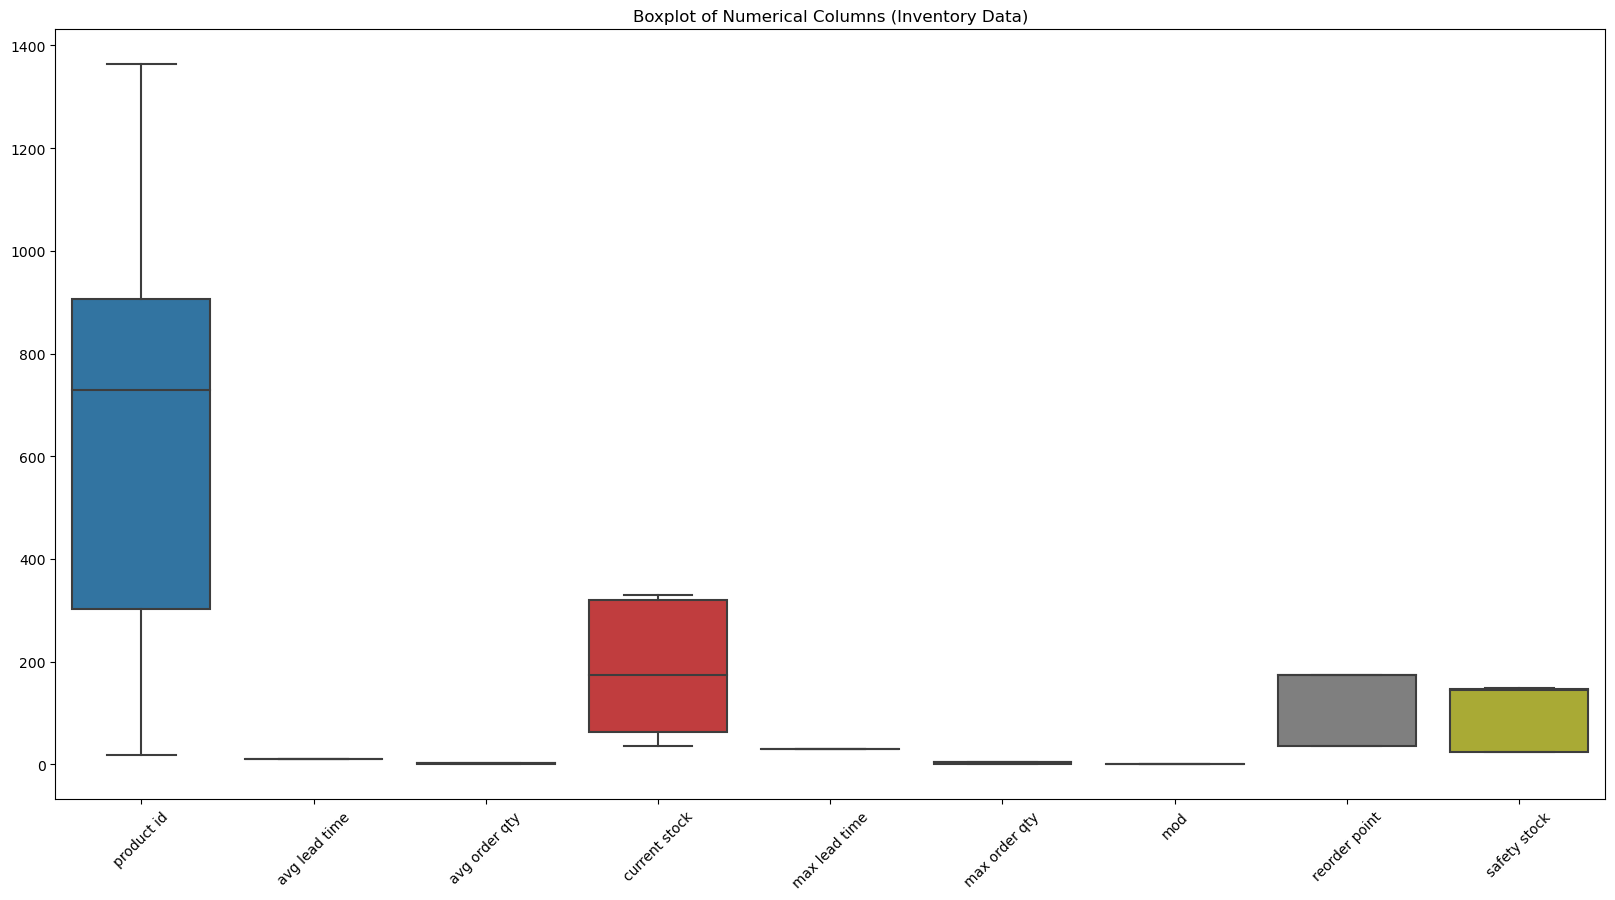

In [13]:
# Check for outliers using box plots.
plt.figure(figsize=(20,10))
sns.boxplot(data=InvStock[InvStock.select_dtypes(include=['number']).columns])
plt.title("Boxplot of Numerical Columns (Inventory Data)")
plt.xticks(rotation=45)
plt.show()

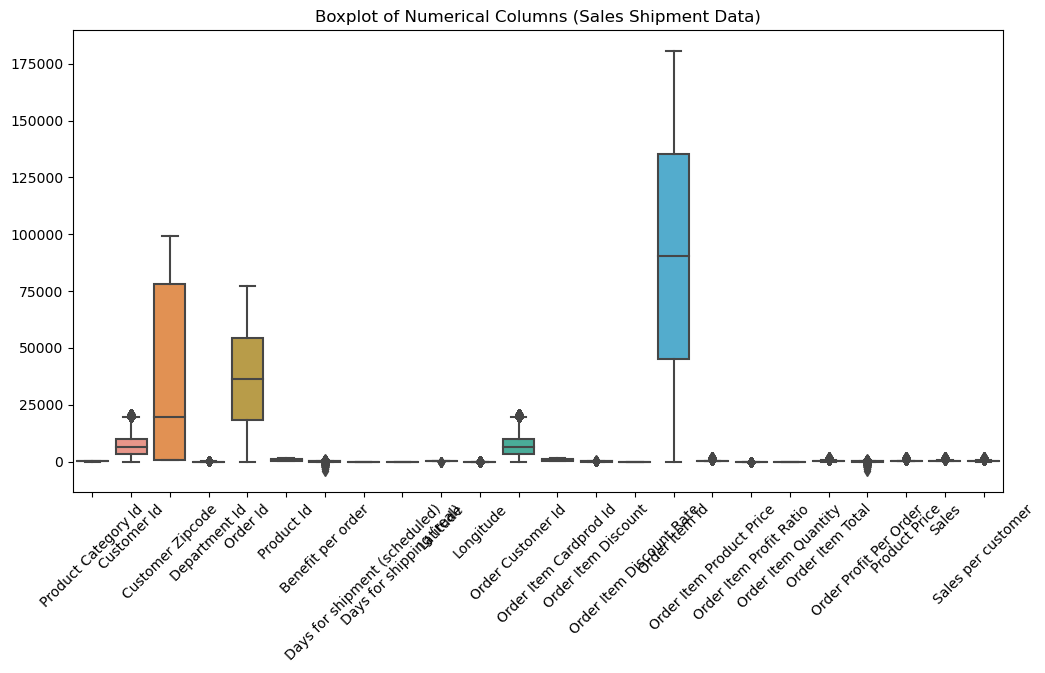

In [14]:
plt.figure(figsize=(12,6))
sns.boxplot(data=SalesShip[SalesShip.select_dtypes(include=['number']).columns])
plt.title("Boxplot of Numerical Columns (Sales Shipment Data)")
plt.xticks(rotation=45)
plt.show()

In [15]:
# Summary statistics for numerical columns of Inventory_Stock_Data
summary_statistics = InvStock.describe()
print("Summary Statistics of Inventory_Stock_Data :")
print(summary_statistics)

Summary Statistics of Inventory_Stock_Data :
        product id  avg lead time  avg order qty  current stock  \
count   118.000000          118.0     118.000000     118.000000   
mean    689.576271           10.0       2.084746     160.720339   
std     403.120380            0.0       1.000652     115.003819   
min      19.000000           10.0       1.000000      35.000000   
25%     303.500000           10.0       1.000000      63.000000   
50%     729.000000           10.0       3.000000     175.000000   
75%     905.750000           10.0       3.000000     321.000000   
max    1363.000000           10.0       3.000000     330.000000   

       max lead time  max order qty         mod  reorder point  safety stock  
count          118.0     118.000000  118.000000     118.000000    118.000000  
mean            30.0       3.169492    0.542373     110.932203     90.330508  
std              0.0       2.001303    0.500326      70.045617     60.270055  
min             30.0       1.000000

In [16]:
# Summary statistics for numerical columns of Sales_Shipment_Data
summary_statistics = SalesShip.describe()
print("Summary Statistics of Sales_Shipment_Data :")
print(summary_statistics)

Summary Statistics of Sales_Shipment_Data :
       Product Category Id    Customer Id  Customer Zipcode  Department Id  \
count        180519.000000  180519.000000     180516.000000  180519.000000   
mean             31.851451    6691.379495      35921.126914       5.443460   
std              15.640064    4162.918106      37542.461122       1.629246   
min               2.000000       1.000000        603.000000       2.000000   
25%              18.000000    3258.500000        725.000000       4.000000   
50%              29.000000    6457.000000      19380.000000       5.000000   
75%              45.000000    9779.000000      78207.000000       7.000000   
max              76.000000   20757.000000      99205.000000      12.000000   

            Order Id     Product Id  Benefit per order  \
count  180519.000000  180519.000000      180519.000000   
mean    36221.894903     692.509764          21.974989   
std     21045.379569     336.446807         104.433526   
min         1.000000 

In [17]:
# Unique values in categorical columns of Inventory_Stock_Data
unique_values_categorical = InvStock.select_dtypes(include='object').nunique()
print("Unique Values in Categorical Columns of Inventory_Stock_Data:")
print(unique_values_categorical)

Unique Values in Categorical Columns of Inventory_Stock_Data:
order-now         2
product name    118
dtype: int64


In [18]:
# Unique values in categorical columns of Sales_Shipment_Data
unique_values_categorical = SalesShip.select_dtypes(include='object').nunique()
print("Unique Values in Categorical Columns of Sales_Shipment_Data:")
print(unique_values_categorical)

Unique Values in Categorical Columns of Sales_Shipment_Data:
Category Name                    50
Class                             3
Customer City                   563
Customer Country                  2
Customer Fname                  782
Customer Lname                 1109
Customer Segment                  3
Customer State                   46
Customer Street                6953
Delivery Status                   4
Department Name                  11
Market                            5
Order City                     3597
Order Country                   164
order date (DateOrders)       65752
Order Region                     23
Order State                    1089
Order Status                      9
Product Name                    118
shipping date (DateOrders)    63701
Shipping Mode                     4
Type                              4
dtype: int64


In [19]:
# Column datatypes for Inventory_Stock_Data
InvStock.dtypes

order-now        object
product id        int64
product name     object
avg lead time     int64
avg order qty     int64
current stock     int64
max lead time     int64
max order qty     int64
mod               int64
reorder point     int64
safety stock      int64
dtype: object

In [20]:
# Column datatypes for Sales_Shipment_Data
SalesShip.dtypes

Product Category Id                int64
Category Name                     object
Class                             object
Customer City                     object
Customer Country                  object
Customer Fname                    object
Customer Id                        int64
Customer Lname                    object
Customer Segment                  object
Customer State                    object
Customer Street                   object
Customer Zipcode                 float64
Delivery Status                   object
Department Id                      int64
Department Name                   object
Market                            object
Order City                        object
Order Country                     object
order date (DateOrders)           object
Order Id                           int64
Order Region                      object
Order State                       object
Order Status                      object
Product Id                         int64
Product Name    

Observations:
1. There are missing values in Customer Zipcode & Customer Lname of Sales_Shipment_Data.
2. Some variable names are syntactically incorrect.
3. The columns order date (DateOrders) & shipping date (DateOrders) of Sales_Shipment_Data are in object datatype instead of datetime datatype.
4. Datatype of all ID's are in int instead of object.

## 4.  Detailed EDA - Univariate & Bi Variate analysis for each variable (distributions)

### Univariate analysis

In [21]:
Numeric_Column_Inv=InvStock.select_dtypes(include=["number"]).columns
Numeric_Column_Sales=SalesShip.select_dtypes(include=["number"]).columns
Category_Column_Inv=InvStock.select_dtypes(include=["object"]).columns
Category_Column_Sales=SalesShip.select_dtypes(include=["object"]).columns

In [22]:
# Univariate descriptive analysis for numerical columns (Sales Shipment Data)
numerical_summary_sales = SalesShip.describe()
numerical_summary_sales

Product Category Id    Customer Id  Customer Zipcode  Department Id  \
count        180519.000000  180519.000000     180516.000000  180519.000000   
mean             31.851451    6691.379495      35921.126914       5.443460   
std              15.640064    4162.918106      37542.461122       1.629246   
min               2.000000       1.000000        603.000000       2.000000   
25%              18.000000    3258.500000        725.000000       4.000000   
50%              29.000000    6457.000000      19380.000000       5.000000   
75%              45.000000    9779.000000      78207.000000       7.000000   
max              76.000000   20757.000000      99205.000000      12.000000   

            Order Id     Product Id  Benefit per order  \
count  180519.000000  180519.000000      180519.000000   
mean    36221.894903     692.509764          21.974989   
std     21045.379569     336.446807         104.433526   
min         1.000000      19.000000       -4274.979980   
25%     18057.000000     403.000000           7.000000   
50%     36140.000000     627.000000          31.520000   
75%     54144.000000    1004.000000          64.800003   
max     77204.000000    1363.000000         911.799988   

       Days for shipment (scheduled)  Days for shipping (real)       Latitude  \
count                  180519.000000             180519.000000  180519.000000   
mean                        2.931847                  3.497654      29.719955   
std                         1.374449                  1.623722       9.813646   
min                         0.000000                  0.000000     -33.937553   
25%                         2.000000                  2.000000      18.265432   
50%                         4.000000                  3.000000      33.144863   
75%                         4.000000                  5.000000      39.279617   
max                         4.000000                  6.000000      48.781933   

       ...  Order Item Discount Rate  Order Item Id  Order Item Product Price  \
count  ...             180519.000000  180519.000000             180519.000000   
mean   ...                  0.101668   90260.000000                141.232550   
std    ...                  0.070415   52111.490959                139.732492   
min    ...                  0.000000       1.000000                  9.990000   
25%    ...                  0.040000   45130.500000                 50.000000   
50%    ...                  0.100000   90260.000000                 59.990002   
75%    ...                  0.160000  135389.500000                199.990005   
max    ...                  0.250000  180519.000000               1999.989990   

       Order Item Profit Ratio  Order Item Quantity  Order Item Total  \
count            180519.000000        180519.000000     180519.000000   
mean                  0.120647             2.127638        183.107609   
std                   0.466796             1.453451        120.043670   
min                  -2.750000             1.000000          7.490000   
25%                   0.080000             1.000000        104.379997   
50%                   0.270000             1.000000        163.990005   
75%                   0.360000             3.000000        247.399994   
max                   0.500000             5.000000       1939.989990   

       Order Profit Per Order  Product Price          Sales  \
count           180519.000000  180519.000000  180519.000000   
mean                21.974989     141.232550     203.772096   
std                104.433526     139.732492     132.273077   
min              -4274.979980       9.990000       9.990000   
25%                  7.000000      50.000000     119.980003   
50%                 31.520000      59.990002     199.919998   
75%                 64.800003     199.990005     299.950012   
max                911.799988    1999.989990    1999.989990   

       Sales per customer  
count       180519.000000  
mean           183.107609  
std        

In [23]:
# Univariate descriptive analysis for categorical columns (Sales Shipment Data)
categorical_summary_sales = SalesShip.describe(include=['object'])
categorical_summary_sales

Category Name                    Class Customer City Customer Country  \
count         180519                   180519        180519           180519   
unique            50                        3           563                2   
top           Cleats  High Value-Small Number        Caguas          EE. UU.   
freq           24551                    67738         66770           111146   

       Customer Fname Customer Lname Customer Segment Customer State  \
count          180519         180511           180519         180519   
unique            782           1109                3             46   
top              Mary          Smith         Consumer             PR   
freq            65150          64104            93504          69373   

                Customer Street Delivery Status  ...     Order City  \
count                    180519          180519  ...         180519   
unique                     6953               4  ...           3597   
top     9126 Wishing Expressway            Late  ...  Santo Domingo   
freq                        124           98977  ...           2211   

         Order Country order date (DateOrders)     Order Region Order State  \
count           180519                  180519           180519      180519   
unique             164                   65752               23        1089   
top     Estados Unidos          2/15/2017 9:04  Central America  Inglaterra   
freq             24840                       5            28341        6722   

       Order Status                      Product Name  \
count        180519                            180519   
unique            9                               118   
top        Complete  Perfect Fitness Perfect Rip Deck   
freq          59491                             24515   

       shipping date (DateOrders)   Shipping Mode    Type  
count                      180519          180519  180519  
unique                      63701               4       4  
top                 01/05/16 5:58  Standard Class   DEBIT  
freq                           10          107752   69295  

[4 rows x 22 columns]

In [24]:
# Univariate descriptive analysis for numerical columns (Inventory Stock Data)
numerical_summary_inventory = InvStock.describe()
numerical_summary_inventory

product id  avg lead time  avg order qty  current stock  \
count   118.000000          118.0     118.000000     118.000000   
mean    689.576271           10.0       2.084746     160.720339   
std     403.120380            0.0       1.000652     115.003819   
min      19.000000           10.0       1.000000      35.000000   
25%     303.500000           10.0       1.000000      63.000000   
50%     729.000000           10.0       3.000000     175.000000   
75%     905.750000           10.0       3.000000     321.000000   
max    1363.000000           10.0       3.000000     330.000000   

       max lead time  max order qty         mod  reorder point  safety stock  
count          118.0     118.000000  118.000000     118.000000    118.000000  
mean            30.0       3.169492    0.542373     110.932203     90.330508  
std              0.0       2.001303    0.500326      70.045617     60.270055  
min             30.0       1.000000    0.000000      35.000000     25.000000  
25%             30.0       1.000000    0.000000      35.000000     25.000000  
50%             30.0       5.000000    1.000000     175.000000    144.000000  
75%             30.0       5.000000    1.000000     175.000000    146.000000  
max             30.0       5.000000    1.000000     175.000000    148.000000

In [25]:
# Univariate descriptive analysis for categorical columns (Inventory Stock Data)
categorical_summary_inventory = InvStock.describe(include=['object'])
categorical_summary_inventory

order-now                             product name
count        118                                      118
unique         2                                      118
top        green  Nike Men's Fingertrap Max Training Shoe
freq          64                                        1

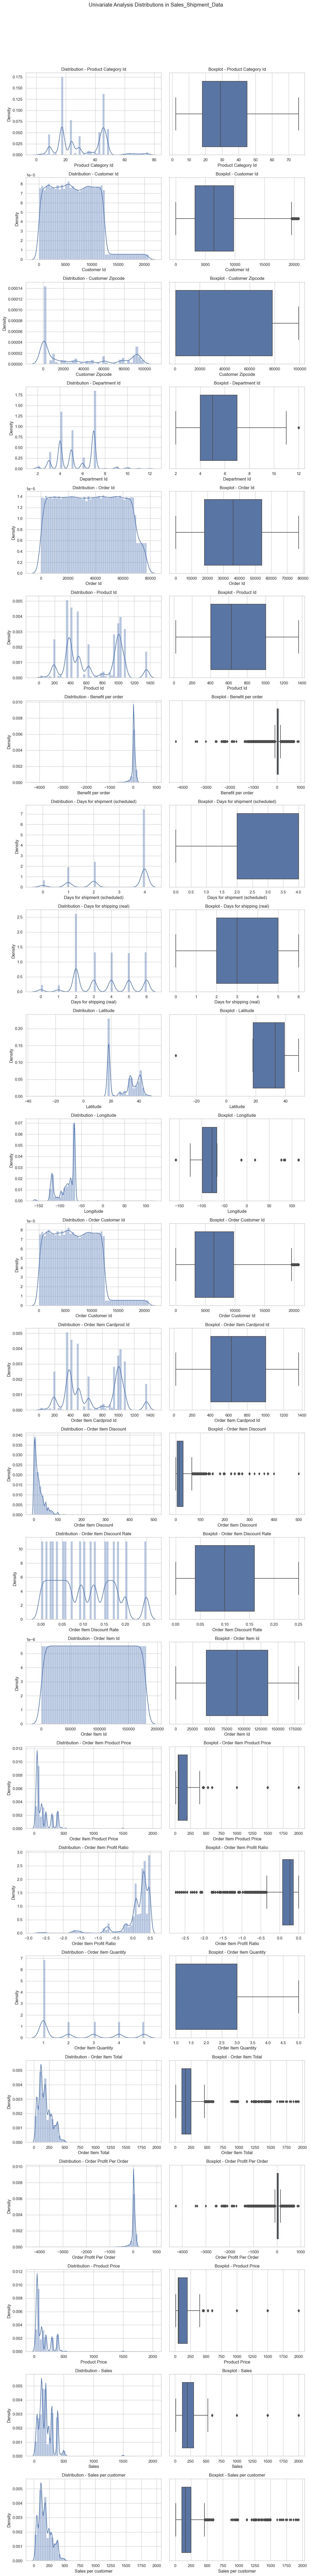

In [26]:
# Univariate Analysis Distributions in Sales_Shipment_Data - Histogram
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=len(Numeric_Column_Sales), ncols=2, figsize=(12, 4 * len(Numeric_Column_Sales)))
fig.suptitle('Univariate Analysis Distributions in Sales_Shipment_Data', y=1.02)

for i, column in enumerate(Numeric_Column_Sales):
    sns.distplot(SalesShip[column], ax=axes[i, 0], kde_kws={'bw': 0.1})
    axes[i, 0].set_title(f'Distribution - {column}')
    
    sns.boxplot(x=SalesShip[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot - {column}')

plt.tight_layout()
plt.show()

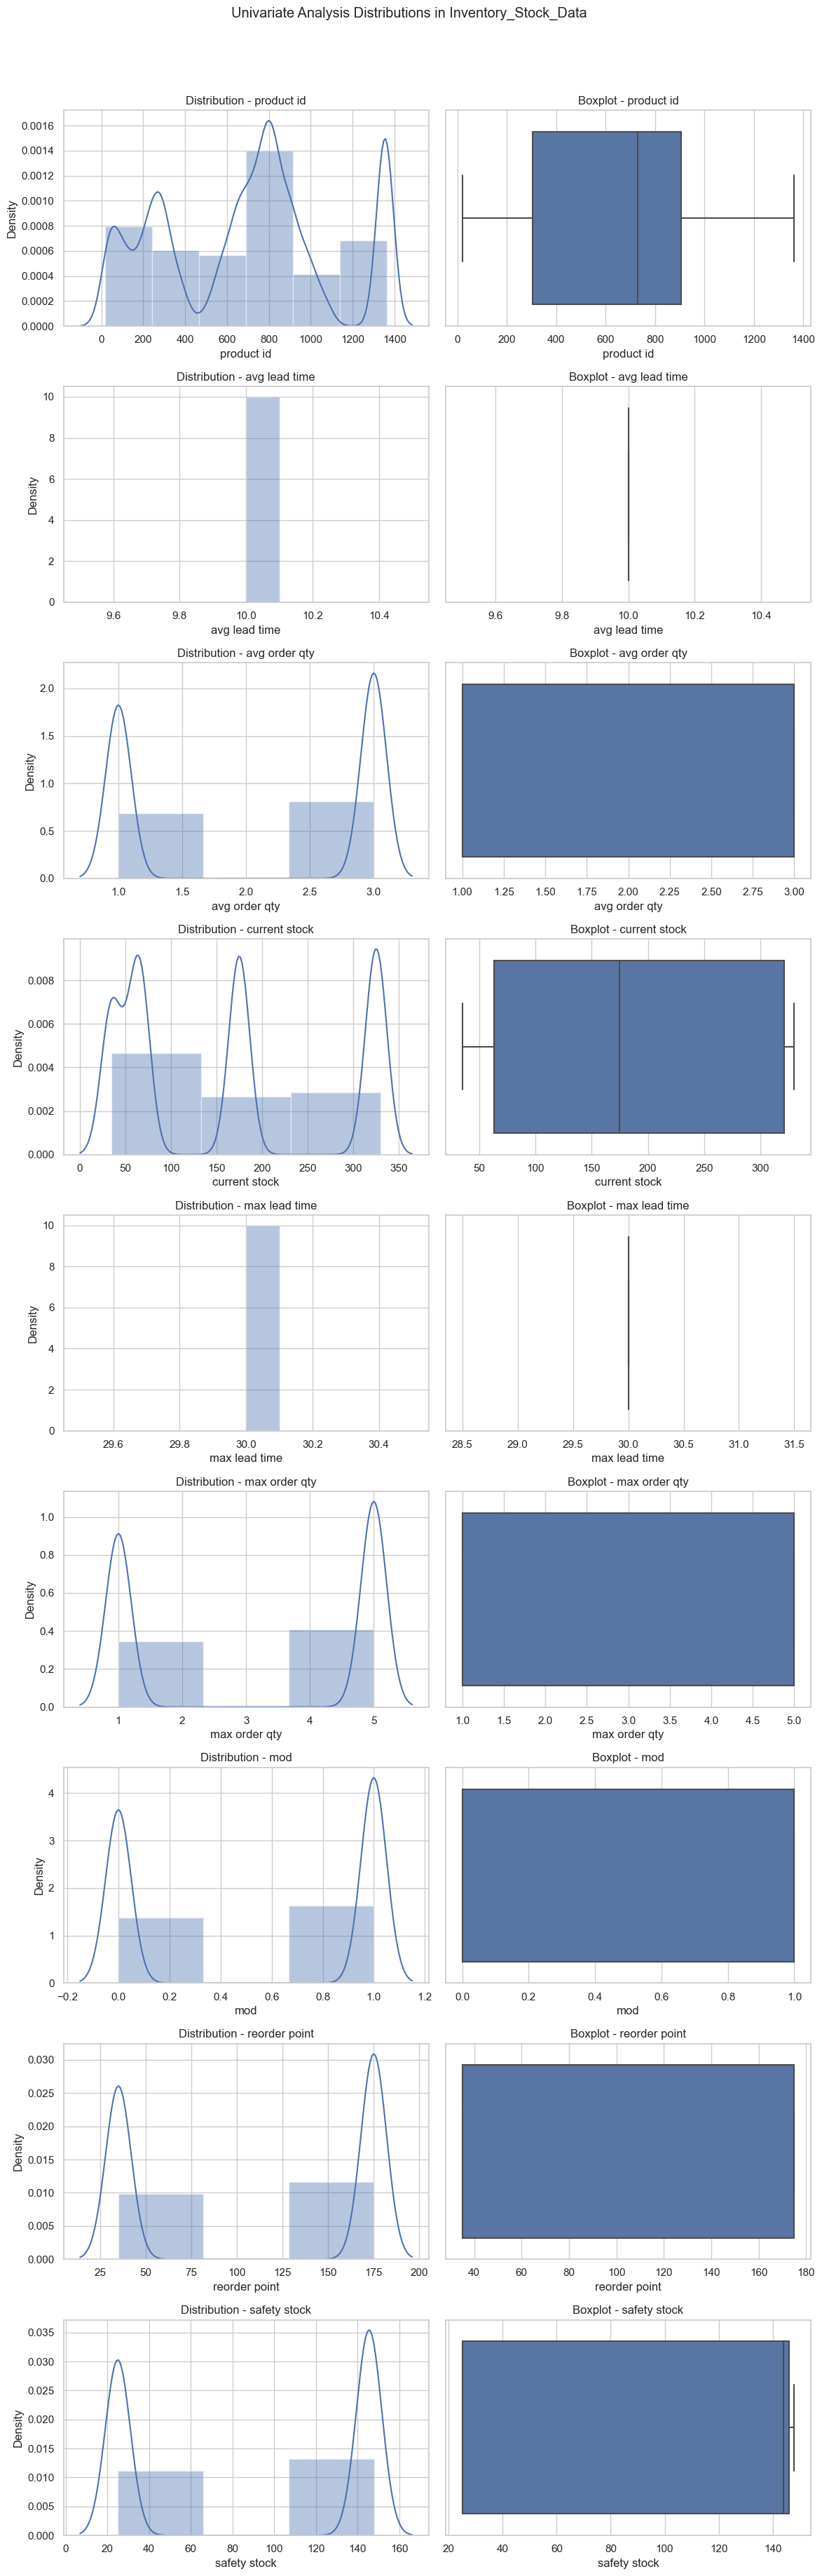

In [27]:
# Univariate Analysis Distributions in Inventory_Stock_Data - Histogram
fig, axes = plt.subplots(nrows=len(Numeric_Column_Inv), ncols=2, figsize=(12, 4 * len(Numeric_Column_Inv))) 
fig.suptitle('Univariate Analysis Distributions in Inventory_Stock_Data', y=1.02)

for i, column in enumerate(Numeric_Column_Inv):
    sns.distplot(InvStock[column], ax=axes[i, 0], kde_kws={'bw': 0.1})
    axes[i, 0].set_title(f'Distribution - {column}')
    
    sns.boxplot(x=InvStock[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot - {column}')

plt.tight_layout()
plt.show()

In [28]:
# Categorical columns for univariate analysis
Category_Column_Sales= Category_Column_Sales.difference(['Customer City','Customer Fname', 
                                     'Customer State','Category Name','Customer Lname','Customer Street',
                                     'order date (DateOrders)','Product Name','shipping date (DateOrders)',
                                         'Order City', 'Order State','Order Country'])
Category_Column_Sales

Index(['Class', 'Customer Country', 'Customer Segment', 'Delivery Status',
       'Department Name', 'Market', 'Order Region', 'Order Status',
       'Shipping Mode', 'Type'],
      dtype='object')

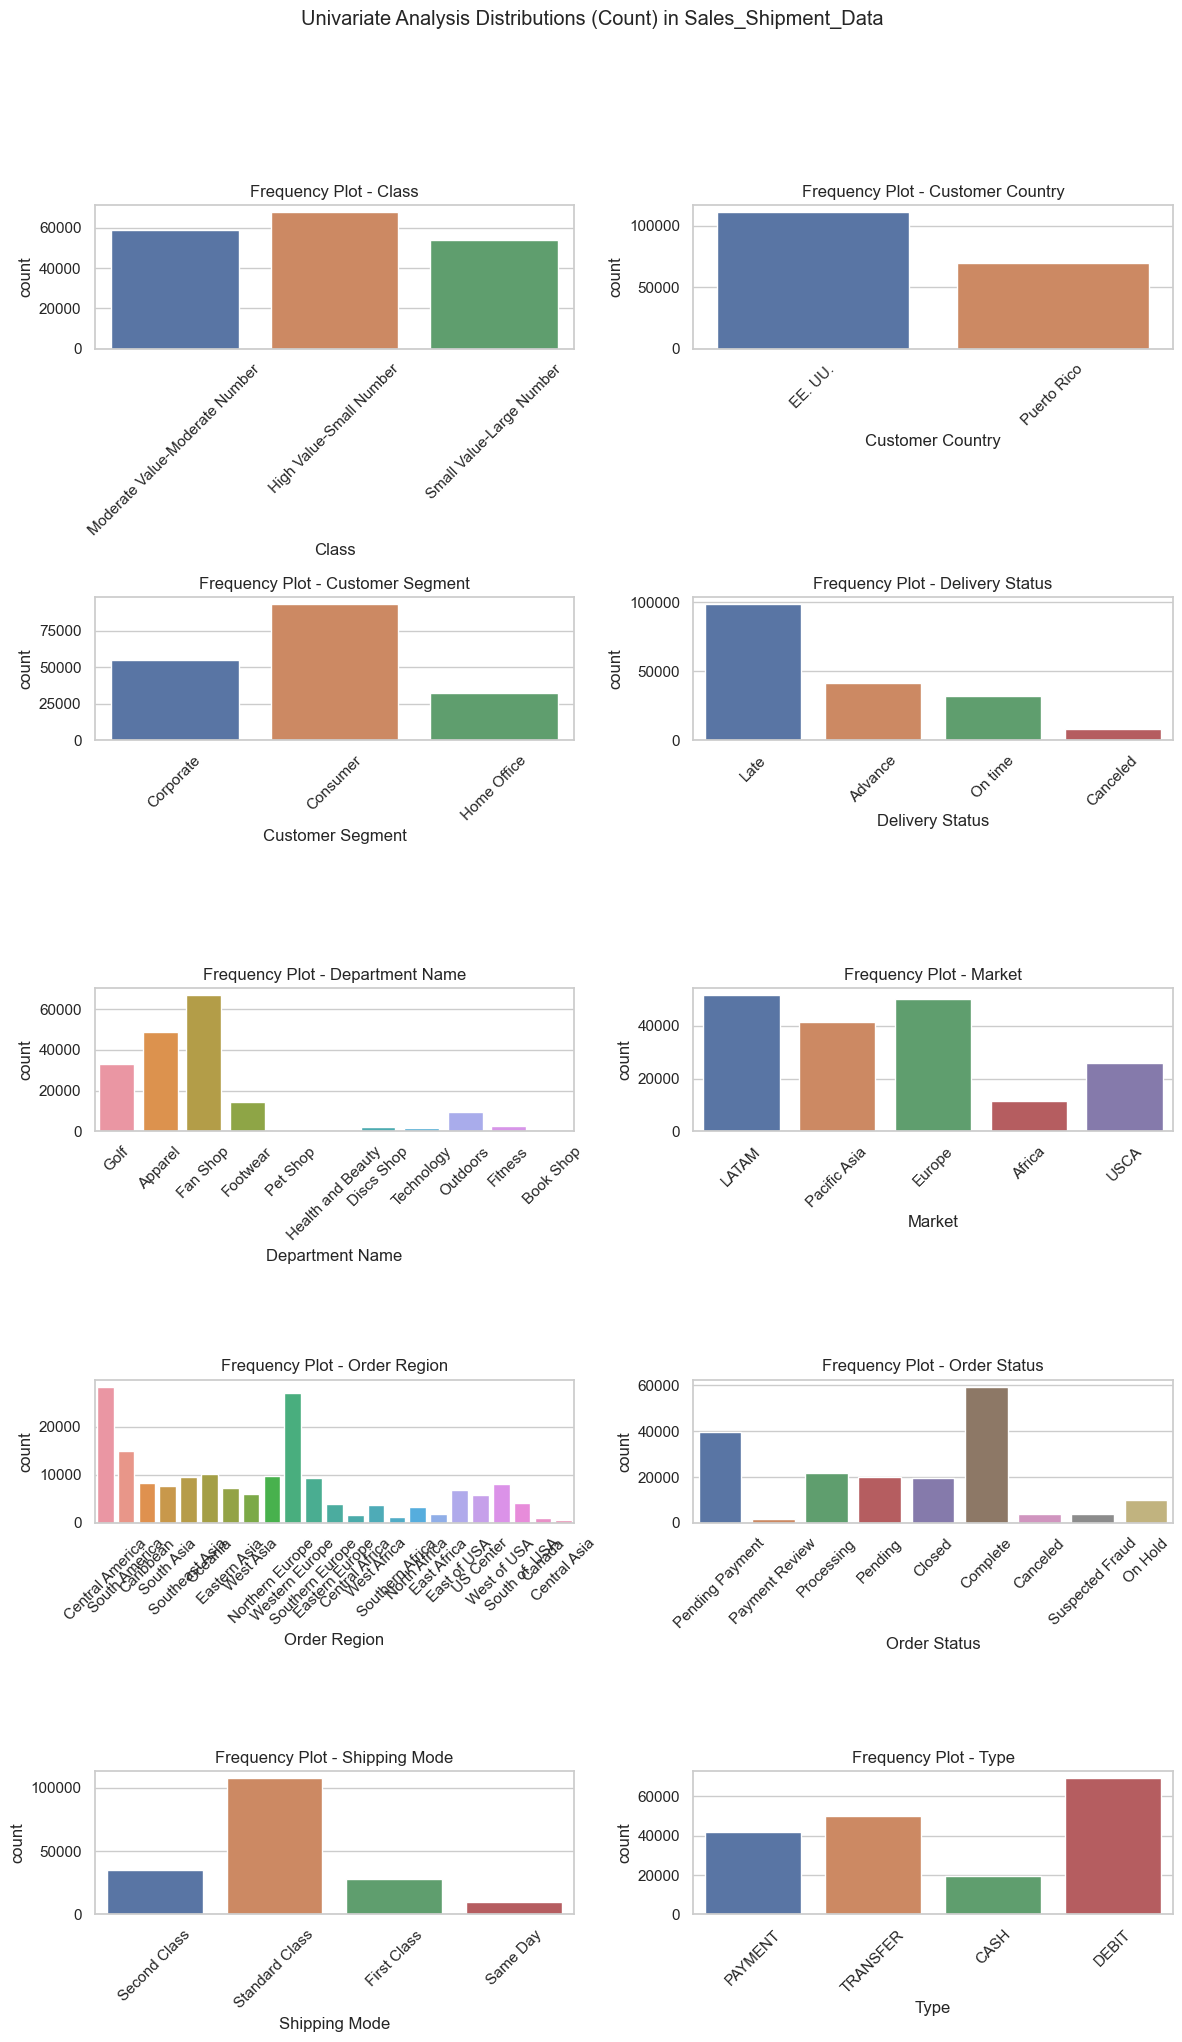

In [29]:
# Univariate Analysis Distributions (Frequency) in Sales_Shipment_Data - Histogram
sns.set(style="whitegrid")

n_cols = 2 
n_rows = (len(Category_Column_Sales) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 4 * n_rows))
fig.suptitle('Univariate Analysis Distributions (Count) in Sales_Shipment_Data', y=1.02)

for i, column in enumerate(Category_Column_Sales):
    ax = axes[i // n_cols, i % n_cols]
    sns.countplot(x=SalesShip[column], ax=ax)
    ax.set_title(f'Frequency Plot - {column}')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

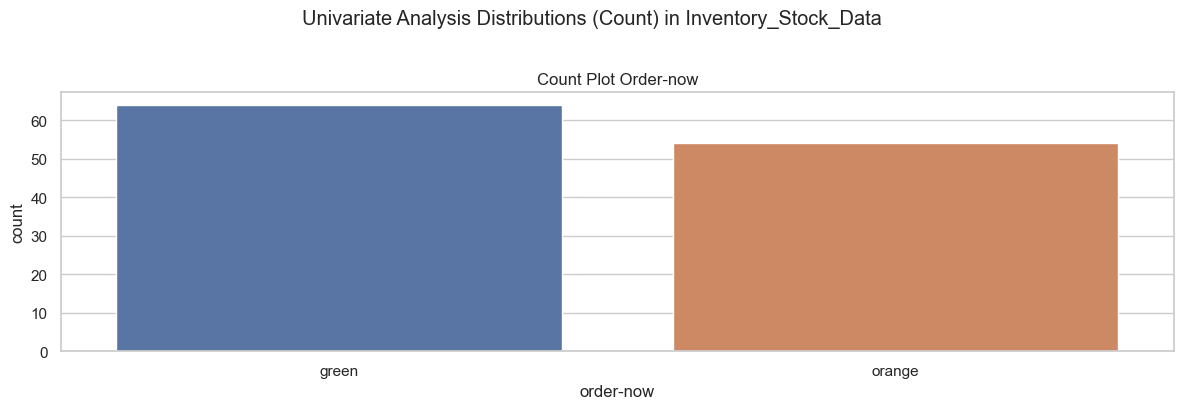

In [30]:
# Univariate Analysis Distributions (Frequency) in Inventory_Stock_Data - Histogram
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
fig.suptitle('Univariate Analysis Distributions (Count) in Inventory_Stock_Data', y=1.02)

sns.countplot(x=InvStock['order-now']).set_title(f'Count Plot Order-now')

plt.tight_layout()
plt.show()

### Bi Variate analysis

In [31]:
# Bivariate analysis - correlation matrix for numerical columns (Sales Shipment Data)
correlation_matrix_sales = SalesShip.corr(numeric_only=True)
correlation_matrix_sales

Product Category Id  Customer Id  \
Product Category Id                       1.000000     0.274633   
Customer Id                               0.274633     1.000000   
Customer Zipcode                          0.002898     0.002022   
Department Id                             0.888835     0.136897   
Order Id                                  0.198496     0.204821   
Product Id                                0.991092     0.228039   
Benefit per order                         0.031889     0.009354   
Days for shipment (scheduled)            -0.000367     0.000899   
Days for shipping (real)                 -0.000348     0.003432   
Latitude                                  0.002195     0.002335   
Longitude                                -0.002320    -0.005146   
Order Customer Id                         0.274633     1.000000   
Order Item Cardprod Id                    0.991092     0.228039   
Order Item Discount                       0.140180     0.038490   
Order Item Discount Rate                  0.000572     0.001712   
Order Item Id                             0.186796     0.191814   
Order Item Product Price                  0.461059     0.111118   
Order Item Profit Ratio                  -0.001614    -0.000337   
Order Item Quantity                      -0.302408    -0.091328   
Order Item Total                          0.225201     0.060181   
Order Profit Per Order                    0.031889     0.009354   
Product Price                             0.461059     0.111118   
Sales                                     0.227483     0.060961   
Sales per customer                        0.225201     0.060181   

                               Customer Zipcode  Department Id  Order Id  \
Product Category Id                    0.002898       0.888835  0.198496   
Customer Id                            0.002022       0.136897  0.204821   
Customer Zipcode                       1.000000       0.002878 -0.001210   
Department Id                          0.002878       1.000000  0.106757   
Order Id                              -0.001210       0.106757  1.000000   
Product Id                             0.003173       0.906117  0.163416   
Benefit per order                      0.002235       0.031442  0.013716   
Days for shipment (scheduled)         -0.003019      -0.000262 -0.001878   
Days for shipping (real)               0.000112      -0.001631 -0.001711   
Latitude                               0.584553       0.002460 -0.002984   
Longitude                             -0.923921      -0.002435  0.002540   
Order Customer Id                      0.002022       0.136897  0.204821   
Order Item Cardprod Id                 0.003173       0.906117  0.163416   
Order Item Discount                   -0.001861       0.144617  0.049385   
Order Item Discount Rate              -0.000135       0.000255  0.000484   
Order Item Id                         -0.001208       0.101676  0.999623   
Order Item Product Price               0.002191       0.446743  0.115324   
Order Item Profit Ratio                0.003364      -0.003044  0.002760   
Order Item Quantity                   -0.006174      -0.265437 -0.087073   
Order Item Total                      -0.001304       0.232367  0.079000   
Order Profit Per Order                 0.002235       0.031442  0.013716   
Product Price                          0.002191       0.446743  0.115324   
Sales                                 -0.001490       0.234718  0.079835   
Sales per customer                    -0.001304       0.232367  0.079000   

                               Product Id  Benefit per order  \
Product Category Id              0.991092           0.031889   
Customer Id                      0.228039           0.009354   
Customer Zipcode                 0.003173           0.002235   
Department Id                    0.906117           0.031442   
Order Id                         0.163416           0.013716   
Product Id                       1.000000           0.033161   
Benefi

In [32]:
# Bivariate analysis - correlation matrix for numerical columns (Inventory Data)
correlation_matrix_inventory = InvStock.corr(numeric_only=True)
correlation_matrix_inventory

product id  avg lead time  avg order qty  current stock  \
product id       1.000000            NaN      -0.286631      -0.235948   
avg lead time         NaN            NaN            NaN            NaN   
avg order qty   -0.286631            NaN       1.000000       0.871480   
current stock   -0.235948            NaN       0.871480       1.000000   
max lead time         NaN            NaN            NaN            NaN   
max order qty   -0.286631            NaN       1.000000       0.871480   
mod             -0.001732            NaN      -0.058449       0.363764   
reorder point   -0.286631            NaN       1.000000       0.871480   
safety stock    -0.287076            NaN       0.999930       0.871106   

               max lead time  max order qty       mod  reorder point  \
product id               NaN      -0.286631 -0.001732      -0.286631   
avg lead time            NaN            NaN       NaN            NaN   
avg order qty            NaN       1.000000 -0.058449       1.000000   
current stock            NaN       0.871480  0.363764       0.871480   
max lead time            NaN            NaN       NaN            NaN   
max order qty            NaN       1.000000 -0.058449       1.000000   
mod                      NaN      -0.058449  1.000000      -0.058449   
reorder point            NaN       1.000000 -0.058449       1.000000   
safety stock             NaN       0.999930 -0.058999       0.999930   

               safety stock  
product id        -0.287076  
avg lead time           NaN  
avg order qty      0.999930  
current stock      0.871106  
max lead time           NaN  
max order qty      0.999930  
mod               -0.058999  
reorder point      0.999930  
safety stock       1.000000

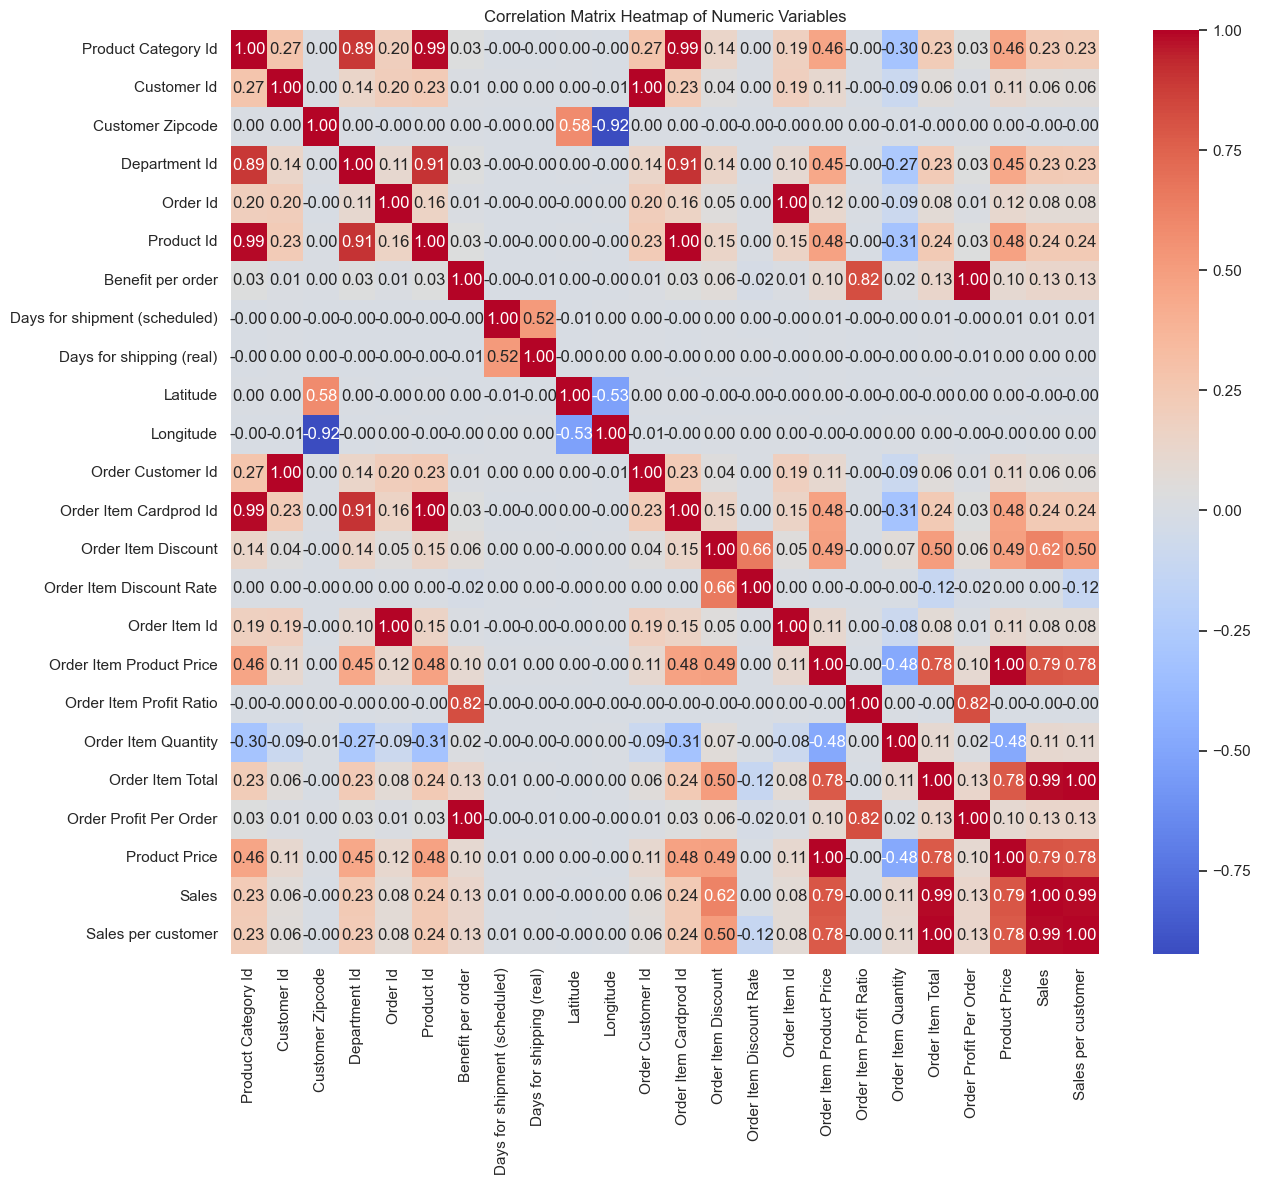

In [33]:
# For numeric - numeric
# Correlation heat map for sales_shipment_data
correlation_matrix = SalesShip[Numeric_Column_Sales].corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap of Numeric Variables')
plt.show()

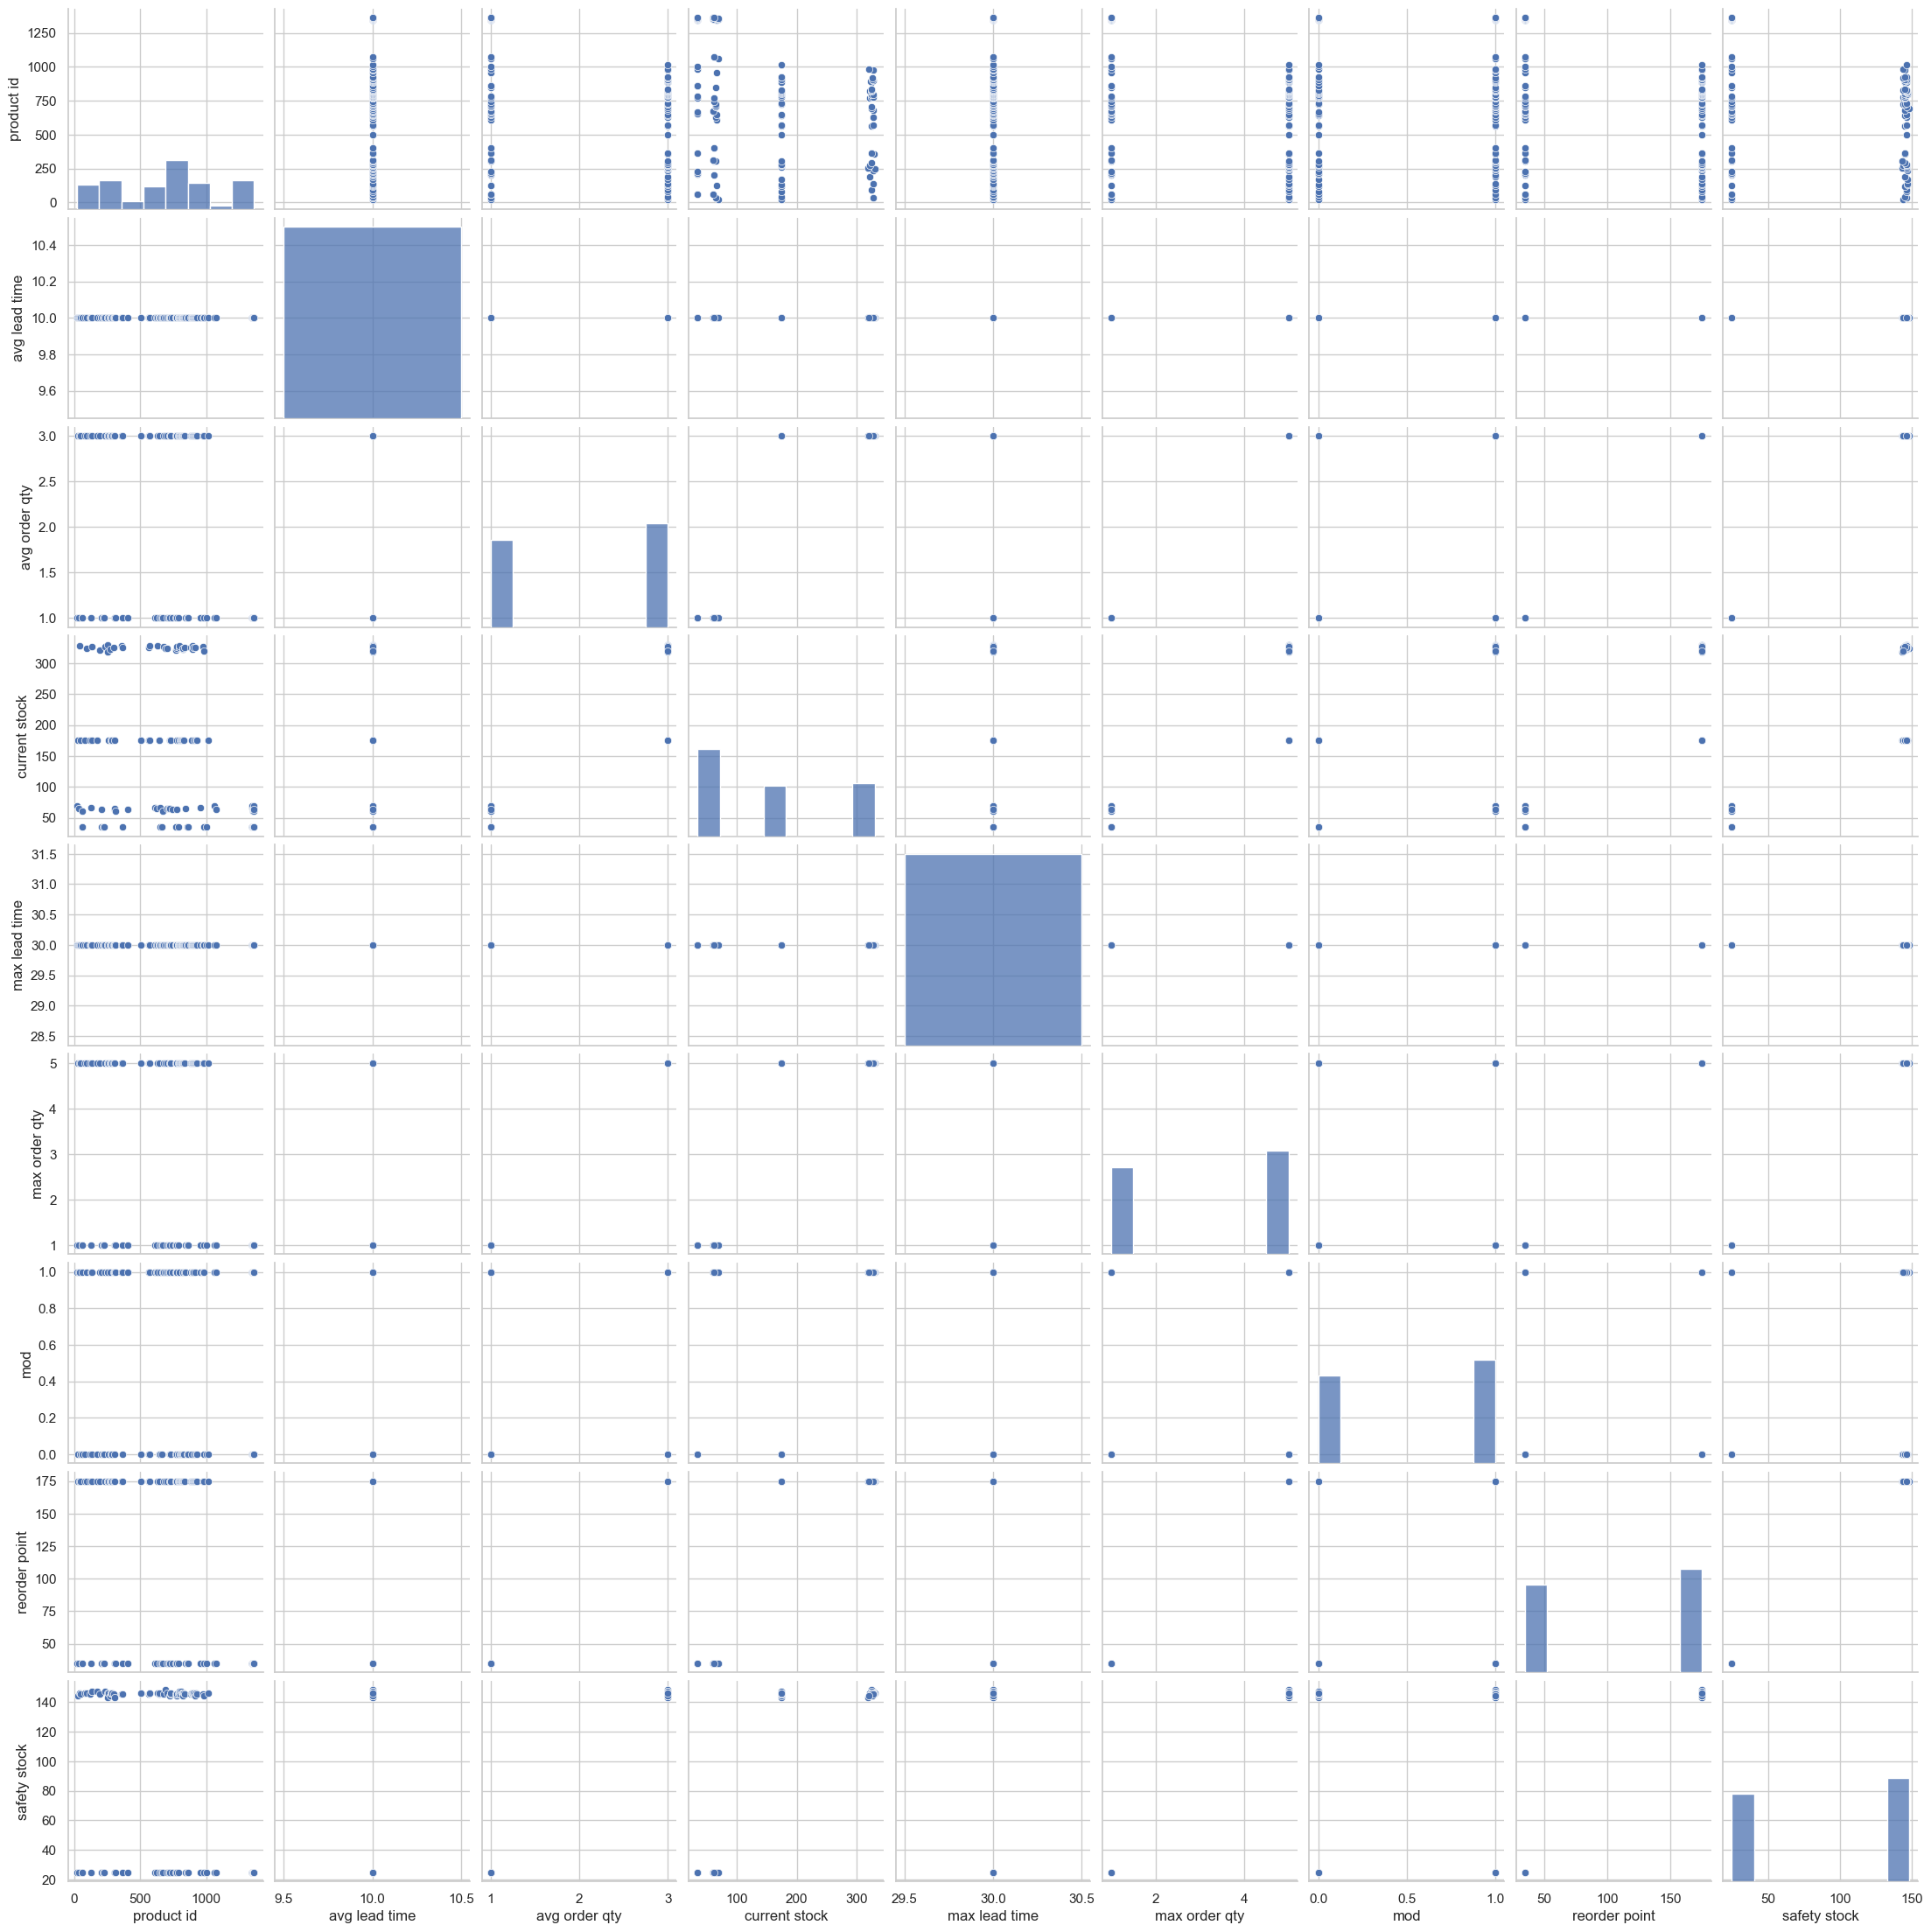

In [34]:
# Numeric - numeric correlation for Inventory Stock Data
sns.pairplot(InvStock.select_dtypes(include=['number']))

### [Categorical-Continuous] Bivariate Analysis

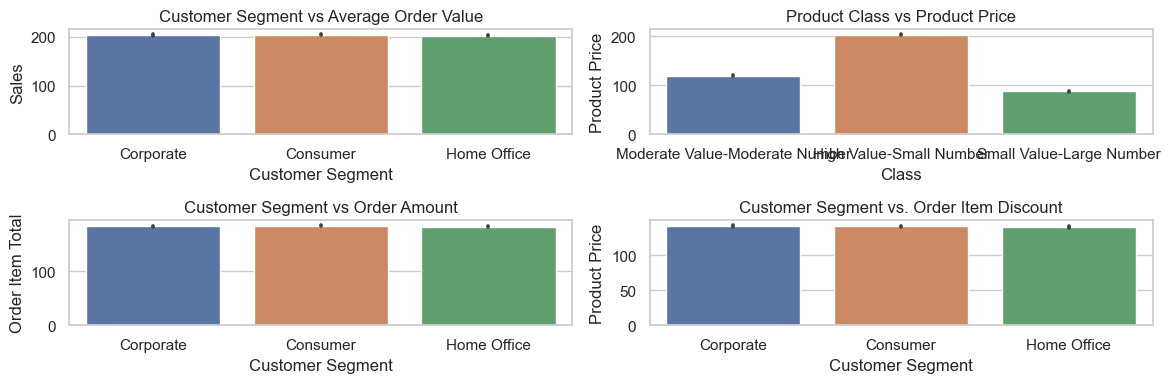

In [35]:
# Categorical - Numeric analysis for Sales Shipment Data
plt.figure(figsize=(12, 4))

plt.subplot(2, 2, 1)
sns.barplot(x='Customer Segment', y='Sales', data=SalesShip)
plt.title('Customer Segment vs Average Order Value')

plt.subplot(2, 2, 2)
sns.barplot(x='Class', y='Product Price', data=SalesShip)
plt.title('Product Class vs Product Price')

plt.subplot(2, 2, 3)
sns.barplot(x='Customer Segment', y='Order Item Total', data=SalesShip)
plt.title('Customer Segment vs Order Amount')

plt.subplot(2, 2, 4)
sns.barplot(x='Customer Segment', y='Product Price', data=SalesShip)
plt.title('Customer Segment vs. Order Item Discount')

plt.tight_layout()
plt.show()

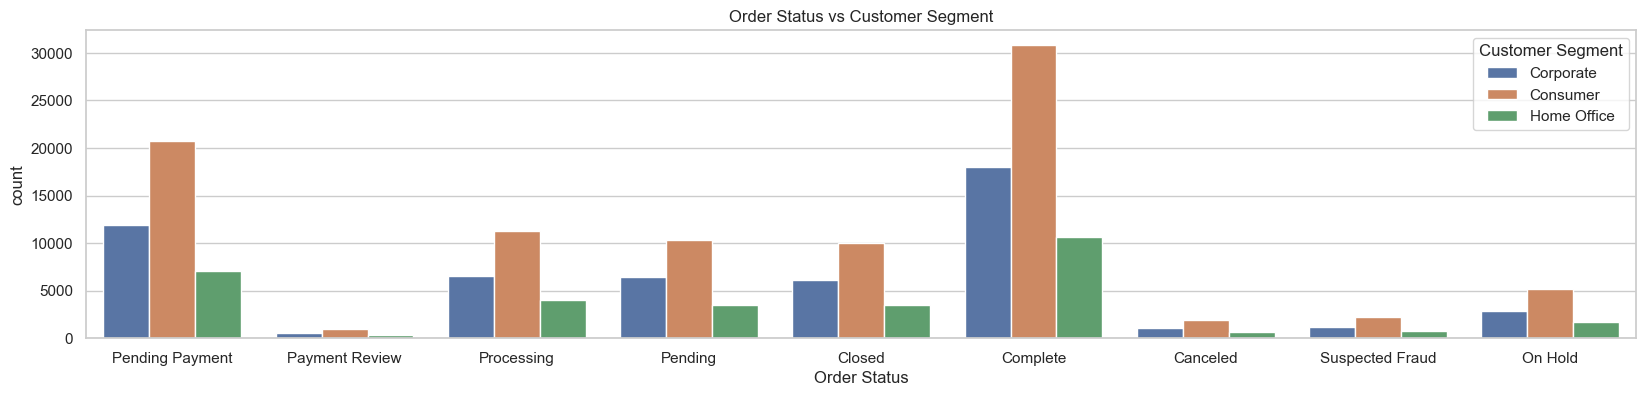

In [36]:
plt.figure(figsize=(20, 4))
sns.countplot(x='Order Status', hue='Customer Segment', data=SalesShip)
plt.title('Order Status vs Customer Segment')

plt.show()

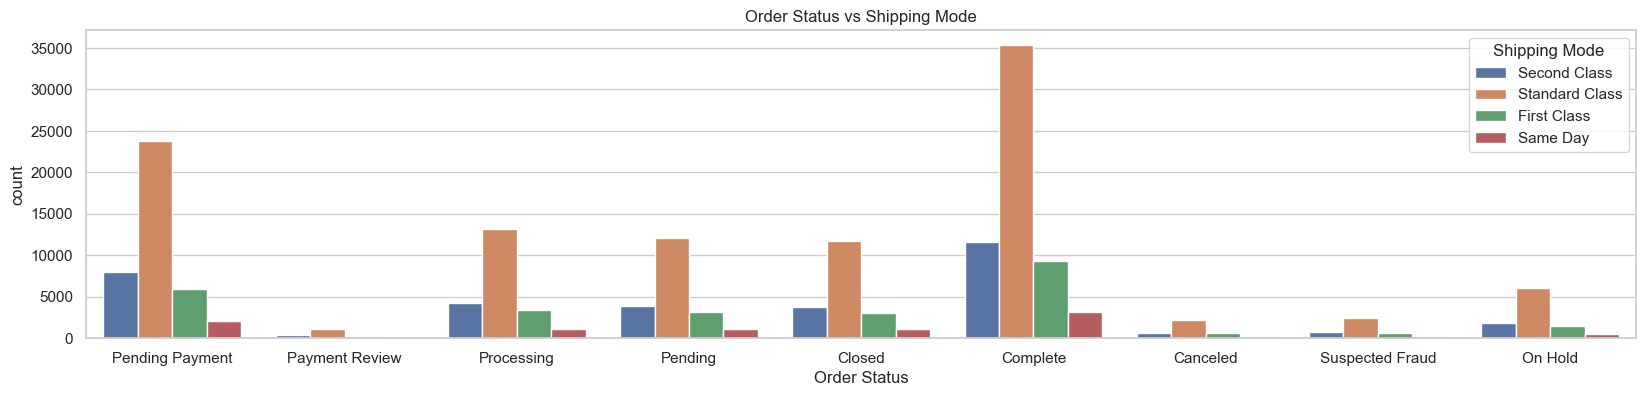

In [37]:
plt.figure(figsize=(20, 4))
sns.countplot(x='Order Status', hue='Shipping Mode', data=SalesShip)
plt.title('Order Status vs Shipping Mode')

plt.show()

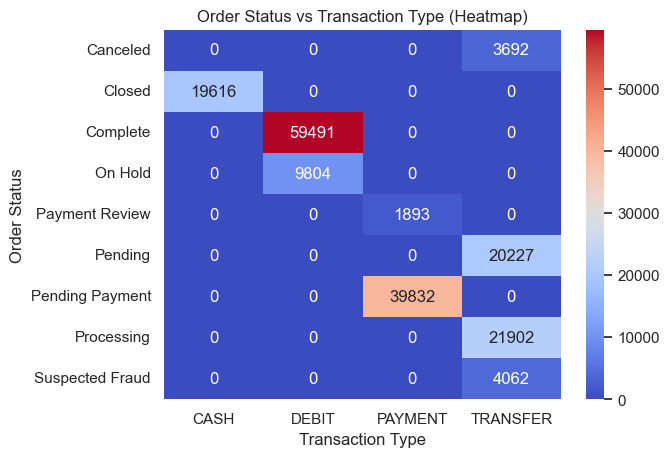

In [38]:
cross_tab_status_payment = pd.crosstab(SalesShip['Order Status'], SalesShip['Type'])
sns.heatmap(cross_tab_status_payment, annot=True, cmap='coolwarm', fmt='d')
plt.title('Order Status vs Transaction Type (Heatmap)')
plt.xlabel('Transaction Type')
plt.ylabel('Order Status')
plt.show()

## 5. Find out data related issues based on the data Audit

* Need to change the datatype of some variable.
* Need to fix the column name.
* Need to fill or drop the missing values. 

# b. Data Preparation: (Weightage - 15%)

## 1. Creat new flag variable Late Delivery Risk based on Days for shipping (real) & Days for shipment (scheduled) (Flag=Not Late if shipment is not delayed and Flag=Late if shipment is delayed)

In [39]:
SalesShip['Late Delivery Risk '] = SalesShip.apply(lambda x: "Late" if x['Days for shipping (real)'] > x['Days for shipment (scheduled)'] else "Not Late", axis=1)
SalesShip.head()

Product Category Id    Category Name                           Class  \
0                   24  Women's Apparel  Moderate Value-Moderate Number   
1                   24  Women's Apparel  Moderate Value-Moderate Number   
2                   24  Women's Apparel  Moderate Value-Moderate Number   
3                   24  Women's Apparel  Moderate Value-Moderate Number   
4                   24  Women's Apparel  Moderate Value-Moderate Number   

     Customer City Customer Country Customer Fname  Customer Id  \
0          Roswell          EE. UU.           Jean         5673   
1      Los Angeles          EE. UU.           Rose         9723   
2           Harvey          EE. UU.         Joshua         9511   
3         Elmhurst          EE. UU.           Mary         3326   
4  North Las Vegas          EE. UU.       Samantha          907   

  Customer Lname Customer Segment Customer State  ... Order Item Id  \
0           Dunn        Corporate             NM  ...        134920   
1          White        Corporate             CA  ...          9722   
2          Brady        Corporate             IL  ...        129954   
3          Smith        Corporate             IL  ...          2929   
4          Kline        Corporate             NV  ...        140056   

   Order Item Product Price Order Item Profit Ratio  Order Item Quantity  \
0                      50.0                    0.11                    2   
1                      50.0                    0.11                    2   
2                      50.0                    0.33                    2   
3                      50.0                    0.29                    2   
4                      50.0                    0.50                    2   

  Order Item Total Order Profit Per Order Product Price  Sales  \
0             85.0               9.610000          50.0  100.0   
1             84.0               9.490000          50.0  100.0   
2             94.5              30.709999          50.0  100.0   
3             95.0              27.549999          50.0  100.0   
4             95.0              47.500000          50.0  100.0   

  Sales per customer  Late Delivery Risk   
0               85.0                 Late  
1               84.0                 Late  
2               94.5                 Late  
3               95.0                 Late  
4               95.0                 Late  

[5 rows x 47 columns]

## 2. Rename the variables as per python naming convensions

In [40]:
new_name = {
    'Product Category Id': 'product_category_id',
    'Category Name': 'category_name',
    'Class': 'class',
    'Customer City': 'customer_city',
    'Customer Country': 'customer_country',
    'Customer Fname': 'customer_fname',
    'Customer Id': 'customer_id',
    'Customer Lname': 'customer_lname',
    'Customer Segment': 'customer_segment',
    'Customer State': 'customer_state',
    'Customer Street': 'customer_street',
    'Customer Zipcode': 'customer_zipcode',
    'Delivery Status': 'delivery_status',
    'Department Id': 'department_id',
    'Department Name': 'department_name',
    'Market': 'market',
    'Order City': 'order_city',
    'Order Country': 'order_country',
    'order date (DateOrders)': 'order_date',
    'Order Id': 'order_id',
    'Order Region': 'order_region',
    'Order State': 'order_state',
    'Order Status': 'order_status',
    'Product Id': 'product_id',
    'Product Name': 'product_name',
    'shipping date (DateOrders)': 'shipping_date',
    'Shipping Mode': 'shipping_mode',
    'Type': 'type',
    'Benefit per order': 'benefit_per_order',
    'Days for shipment (scheduled)': 'days_for_shipment_scheduled',
    'Days for shipping (real)': 'days_for_shipping_real',
    'Latitude': 'latitude',
    'Longitude': 'longitude',
    'Order Customer Id': 'order_customer_id',
    'Order Item Cardprod Id': 'order_item_cardprod_id',
    'Order Item Discount': 'order_item_discount',
    'Order Item Discount Rate': 'order_item_discount_rate',
    'Order Item Id': 'order_item_id',
    'Order Item Product Price': 'order_item_product_price',
    'Order Item Profit Ratio': 'order_item_profit_ratio',
    'Order Item Quantity': 'order_item_quantity',
    'Order Item Total': 'order_item_total',
    'Order Profit Per Order': 'order_profit_per_order',
    'Product Price': 'product_price',
    'Sales': 'sales',
    'Sales per customer': 'sales_per_customer',
    'Late Delivery Risk ': 'late_delivery_risk'
}

In [41]:
SalesShip = SalesShip.rename(columns=new_name)

In [42]:
SalesShip.columns

Index(['product_category_id', 'category_name', 'class', 'customer_city',
       'customer_country', 'customer_fname', 'customer_id', 'customer_lname',
       'customer_segment', 'customer_state', 'customer_street',
       'customer_zipcode', 'delivery_status', 'department_id',
       'department_name', 'market', 'order_city', 'order_country',
       'order_date', 'order_id', 'order_region', 'order_state', 'order_status',
       'product_id', 'product_name', 'shipping_date', 'shipping_mode', 'type',
       'benefit_per_order', 'days_for_shipment_scheduled',
       'days_for_shipping_real', 'latitude', 'longitude', 'order_customer_id',
       'order_item_cardprod_id', 'order_item_discount',
       'order_item_discount_rate', 'order_item_id', 'order_item_product_price',
       'order_item_profit_ratio', 'order_item_quantity', 'order_item_total',
       'order_profit_per_order', 'product_price', 'sales',
       'sales_per_customer', 'late_delivery_risk'],
      dtype='object')

In [43]:
InvStock.columns = [col.lower().replace(' ' , '_') for col in InvStock.columns]
InvStock.columns

Index(['order-now', 'product_id', 'product_name', 'avg_lead_time',
       'avg_order_qty', 'current_stock', 'max_lead_time', 'max_order_qty',
       'mod', 'reorder_point', 'safety_stock'],
      dtype='object')

## 3. Convert the variables data types as per the data descriptions

In [44]:
# Changing datatype of SalesShip['order_date']
SalesShip["Order_date"] = pd.to_datetime(SalesShip["order_date"], errors = 'coerce', format = "%m/%d/%Y %H:%M", infer_datetime_format = True)
SalesShip["order_Date"] = pd.to_datetime(SalesShip["order_date"], errors = 'coerce', format = "%m/%d/%y %H:%M", infer_datetime_format = True)
SalesShip["order_Date"] = SalesShip["order_Date"].fillna(SalesShip["Order_date"])

In [45]:
columns_to_drop = ['Order_date', 'order_date']
SalesShip.drop(columns_to_drop, axis=1, inplace=True)

In [46]:
SalesShip.rename(columns={'order_Date':'order_date'},inplace=True)

In [47]:
# Changing datatype of SalesShip['shipping_date']
SalesShip["Shipping_date"] = pd.to_datetime(SalesShip["shipping_date"], errors = 'coerce', format = "%m/%d/%Y %H:%M", infer_datetime_format = True)
SalesShip["shipping_Date"] = pd.to_datetime(SalesShip["shipping_date"], errors = 'coerce', format = "%m/%d/%y %H:%M", infer_datetime_format = True)
SalesShip["shipping_Date"] = SalesShip["shipping_Date"].fillna(SalesShip["Shipping_date"])

In [48]:
columns_to_drop = ['Shipping_date', 'shipping_date']
SalesShip.drop(columns_to_drop, axis=1, inplace=True)

In [49]:
SalesShip.rename(columns={'shipping_Date':'shipping_date'},inplace=True)

In [50]:
SalesShip['customer_zipcode'] = SalesShip['customer_zipcode'].astype('object')

## 4. Impute missing values with mean for numerical variables, mode for categorical variables

In [51]:
SalesShip['customer_lname'].fillna(SalesShip['customer_lname'].mode()[0],inplace = True)

In [52]:
SalesShip['customer_zipcode'].fillna(SalesShip['customer_zipcode'].mode()[0],inplace= True)

## 5. Perform any other data preparation steps as required?

In [53]:
# Merging the data
merged_data = pd.merge(right=SalesShip, 
                      left=InvStock, 
                      on=["product_id","product_name"], 
                      how="left")
merged_data

order-now  product_id                             product_name  \
0          green          19  Nike Men's Fingertrap Max Training Shoe   
1          green          19  Nike Men's Fingertrap Max Training Shoe   
2          green          19  Nike Men's Fingertrap Max Training Shoe   
3          green          19  Nike Men's Fingertrap Max Training Shoe   
4          green          19  Nike Men's Fingertrap Max Training Shoe   
...          ...         ...                                      ...   
180514     green        1363                           Summer dresses   
180515     green        1363                           Summer dresses   
180516     green        1363                           Summer dresses   
180517     green        1363                           Summer dresses   
180518     green        1363                           Summer dresses   

        avg_lead_time  avg_order_qty  current_stock  max_lead_time  \
0                  10              1             69             30   
1                  10              1             69             30   
2                  10              1             69             30   
3                  10              1             69             30   
4                  10              1             69             30   
...               ...            ...            ...            ...   
180514             10              1             63             30   
180515             10              1             63             30   
180516             10              1             63             30   
180517             10              1             63             30   
180518             10              1             63             30   

        max_order_qty  mod  reorder_point  ...  order_item_profit_ratio  \
0                   1    1             35  ...                     0.30   
1                   1    1             35  ...                     0.14   
2                   1    1             35  ...                     0.05   
3                   1    1             35  ...                     0.25   
4                   1    1             35  ...                     0.49   
...               ...  ...            ...  ...                      ...   
180514              1    1             35  ...                     0.46   
180515              1    1             35  ...                    -0.83   
180516              1    1             35  ...                     0.48   
180517              1    1             35  ...                     0.49   
180518              1    1             35  ...                    -0.22   

        order_item_quantity order_item_total order_profit_per_order  \
0                         1       112.489998              33.750000   
1                         1       103.739998              14.320000   
2                         1       106.239998               5.310000   
3                         1       104.989998              26.250000   
4                         1       124.989998              61.250000   
...                     ...              ...                    ...   
180514                    1       213.660004              98.279999   
180515                    1       209.350006            -172.710007   
180516                    1       207.190002              99.449997   
180517                    1       209.350006             102.580002   
180518                    1       176.970001             -38.400002   

       product_price       sales sales_per_customer  late_delivery_risk  \
0         124.989998  124.989998         112.489998                Late   
1         124.989998  124.989998         103.739998                Late   
2         124.989998  124.989998         106.239998                Late   
3         124.989998  124.989998         104.989998                Late   
4         124.989998  124.989998         124.989998                Late   
...              ...         ...                ...                 ...   
180514    

In [54]:
merged_data["order_year"] = merged_data["order_date"].dt.isocalendar().year
merged_data["order_week"] = merged_data["order_date"].dt.isocalendar().week
merged_data["order_month"] = merged_data["order_date"].dt.month
merged_data["order_quarter"] = merged_data["order_date"].dt.quarter
merged_data["order_hour"] = merged_data["order_date"].dt.hour
merged_data.head(10)

order-now  product_id                             product_name  \
0     green          19  Nike Men's Fingertrap Max Training Shoe   
1     green          19  Nike Men's Fingertrap Max Training Shoe   
2     green          19  Nike Men's Fingertrap Max Training Shoe   
3     green          19  Nike Men's Fingertrap Max Training Shoe   
4     green          19  Nike Men's Fingertrap Max Training Shoe   
5     green          19  Nike Men's Fingertrap Max Training Shoe   
6     green          19  Nike Men's Fingertrap Max Training Shoe   
7     green          19  Nike Men's Fingertrap Max Training Shoe   
8     green          19  Nike Men's Fingertrap Max Training Shoe   
9     green          19  Nike Men's Fingertrap Max Training Shoe   

   avg_lead_time  avg_order_qty  current_stock  max_lead_time  max_order_qty  \
0             10              1             69             30              1   
1             10              1             69             30              1   
2             10              1             69             30              1   
3             10              1             69             30              1   
4             10              1             69             30              1   
5             10              1             69             30              1   
6             10              1             69             30              1   
7             10              1             69             30              1   
8             10              1             69             30              1   
9             10              1             69             30              1   

   mod  reorder_point  ...       sales  sales_per_customer late_delivery_risk  \
0    1             35  ...  124.989998          112.489998               Late   
1    1             35  ...  124.989998          103.739998               Late   
2    1             35  ...  124.989998          106.239998               Late   
3    1             35  ...  124.989998          104.989998               Late   
4    1             35  ...  124.989998          124.989998               Late   
5    1             35  ...  124.989998          113.739998               Late   
6    1             35  ...  124.989998          122.489998               Late   
7    1             35  ...  124.989998          119.989998               Late   
8    1             35  ...  124.989998          102.489998               Late   
9    1             35  ...  124.989998          122.489998               Late   

           order_date       shipping_date order_year order_week  order_month  \
0 2017-07-17 08:30:00 2017-07-19 08:30:00       2017         29            7   
1 2017-07-06 02:02:00 2017-07-12 02:02:00       2017         27            7   
2 2017-08-20 11:37:00 2017-08-26 11:37:00       2017         33            8   
3 2017-08-20 11:37:00 2017-08-26 11:37:00       2017         33            8   
4 2017-06-30 23:25:00 2017-07-06 23:25:00       2017         26            6   
5 2017-06-07 02:15:00 2017-06-12 02:15:00       2017         23            6   
6 2017-05-19 11:55:00 2017-05-25 11:55:00       2017         20            5   
7 2017-07-25 20:45:00 2017-07-31 20:45:00       2017         30            7   
8 2017-07-02 08:21:00 2017-07-07 08:21:00       2017         26            7   
9 2017-09-04 12:28:00 2017-09-10 12:28:00       2017         36            9   

  order_quarter order_hour  
0             3          8  
1             3          2  
2             3         11  
3             3         11  
4             2         23  
5             2          2  
6             2         11  
7             3         20  
8             3          8  
9             3         12  

[10 rows x 61 columns]

In [55]:
merged_data["shipping_year"] = merged_data["shipping_date"].dt.isocalendar().year
merged_data["shipping_week"] = merged_data["shipping_date"].dt.isocalendar().week
merged_data["shipping_month"] = merged_data["shipping_date"].dt.month
merged_data["shipping_quarter"] = merged_data["shipping_date"].dt.quarter
merged_data["shipping_hour"] = merged_data["shipping_date"].dt.hour
merged_data.head(10)

order-now  product_id                             product_name  \
0     green          19  Nike Men's Fingertrap Max Training Shoe   
1     green          19  Nike Men's Fingertrap Max Training Shoe   
2     green          19  Nike Men's Fingertrap Max Training Shoe   
3     green          19  Nike Men's Fingertrap Max Training Shoe   
4     green          19  Nike Men's Fingertrap Max Training Shoe   
5     green          19  Nike Men's Fingertrap Max Training Shoe   
6     green          19  Nike Men's Fingertrap Max Training Shoe   
7     green          19  Nike Men's Fingertrap Max Training Shoe   
8     green          19  Nike Men's Fingertrap Max Training Shoe   
9     green          19  Nike Men's Fingertrap Max Training Shoe   

   avg_lead_time  avg_order_qty  current_stock  max_lead_time  max_order_qty  \
0             10              1             69             30              1   
1             10              1             69             30              1   
2             10              1             69             30              1   
3             10              1             69             30              1   
4             10              1             69             30              1   
5             10              1             69             30              1   
6             10              1             69             30              1   
7             10              1             69             30              1   
8             10              1             69             30              1   
9             10              1             69             30              1   

   mod  reorder_point  ...  order_year  order_week order_month order_quarter  \
0    1             35  ...        2017          29           7             3   
1    1             35  ...        2017          27           7             3   
2    1             35  ...        2017          33           8             3   
3    1             35  ...        2017          33           8             3   
4    1             35  ...        2017          26           6             2   
5    1             35  ...        2017          23           6             2   
6    1             35  ...        2017          20           5             2   
7    1             35  ...        2017          30           7             3   
8    1             35  ...        2017          26           7             3   
9    1             35  ...        2017          36           9             3   

  order_hour shipping_year shipping_week  shipping_month shipping_quarter  \
0          8          2017            29               7                3   
1          2          2017            28               7                3   
2         11          2017            34               8                3   
3         11          2017            34               8                3   
4         23          2017            27               7                3   
5          2          2017            24               6                2   
6         11          2017            21               5                2   
7         20          2017            31               7                3   
8          8          2017            27               7                3   
9         12          2017            36               9                3   

  shipping_hour  
0             8  
1             2  
2            11  
3            11  
4            23  
5             2  
6            11  
7            20  
8             8  
9            12  

[10 rows x 66 columns]

# c. List of Analysis

## 1. Caclulate high level metrics like, total sale value, total sale units, inventory value, inventory quantity, profit value, number of distinct products, number of distinct categories, number of distinct products etc									

In [56]:
print("Total Sale Value ",round(SalesShip['sales_per_customer'].sum(),2))

Total Sale Value  33054402.38


In [57]:
print("Total Sale Unit ",round(merged_data['order_item_quantity'].sum()))

Total Sale Unit  384079


In [58]:
merged_data['total_inventory_price']=(merged_data['current_stock']*merged_data['product_price']).round(2)
print("Total Inventory Value ",merged_data['total_inventory_price'].sum().round(2))

Total Inventory Value  2536160955.67


In [59]:
print("Inventory Quantity ",InvStock['current_stock'].sum())

Inventory Quantity  18965


In [60]:
print("Profit Value ",round(merged_data['order_profit_per_order'].sum(),2))

Profit Value  3966902.97


In [61]:
print("Number of Distinct Category ",len(SalesShip['product_category_id'].unique()))

Number of Distinct Category  51


In [62]:
print("Number of Distinct Product ",len(merged_data['product_id'].unique()))

Number of Distinct Product  118


In [63]:
print("Most orders are from ",merged_data['customer_state'].mode()[0],"state")

Most orders are from  PR state


In [64]:
print("Most ordered Product Category ",merged_data['category_name'].mode()[0])

Most ordered Product Category  Cleats


## 2. Status of orders (number of orders by current status)

In [65]:
merged_data['order_status'].value_counts()

order_status
Complete           59491
Pending Payment    39832
Processing         21902
Pending            20227
Closed             19616
On Hold             9804
Suspected Fraud     4062
Canceled            3692
Payment Review      1893
Name: count, dtype: int64

In [66]:
merged_data['late_delivery_risk'].value_counts()

late_delivery_risk
Late        103400
Not Late     77119
Name: count, dtype: int64

## 3. Status of Delivery of orders (number of orders by each type of delivery status)

In [67]:
merged_data['delivery_status'].value_counts()

delivery_status
Late        98977
Advance     41592
On time     32196
Canceled     7754
Name: count, dtype: int64

## 4. Late Delivery Risk by time (by each week, month, year, quarter)

In [68]:
#Group by shipping week and late delivery risk
grp_wk = merged_data.groupby('shipping_week')['late_delivery_risk'].value_counts().unstack()
grp_wk

late_delivery_risk  Late  Not Late
shipping_week                     
1                   1725      1287
2                   2153      1803
3                   2370      1736
4                   2266      1796
5                   2354      1635
6                   2061      1538
7                   2144      1502
8                   2021      1560
9                   1985      1650
10                  2225      1459
11                  1935      1484
12                  2127      1523
13                  1949      1544
14                  2038      1636
15                  2105      1582
16                  2043      1641
17                  2099      1446
18                  2028      1443
19                  2013      1607
20                  2093      1566
21                  2057      1498
22                  2106      1477
23                  2151      1484
24                  1952      1508
25                  1924      1519
26                  2064      1583
27                  2075      1597
28                  2175      1452
29                  1992      1589
30                  2074      1573
31                  1968      1438
32                  2054      1618
33                  2069      1519
34                  2011      1468
35                  2097      1522
36                  2092      1571
37                  2109      1552
38                  2063      1548
39                  2124      1406
40                  1879      1444
41                  1619      1234
42                  1688      1240
43                  1678      1207
44                  1678      1218
45                  1653      1266
46                  1620      1242
47                  1652      1280
48                  1665      1286
49                  1730      1178
50                  1607      1209
51                  1646      1262
52                  1637      1145
53                   757       548

In [69]:
#Group by shipping month and late delivery risk
grp_mnth = merged_data.groupby('shipping_month')['late_delivery_risk'].value_counts().unstack()
grp_mnth

late_delivery_risk  Late  Not Late
shipping_month                    
1                   9807      7597
2                   8513      6318
3                   9205      6681
4                   8716      6735
5                   9140      6703
6                   8753      6529
7                   9101      6853
8                   9083      6706
9                   9005      6534
10                  7603      5690
11                  7060      5416
12                  7414      5357

In [70]:
#Group by shipping year and late delivery risk
grp_yr = merged_data.groupby('shipping_year')['late_delivery_risk'].value_counts().unstack()
grp_yr

late_delivery_risk   Late  Not Late
shipping_year                      
2015                35749     26800
2016                35673     26530
2017                30575     22823
2018                 1403       966

In [71]:
#Group by shipping quarter and late delivery risk
grp_qtr = merged_data.groupby('shipping_quarter')['late_delivery_risk'].value_counts().unstack()
grp_qtr

late_delivery_risk   Late  Not Late
shipping_quarter                   
1                   27525     20596
2                   26609     19967
3                   27189     20093
4                   22077     16463

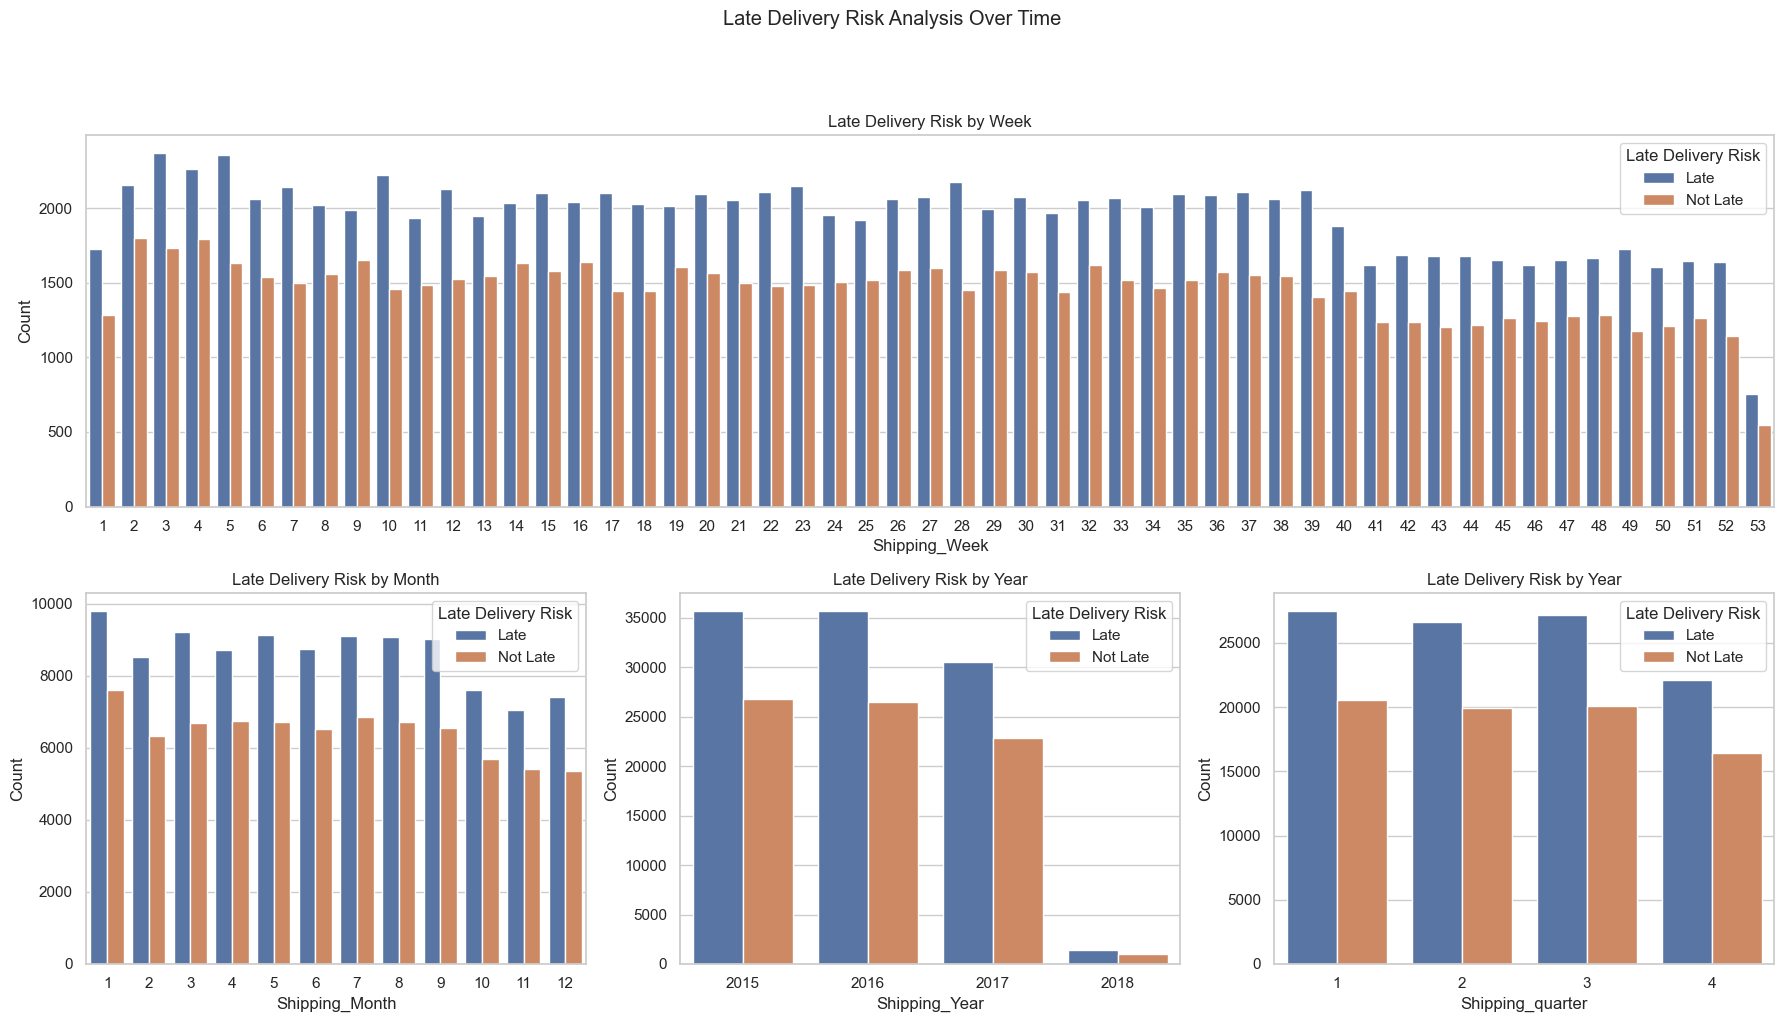

In [72]:
sns.set(style="whitegrid")

fig = plt.figure(figsize=(18, 10))
fig.suptitle('Late Delivery Risk Analysis Over Time', y=1.02)

# Late Delivery Risk by Week
sub1 = fig.add_subplot(2, 1, 1)
sns.countplot(x='shipping_week', hue='late_delivery_risk', data=merged_data, ax=sub1)
sub1.set_title('Late Delivery Risk by Week')
sub1.set_xlabel('Shipping_Week')
sub1.set_ylabel('Count')
sub1.legend(title='Late Delivery Risk')

# Late Delivery Risk by Month
sub2 = fig.add_subplot(2, 3, 4)
sns.countplot(x='shipping_month', hue='late_delivery_risk', data=merged_data, ax=sub2)
sub2.set_title('Late Delivery Risk by Month')
sub2.set_xlabel('Shipping_Month')
sub2.set_ylabel('Count')
sub2.legend(title='Late Delivery Risk')

# Late Delivery Risk by Year
sub3 = fig.add_subplot(2, 3, 5)
sns.countplot(x='shipping_year', hue='late_delivery_risk', data=merged_data, ax=sub3)
sub3.set_title('Late Delivery Risk by Year')
sub3.set_xlabel('Shipping_Year')
sub3.set_ylabel('Count')
sub3.legend(title='Late Delivery Risk')

# Late Delivery Risk by Quarter
sub4 = fig.add_subplot(2, 3, 6)
sns.countplot(x='shipping_quarter', hue='late_delivery_risk', data=merged_data, ax=sub4)
sub4.set_title('Late Delivery Risk by Year')
sub4.set_xlabel('Shipping_quarter')
sub4.set_ylabel('Count')
sub4.legend(title='Late Delivery Risk')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## 5. Order Item qty by time (by each week, month, year, quarter)

In [73]:
#Order Item qty by week
grp_week1 = merged_data.groupby("order_week")["order_item_quantity"].sum().reset_index()
grp_week1

order_week  order_item_quantity
0            1                 7064
1            2                 8200
2            3                 8672
3            4                 8540
4            5                 8186
5            6                 7812
6            7                 7878
7            8                 8163
8            9                 8089
9           10                 7951
10          11                 7846
11          12                 7672
12          13                 7973
13          14                 7979
14          15                 7940
15          16                 8247
16          17                 7452
17          18                 7715
18          19                 7738
19          20                 7792
20          21                 7653
21          22                 7999
22          23                 7491
23          24                 7204
24          25                 7920
25          26                 7654
26          27                 7950
27          28                 7765
28          29                 7948
29          30                 7540
30          31                 7748
31          32                 7653
32          33                 7760
33          34                 7672
34          35                 7968
35          36                 7753
36          37                 7793
37          38                 7650
38          39                 7886
39          40                 5682
40          41                 5951
41          42                 5810
42          43                 5762
43          44                 5761
44          45                 5822
45          46                 5821
46          47                 5934
47          48                 5773
48          49                 5813
49          50                 5670
50          51                 5779
51          52                 5938
52          53                 2647

In [74]:
#Order Item qty by month
grp_month1 = merged_data.groupby("order_month")["order_item_quantity"].sum().reset_index()
grp_month1

order_month  order_item_quantity
0             1                37179
1             2                32273
2             3                35087
3             4                33684
4             5                34538
5             6                32405
6             7                34543
7             8                34390
8             9                33152
9            10                26129
10           11                25011
11           12                25688

In [75]:
#Order Item qty by year
grp_year1 = merged_data.groupby("order_year")["order_item_quantity"].sum().reset_index()
grp_year1

order_year  order_item_quantity
0        2015               139615
1        2016               136548
2        2017               105793
3        2018                 2123

In [76]:
#Order Item qty by quarter
grp_quarter1 = merged_data.groupby("order_quarter")["order_item_quantity"].sum().reset_index()
grp_quarter1

order_quarter  order_item_quantity
0              1               104539
1              2               100627
2              3               102085
3              4                76828

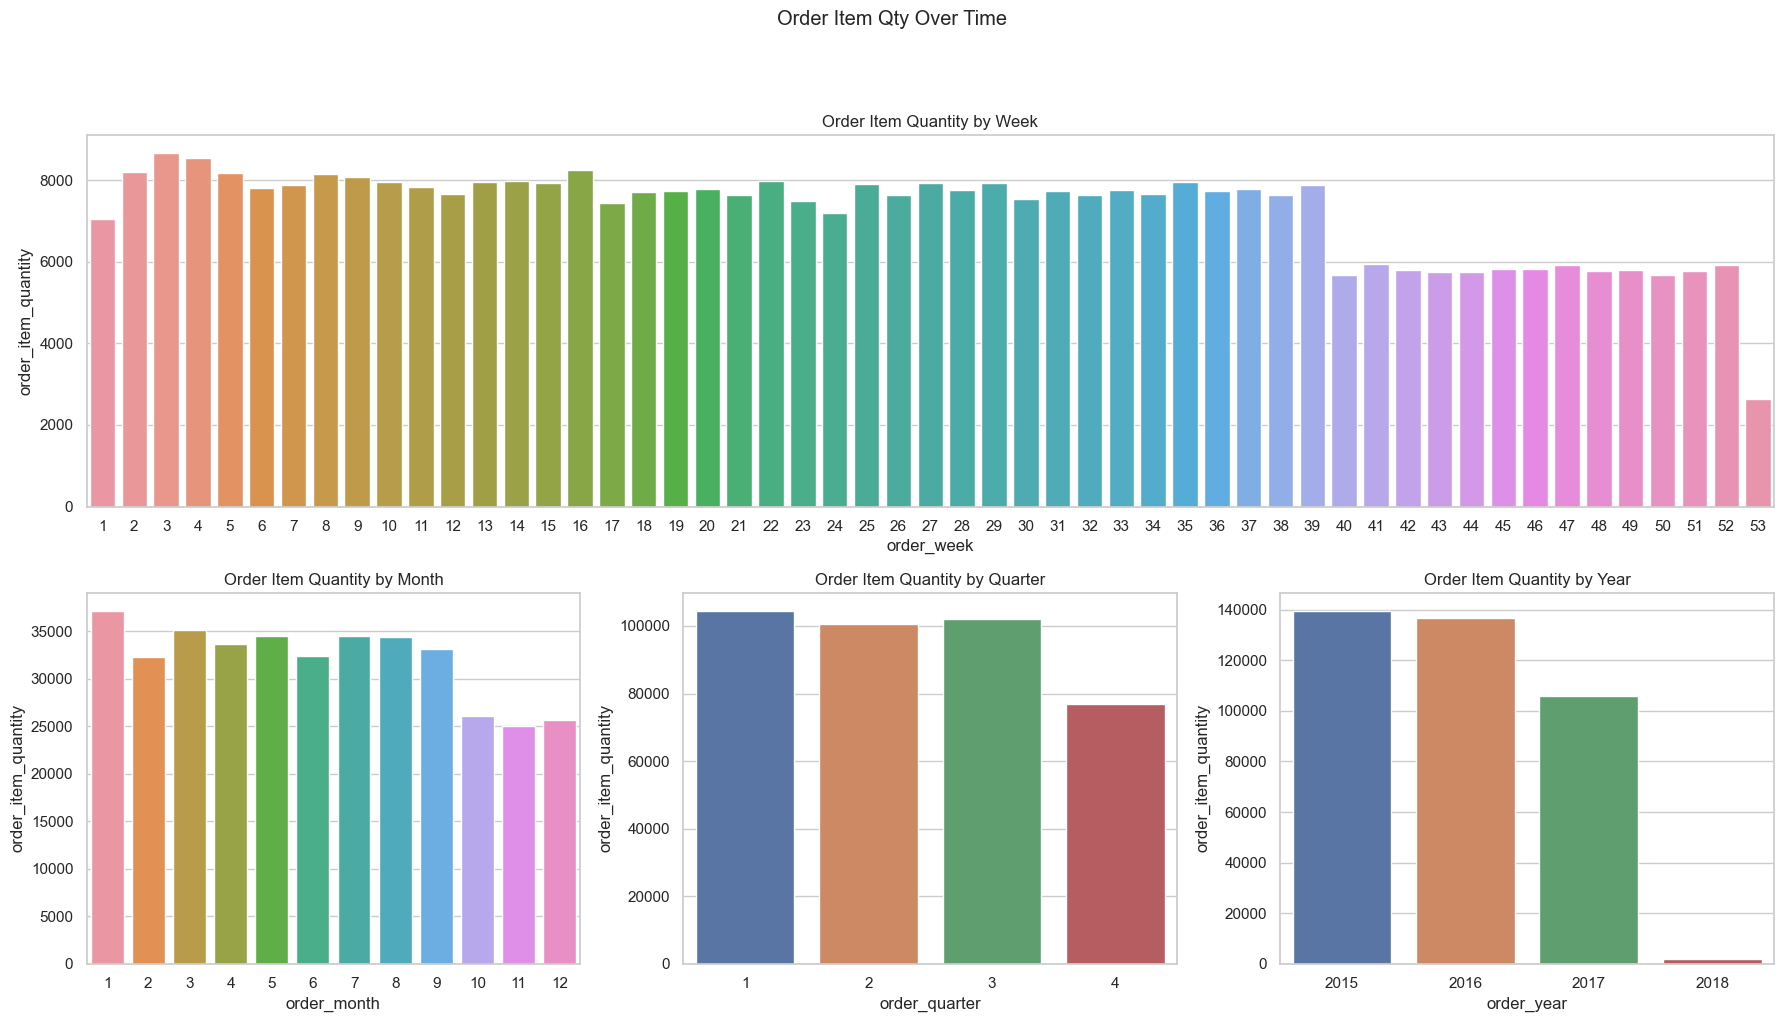

In [77]:
sns.set(style="whitegrid")

fig = plt.figure(figsize=(18, 10))
fig.suptitle('Order Item Qty Over Time', y=1.02)

# Order Item Quantity by Week
sub1 = fig.add_subplot(2, 1, 1)
sns.barplot(x='order_week', y='order_item_quantity',data=grp_week1, ax=sub1)
sub1.set_title('Order Item Quantity by Week')

# Order Item Quantity by Month
sub2 = fig.add_subplot(2, 3, 4)
sns.barplot(x='order_month', y='order_item_quantity', data=grp_month1, ax=sub2)
sub2.set_title('Order Item Quantity by Month')

# Order Item Quantity by Quarter
sub3 = fig.add_subplot(2, 3, 5)
sns.barplot(x='order_quarter', y='order_item_quantity', data=grp_quarter1, ax=sub3)
sub3.set_title('Order Item Quantity by Quarter')

# Order Item Quantity by Year
sub4 = fig.add_subplot(2, 3, 6)
sns.barplot(x='order_year', y='order_item_quantity', data=grp_year1, ax=sub4)
sub4.set_title('Order Item Quantity by Year')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## 6. Sales units/value  by time (by each week, month, year, quarter)

In [78]:
#Sales value/units  by week

su_week = merged_data.groupby("order_week").agg(sales_value = ("sales_per_customer","sum"),sales_units = ("sales_per_customer","count")).round(2).reset_index()
su_week

order_week  sales_value  sales_units
0            1    655859.97         3496
1            2    710854.23         4013
2            3    656670.80         4110
3            4    684038.98         4091
4            5    691914.07         3846
5            6    620778.55         3524
6            7    641404.05         3557
7            8    648790.31         3647
8            9    641717.82         3645
9           10    632403.96         3612
10          11    641220.79         3574
11          12    617793.52         3505
12          13    633330.46         3606
13          14    647937.32         3663
14          15    646638.52         3657
15          16    661724.17         3700
16          17    611362.01         3430
17          18    647229.98         3568
18          19    644482.12         3618
19          20    641815.14         3574
20          21    634047.46         3550
21          22    666150.40         3718
22          23    631777.73         3494
23          24    629275.74         3441
24          25    660824.30         3629
25          26    643805.25         3553
26          27    665571.02         3650
27          28    641696.28         3570
28          29    661611.17         3678
29          30    622095.69         3512
30          31    640480.03         3558
31          32    629244.74         3550
32          33    651853.04         3600
33          34    656375.92         3611
34          35    644634.97         3611
35          36    655938.30         3617
36          37    676432.42         3701
37          38    651178.41         3552
38          39    694356.53         3624
39          40    450220.85         2853
40          41    595032.89         2917
41          42    598228.20         2910
42          43    840037.01         2867
43          44    667632.39         2914
44          45    548059.97         2957
45          46    630667.70         2868
46          47    550705.56         2953
47          48    508689.06         2895
48          49    450190.57         2894
49          50    473030.33         2825
50          51    599931.78         2825
51          52    593941.80         2952
52          53    212718.20         1234

Text(0.5, 0, 'Weekly Sales Value')

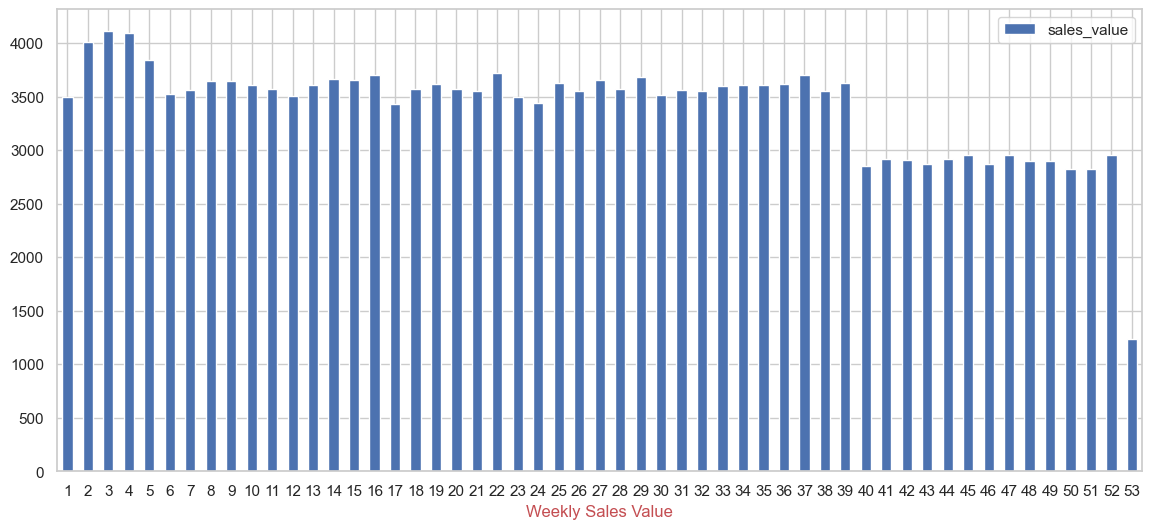

In [79]:
merged_data.groupby('order_week').agg(sales_value=('sales_per_customer', 'count')).plot(kind='bar',figsize=(14,6),color='b')
plt.xticks(rotation=0)
plt.xlabel('Weekly Sales Value',c='r',fontsize=12)

In [80]:
#Sales value/units by month

su_month = merged_data.groupby("order_month").agg(sales_value = ("sales_per_customer","sum"),sales_units = ("sales_per_customer","count")).round(2).reset_index()
su_month

order_month  sales_value  sales_units
0             1   3109090.46        17979
1             2   2595053.47        14529
2             3   2807828.27        15919
3             4   2744815.52        15435
4             5   2862117.04        15976
5             6   2749136.04        15139
6             7   2864576.62        15922
7             8   2864109.69        15912
8             9   2842005.73        15489
9            10   2851094.79        12955
10           11   2429193.40        12500
11           12   2335381.34        12764

Text(0.5, 0, 'Monthly Sales Value')

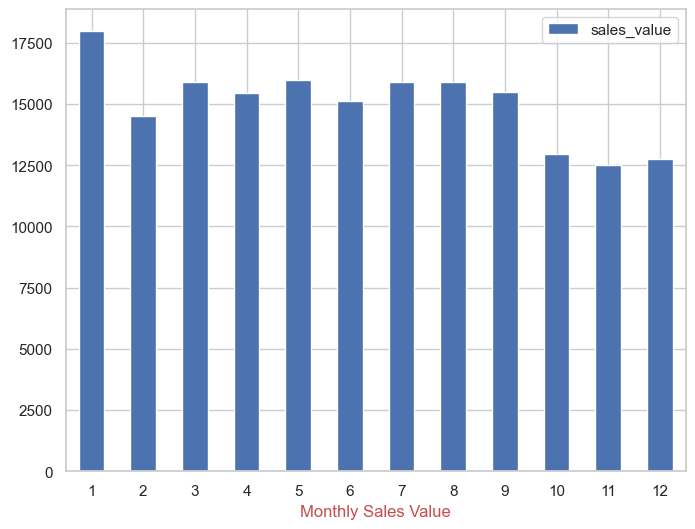

In [81]:
merged_data.groupby('order_month').agg(sales_value=('sales_per_customer', 'count')).plot(kind='bar',figsize=(8,6),color='b')
plt.xticks(rotation=0)
plt.xlabel('Monthly Sales Value',c='r',fontsize=12)

In [82]:
#Sales value/units  by year

su_year = merged_data.groupby("order_year").agg(sales_value = ("sales_per_customer","sum"),sales_units = ("sales_per_customer","count")).round(2).reset_index()
su_year

order_year  sales_value  sales_units
0        2015  11182390.18        63183
1        2016  10989577.73        62158
2        2017  10584482.41        53055
3        2018    297952.05         2123

Text(0.5, 0, 'Yearly Sales Value')

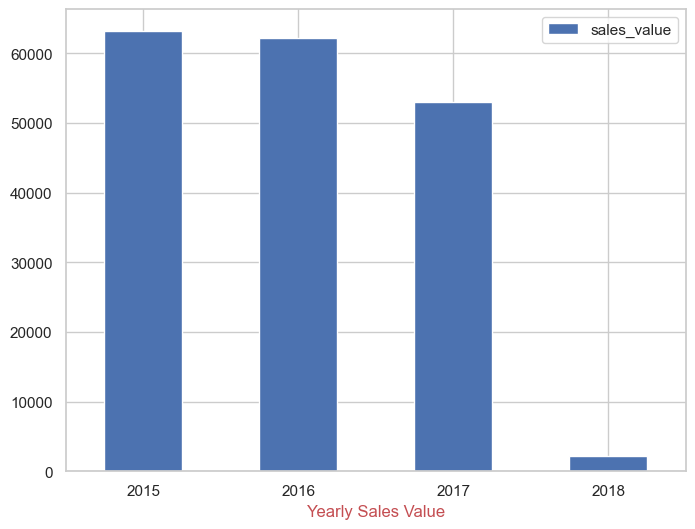

In [83]:
merged_data.groupby('order_year').agg(sales_value=('sales_per_customer', 'count')).plot(kind='bar',figsize=(8,6),color='b')
plt.xticks(rotation=0)
plt.xlabel('Yearly Sales Value',c='r',fontsize=12)

In [84]:
#Sales value/units  by quarter

su_quarter = merged_data.groupby("order_quarter").agg(sales_value = ("sales_per_customer","sum"),sales_units = ("sales_per_customer","count")).round(2).reset_index()
su_quarter

order_quarter  sales_value  sales_units
0              1   8511972.20        48427
1              2   8356068.60        46550
2              3   8570692.04        47323
3              4   7615669.53        38219

Text(0.5, 0, 'Quarterly Sales Value')

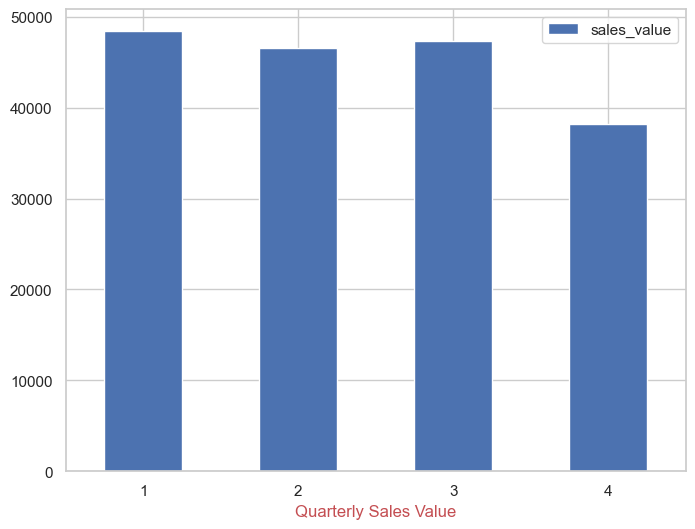

In [85]:
merged_data.groupby('order_quarter').agg(sales_value=('sales_per_customer', 'count')).plot(kind='bar',figsize=(8,6),color='b')
plt.xticks(rotation=0)
plt.xlabel('Quarterly Sales Value',c='r',fontsize=12)

## 7. Profit orders/value  by time (by each week, month, year, quarter)

In [86]:
profit_value = merged_data[merged_data["order_profit_per_order"] > 0]

In [87]:
# Profit orders/value  by week

prof_week = profit_value.groupby("order_week").agg(profit_value = ("order_profit_per_order","sum"),profit_order = ("order_profit_per_order","count")).round(2).reset_index()
prof_week

order_week  profit_value  profit_order
0            1     158400.80          2866
1            2     163125.11          3191
2            3     154267.91          3313
3            4     157614.23          3238
4            5     165525.83          3142
5            6     149270.63          2884
6            7     150721.43          2820
7            8     155596.90          2972
8            9     153210.48          2956
9           10     146098.41          2890
10          11     150270.63          2814
11          12     147137.77          2868
12          13     151763.69          2934
13          14     155736.56          2954
14          15     155424.20          2953
15          16     156796.58          2979
16          17     145694.69          2758
17          18     152804.06          2858
18          19     152078.89          2888
19          20     153448.42          2898
20          21     148120.14          2832
21          22     160689.35          3022
22          23     151418.27          2824
23          24     150764.34          2815
24          25     155626.26          2896
25          26     148648.19          2831
26          27     159528.55          2941
27          28     154675.89          2860
28          29     159921.60          2960
29          30     148150.82          2825
30          31     149850.02          2867
31          32     149717.76          2868
32          33     156252.97          2903
33          34     159215.44          2930
34          35     151703.94          2934
35          36     157403.22          2919
36          37     161056.18          3002
37          38     153486.39          2877
38          39     167711.31          2962
39          40     106346.16          2307
40          41     142199.02          2385
41          42     142460.57          2338
42          43     199693.96          2334
43          44     157169.44          2355
44          45     131125.76          2360
45          46     151661.11          2292
46          47     129105.14          2362
47          48     121202.59          2356
48          49     103989.97          2328
49          50     112224.30          2259
50          51     146617.38          2275
51          52     138035.59          2366
52          53      49691.47           997

In [88]:
# Profit orders/value  by month

prof_month = profit_value.groupby("order_month").agg(profit_value = ("order_profit_per_order","sum"),profit_order = ("order_profit_per_order","count")).round(2).reset_index()
prof_month

order_month  profit_value  profit_order
0             1     730886.02         14460
1             2     616900.18         11748
2             3     664400.31         12847
3             4     656347.32         12430
4             5     678696.41         12852
5             6     651543.01         12189
6             7     683976.14         12791
7             8     682843.42         12860
8             9     677439.87         12583
9            10     679589.37         10521
10           11     575038.21         10011
11           12     552790.06         10266

In [89]:
# Profit orders/value  by year

prof_year = profit_value.groupby("order_year").agg(profit_value = ("order_profit_per_order","sum"),profit_order = ("order_profit_per_order","count")).round(2).reset_index()
prof_year

order_year  profit_value  profit_order
0        2015    2655134.78         50950
1        2016    2604658.58         50027
2        2017    2520892.50         42883
3        2018      69764.46          1698

In [90]:
# Profit orders/value  by quarter

prof_quarter = profit_value.groupby("order_quarter").agg(profit_value = ("order_profit_per_order","sum"),profit_order = ("order_profit_per_order","count")).round(2).reset_index()
prof_quarter

order_quarter  profit_value  profit_order
0              1    2012186.51         39055
1              2    1986586.74         37471
2              3    2044259.43         38234
3              4    1807417.64         30798

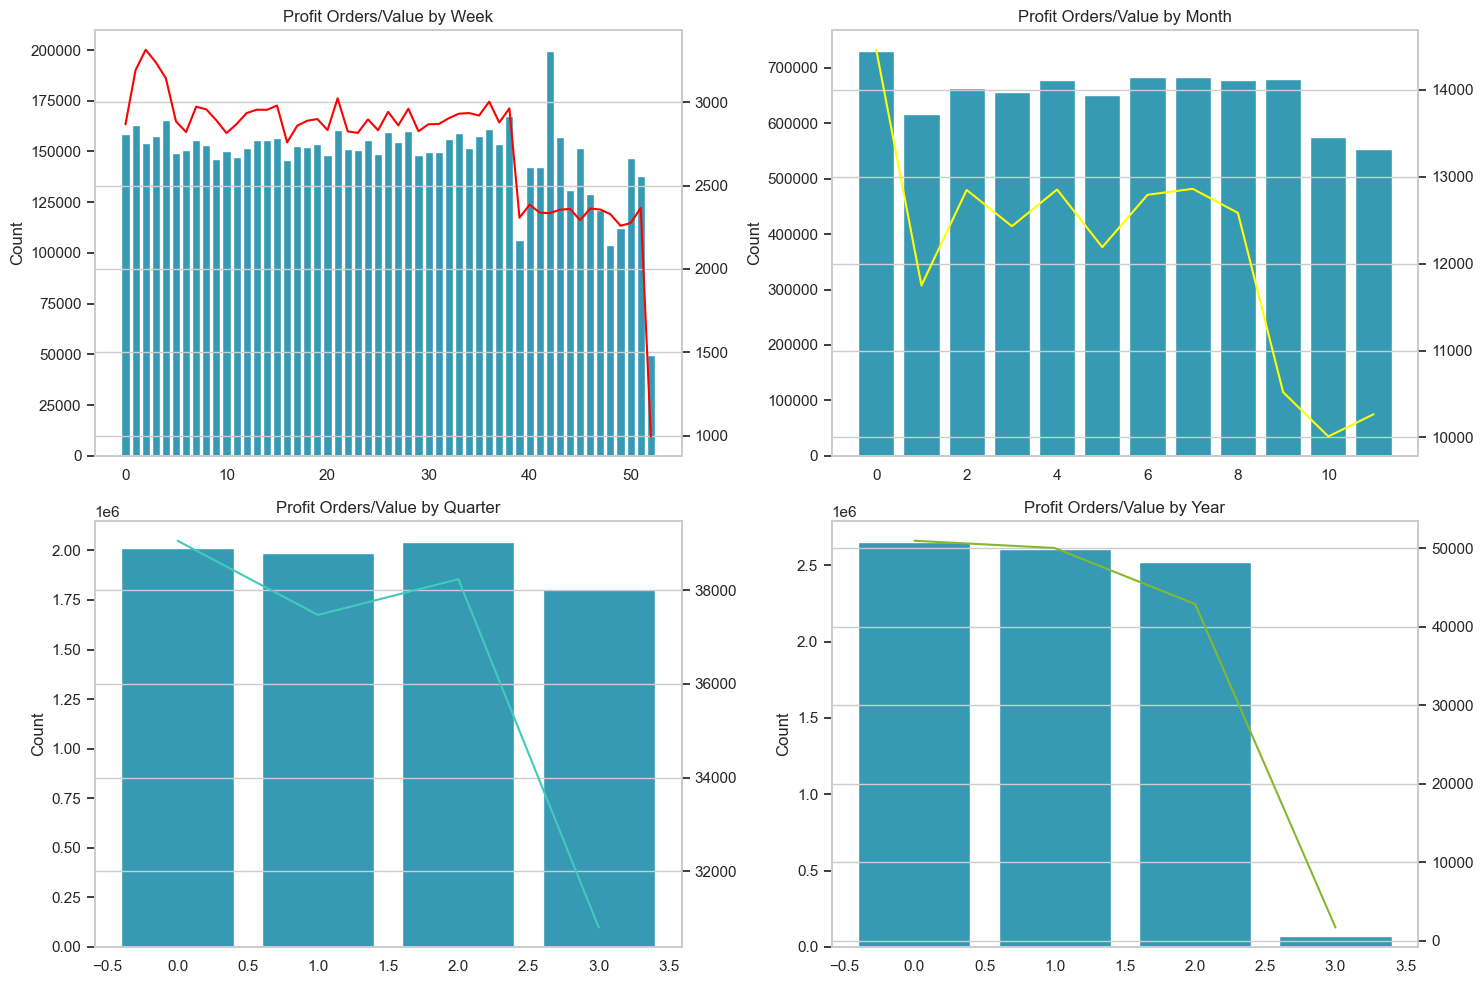

In [91]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Plot by Week
axes[0, 0].bar(prof_week.index, prof_week['profit_value'], label='Count', color='#369ab5')
axes[0, 0].set_ylabel('Count')
axes[0, 0].twinx().plot(prof_week.index, prof_week['profit_order'], 'red', label='Net Sales')
axes[0, 0].set_title('Profit Orders/Value by Week')
axes[0, 0].grid(False)

# Plot by Month
axes[0, 1].bar(prof_month.index, prof_month['profit_value'], label='Count',color='#369ab5')
axes[0, 1].set_ylabel('Count')
axes[0, 1].twinx().plot(prof_month.index, prof_month['profit_order'], 'yellow', label='Net Sales')
axes[0, 1].set_title('Profit Orders/Value by Month')
axes[0, 1].grid(False)

# Plot by Quarter
axes[1, 0].bar(prof_quarter.index, prof_quarter['profit_value'], label='Count', color='#369ab5')
axes[1, 0].set_ylabel('Count')
axes[1, 0].twinx().plot(prof_quarter.index, prof_quarter['profit_order'], '#3fccbc', label='Net Sales')
axes[1, 0].set_title('Profit Orders/Value by Quarter')
axes[1, 0].grid(False)

# Plot by Year
axes[1, 1].bar(prof_year.index, prof_year['profit_value'], label='Count',color='#369ab5')
axes[1, 1].set_ylabel('Count')
axes[1, 1].twinx().plot(prof_year.index, prof_year['profit_order'], '#84b830', label='Net Sales')
axes[1, 1].set_title('Profit Orders/Value by Year')
axes[1, 1].grid(False) 

plt.tight_layout()
plt.show()

## 8. Order profit per order  by time (by each week, month, year, quarter)

In [92]:
#Order profit per order  by week

oppo_week = merged_data.groupby("order_week")["order_profit_per_order"].sum().round(2).reset_index()
oppo_week

order_week  order_profit_per_order
0            1                92037.64
1            2                75680.46
2            3                74293.70
3            4                72440.37
4            5                84926.32
5            6                83214.70
6            7                61892.83
7            8                76089.98
8            9                82736.90
9           10                62933.53
10          11                65908.39
11          12                83286.94
12          13                84364.21
13          14                78000.74
14          15                78349.60
15          16                83686.78
16          17                77757.77
17          18                78697.73
18          19                71230.94
19          20                72615.73
20          21                72446.32
21          22                84864.53
22          23                81626.97
23          24                78518.71
24          25                77275.05
25          26                62823.93
26          27                81727.79
27          28                78156.15
28          29                87436.58
29          30                70621.88
30          31                80784.79
31          32                78665.19
32          33                84340.08
33          34                85682.77
34          35                76607.03
35          36                84160.63
36          37                84292.75
37          38                86229.12
38          39                86860.47
39          40                41711.78
40          41                71956.90
41          42                64889.16
42          43               102150.35
43          44                78974.19
44          45                65602.66
45          46                71229.76
46          47                64663.09
47          48                65695.65
48          49                50799.51
49          50                58408.42
50          51                76645.79
51          52                65165.36
52          53                25744.35

In [93]:
#Order profit per order  by month

oppo_month = merged_data.groupby("order_month")["order_profit_per_order"].sum().round(2).reset_index()
oppo_month

order_month  order_profit_per_order
0             1               367127.43
1             2               301061.22
2             3               333727.10
3             4               339021.36
4             5               337878.66
5             6               324742.52
6             7               348592.48
7             8               360210.47
8             9               359315.04
9            10               331987.01
10           11               281757.81
11           12               281481.87

In [94]:
#Order profit per order  by year

oppo_year = merged_data.groupby("order_year")["order_profit_per_order"].sum().round(2).reset_index()
oppo_year

order_year  order_profit_per_order
0        2015              1330701.48
1        2016              1300850.71
2        2017              1301508.89
3        2018                33841.89

In [95]:
#Order profit per order  by quarter

oppo_quarter = merged_data.groupby("order_quarter")["order_profit_per_order"].sum().round(2).reset_index()
oppo_quarter

order_quarter  order_profit_per_order
0              1              1001915.75
1              2              1001642.54
2              3              1068117.99
3              4               895226.69

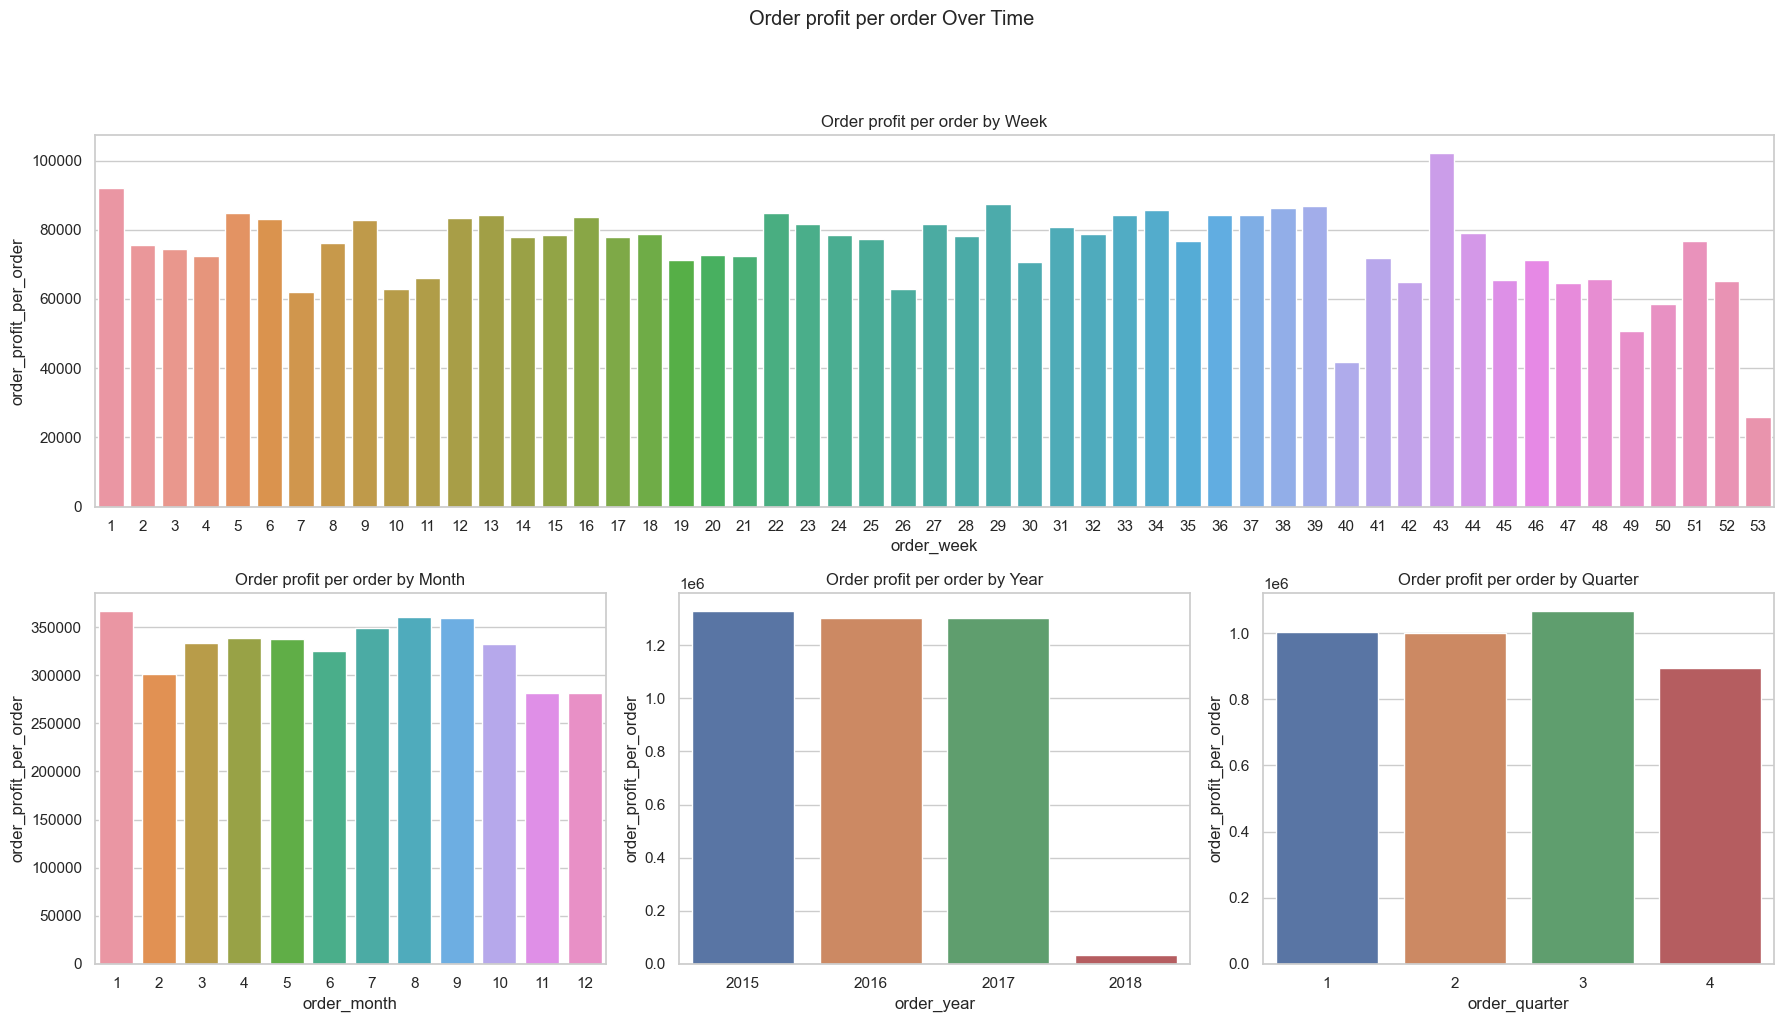

In [96]:
sns.set(style="whitegrid")

fig = plt.figure(figsize=(18, 10))
fig.suptitle('Order profit per order Over Time', y=1.02)

# Order profit per order by Week
sub1 = fig.add_subplot(2, 1, 1)
sns.barplot(x='order_week', y='order_profit_per_order', data=oppo_week, ax=sub1)
sub1.set_title('Order profit per order by Week')

# Order profit per order by Month
sub1 = fig.add_subplot(2, 3, 4)
sns.barplot(x='order_month', y='order_profit_per_order', data=oppo_month, ax=sub1)
sub1.set_title('Order profit per order by Month')

# Order profit per order by Year
sub3 = fig.add_subplot(2, 3, 5)
sns.barplot(x='order_year', y='order_profit_per_order', data=oppo_year, ax=sub3)
sub3.set_title('Order profit per order by Year')

# Order profit per order by Quarter
sub4 = fig.add_subplot(2, 3, 6)
sns.barplot(x='order_quarter', y='order_profit_per_order', data=oppo_quarter, ax=sub4)
sub4.set_title('Order profit per order by Quarter')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## 9. Order count by country/state/  by time (by each week, month, year, quarter)

In [97]:
#Order count by country/state/  by week

oc_week = merged_data.groupby(["order_state","order_country","order_week"]).agg(order_count = ("order_id","count")).reset_index()
oc_week

order_state                    order_country  order_week  \
0                Abia                          Nigeria          34   
1                Abia                          Nigeria          35   
2                Abia                          Nigeria          38   
3                Abia                          Nigeria          40   
4                Abia                          Nigeria          42   
...               ...                              ...         ...   
10184        Équateur  República Democrática del Congo          41   
10185        Équateur  República Democrática del Congo          42   
10186        Équateur  República Democrática del Congo          45   
10187  Ústí nad Labem                  República Checa           2   
10188  Ústí nad Labem                  República Checa          36   

       order_count  
0                1  
1                8  
2                1  
3               11  
4                4  
...            ...  
10184            3  
10185            4  
10186           36  
10187           10  
10188            4  

[10189 rows x 4 columns]

In [98]:
#Order count by country/state/  by month

oc_month = merged_data.groupby(["order_state","order_country","order_month"]).agg(order_count = ("order_id","count")).reset_index()
oc_month

order_state                    order_country  order_month  \
0               Abia                          Nigeria            8   
1               Abia                          Nigeria            9   
2               Abia                          Nigeria           10   
3               Abia                          Nigeria           12   
4            Abruzos                           Italia            6   
...              ...                              ...          ...   
4274        Équateur  República Democrática del Congo            9   
4275        Équateur  República Democrática del Congo           10   
4276        Équateur  República Democrática del Congo           11   
4277  Ústí nad Labem                  República Checa            1   
4278  Ústí nad Labem                  República Checa            9   

      order_count  
0               9  
1               1  
2              15  
3              11  
4               9  
...           ...  
4274            4  
4275            7  
4276           36  
4277           10  
4278            4  

[4279 rows x 4 columns]

In [99]:
#Order count by country/state/  by year

oc_year = merged_data.groupby(["order_state","order_country","order_year"]).agg(order_count = ("order_id","count")).reset_index()
oc_year

order_state                    order_country  order_year  order_count
0               Abia                          Nigeria        2016           36
1            Abruzos                           Italia        2015           34
2            Abruzos                           Italia        2017           27
3               Aceh                        Indonesia        2015            3
4               Aceh                        Indonesia        2016           13
...              ...                              ...         ...          ...
2100          ilina                       Eslovaquia        2016            5
2101       Çanakkale                          Turquía        2016            6
2102        Équateur  República Democrática del Congo        2016           47
2103  Ústí nad Labem                  República Checa        2016            4
2104  Ústí nad Labem                  República Checa        2017           10

[2105 rows x 4 columns]

In [100]:
#Order count by country/state/  by quarter

oc_quarter = merged_data.groupby(["order_state","order_country","order_quarter"]).agg(order_count = ("order_id","count")).reset_index()
oc_quarter

order_state                    order_country  order_quarter  \
0               Abia                          Nigeria              3   
1               Abia                          Nigeria              4   
2            Abruzos                           Italia              2   
3            Abruzos                           Italia              3   
4            Abruzos                           Italia              4   
...              ...                              ...            ...   
2227       Çanakkale                          Turquía              3   
2228        Équateur  República Democrática del Congo              3   
2229        Équateur  República Democrática del Congo              4   
2230  Ústí nad Labem                  República Checa              1   
2231  Ústí nad Labem                  República Checa              3   

      order_count  
0              10  
1              26  
2               9  
3              46  
4               6  
...           ...  
2227            6  
2228            4  
2229           43  
2230           10  
2231            4  

[2232 rows x 4 columns]

## 10. Inventory Units by each class or cluster

In [101]:
merged_data.groupby("class").agg(inventory_units=("current_stock","sum")).reset_index()

class  inventory_units
0         High Value-Small Number         13399842
1  Moderate Value-Moderate Number          6059123
2        Small Value-Large Number         10919162

## 11. Inventory Value by each class or cluster

In [102]:
merged_data['inventory_value']=merged_data['order_item_product_price']*merged_data['current_stock']

In [103]:
merged_data.groupby("class").agg(inventory_values = ("inventory_value","sum")).reset_index()

class  inventory_values
0         High Value-Small Number      1.387021e+09
1  Moderate Value-Moderate Number      5.615272e+08
2        Small Value-Large Number      5.876127e+08

## 12. inventory by class

In [104]:
merged_data.groupby("class").agg(inventory = ("current_stock","sum")).reset_index()

class  inventory
0         High Value-Small Number   13399842
1  Moderate Value-Moderate Number    6059123
2        Small Value-Large Number   10919162

## 13. Detail Stock Action (products to be ordered, not required to ordered)

In [105]:
merged_data["stock_action"] = "Not Required"
merged_data.loc[merged_data["current_stock"] <= merged_data["reorder_point"],"stock_action"] = "To Be Ordered"
stock_action = merged_data.groupby(["product_id","current_stock"])["stock_action"].value_counts().unstack()
stock_action = stock_action.fillna(0)
stock_action

stock_action              Not Required  To Be Ordered
product_id current_stock                             
19         69                     64.0            0.0
24         175                     0.0           74.0
35         65                     65.0            0.0
37         328                   262.0            0.0
44         175                     0.0          305.0
...                                ...            ...
1359       69                    492.0            0.0
1360       35                      0.0          357.0
1361       61                    529.0            0.0
1362       35                      0.0          838.0
1363       63                    650.0            0.0

[118 rows x 2 columns]

In [106]:
InvStock['stock_action']= InvStock['order-now'].apply(lambda x: 'not required to order' if x == 'green' else 'product to be ordered')

In [107]:
InvStock.head()

order-now  product_id                                product_name  \
0     green          19     Nike Men's Fingertrap Max Training Shoe   
1    orange          24                 Elevation Training Mask 2.0   
2     green          35     adidas Brazuca 2014 Official Match Ball   
3     green          37       adidas Kids' F5 Messi FG Soccer Cleat   
4    orange          44  adidas Men's F10 Messi TRX FG Soccer Cleat   

   avg_lead_time  avg_order_qty  current_stock  max_lead_time  max_order_qty  \
0             10              1             69             30              1   
1             10              3            175             30              5   
2             10              1             65             30              1   
3             10              3            328             30              5   
4             10              3            175             30              5   

   mod  reorder_point  safety_stock           stock_action  
0    1             35            25  not required to order  
1    0            175           144  product to be ordered  
2    1             35            25  not required to order  
3    1            175           146  not required to order  
4    0            175           145  product to be ordered

## 14. Product Order qty trend  (by time (by each week, month, year, quarter))

In [108]:
#Product Order quantity trend by week

poq_weeks = merged_data.groupby(["order_week","product_id","product_name"]).agg(order_qty = ("order_item_quantity","sum")).reset_index()
poq_weeks

order_week  product_id                                   product_name  \
0              1          37          adidas Kids' F5 Messi FG Soccer Cleat   
1              1          44     adidas Men's F10 Messi TRX FG Soccer Cleat   
2              1          93             Under Armour Men's Tech II T-Shirt   
3              1         116                     Nike Men's Comfort 2 Slide   
4              1         134             Nike Women's Legend V-Neck T-Shirt   
...          ...         ...                                            ...   
3594          53         957  Diamondback Women's Serene Classic Comfort Bi   
3595          53         977                       ENO Atlas Hammock Straps   
3596          53        1004      Field & Stream Sportsman 16 Gun Fire Safe   
3597          53        1014               O'Brien Men's Neoprene Life Vest   
3598          53        1073                    Pelican Sunstream 100 Kayak   

      order_qty  
0            14  
1            11  
2            15  
3            22  
4            27  
...         ...  
3594        108  
3595          9  
3596        110  
3597        426  
3598        102  

[3599 rows x 4 columns]

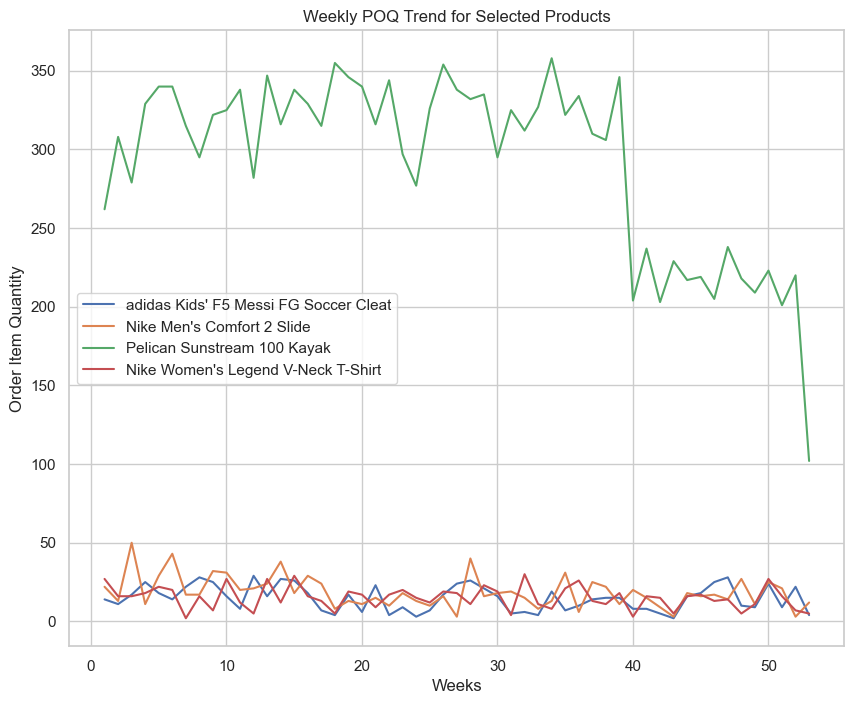

In [109]:
weekly_data = poq_weeks.copy()

products_to_plot = ["adidas Kids' F5 Messi FG Soccer Cleat", "Nike Men's Comfort 2 Slide", "Pelican Sunstream 100 Kayak",
                   "Nike Women's Legend V-Neck T-Shirt"]

plt.figure(figsize=(10, 8))
for product in products_to_plot:
    filtered_data = weekly_data[weekly_data["product_name"] == product]
    plt.plot(filtered_data["order_week"], filtered_data["order_qty"], label=product)

plt.xlabel("Weeks")
plt.ylabel("Order Item Quantity")
plt.title("Weekly POQ Trend for Selected Products")
plt.legend()
plt.show()

In [110]:
#Product Order quantity trend by months

poq_months = merged_data.groupby(["order_month","product_id","product_name"]).agg(order_qty = ("order_item_quantity","sum")).reset_index()
poq_months

order_month  product_id                                product_name  \
0              1          37       adidas Kids' F5 Messi FG Soccer Cleat   
1              1          44  adidas Men's F10 Messi TRX FG Soccer Cleat   
2              1          93          Under Armour Men's Tech II T-Shirt   
3              1         116                  Nike Men's Comfort 2 Slide   
4              1         134          Nike Women's Legend V-Neck T-Shirt   
..           ...         ...                                         ...   
895           12        1359                          Adult dog supplies   
896           12        1360                                 Smart watch   
897           12        1361                                        Toys   
898           12        1362                        Fighting video games   
899           12        1363                              Summer dresses   

     order_qty  
0           77  
1          101  
2           93  
3          120  
4           91  
..         ...  
895        119  
896        145  
897        253  
898        228  
899        272  

[900 rows x 4 columns]

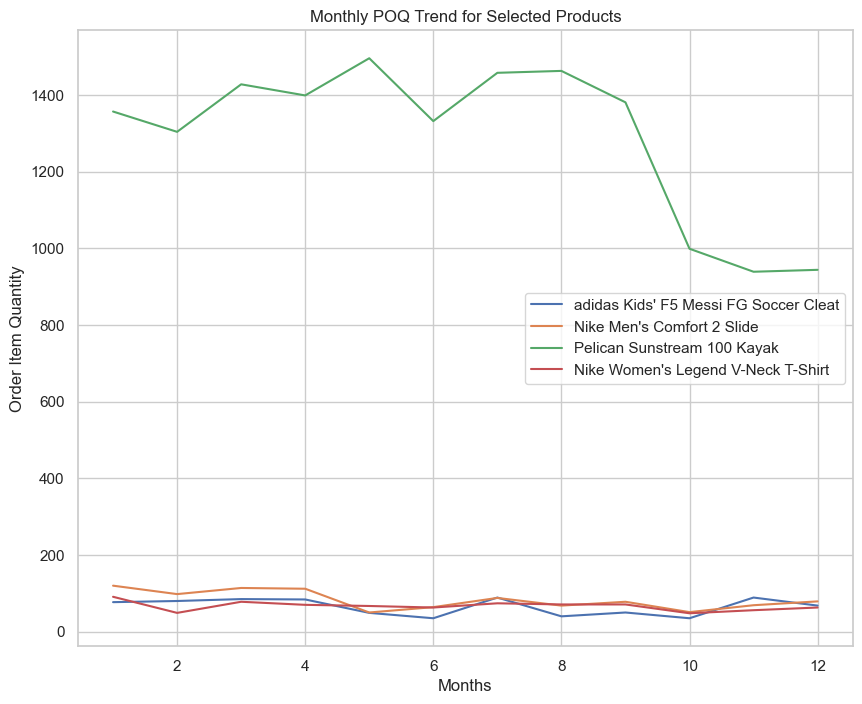

In [111]:
monthly_data = poq_months.copy()

products_to_plot = ["adidas Kids' F5 Messi FG Soccer Cleat", "Nike Men's Comfort 2 Slide", "Pelican Sunstream 100 Kayak",
                   "Nike Women's Legend V-Neck T-Shirt"]

plt.figure(figsize=(10, 8))
for product in products_to_plot:
    filtered_data = monthly_data[monthly_data["product_name"] == product]
    plt.plot(filtered_data["order_month"], filtered_data["order_qty"], label=product)

plt.xlabel("Months")
plt.ylabel("Order Item Quantity")
plt.title("Monthly POQ Trend for Selected Products")
plt.legend()
plt.show()

In [112]:
#Product Order quantity trend by year

poq_years = merged_data.groupby(["order_year","product_id","product_name"]).agg(order_qty = ("order_item_quantity","sum")).reset_index()
poq_years

order_year  product_id                                product_name  \
0          2015          37       adidas Kids' F5 Messi FG Soccer Cleat   
1          2015          44  adidas Men's F10 Messi TRX FG Soccer Cleat   
2          2015          93          Under Armour Men's Tech II T-Shirt   
3          2015         116                  Nike Men's Comfort 2 Slide   
4          2015         134          Nike Women's Legend V-Neck T-Shirt   
..          ...         ...                                         ...   
231        2018        1359                          Adult dog supplies   
232        2018        1360                                 Smart watch   
233        2018        1361                                        Toys   
234        2018        1362                        Fighting video games   
235        2018        1363                              Summer dresses   

     order_qty  
0          305  
1          406  
2          348  
3          422  
4          384  
..         ...  
231        246  
232        212  
233        276  
234        610  
235        378  

[236 rows x 4 columns]

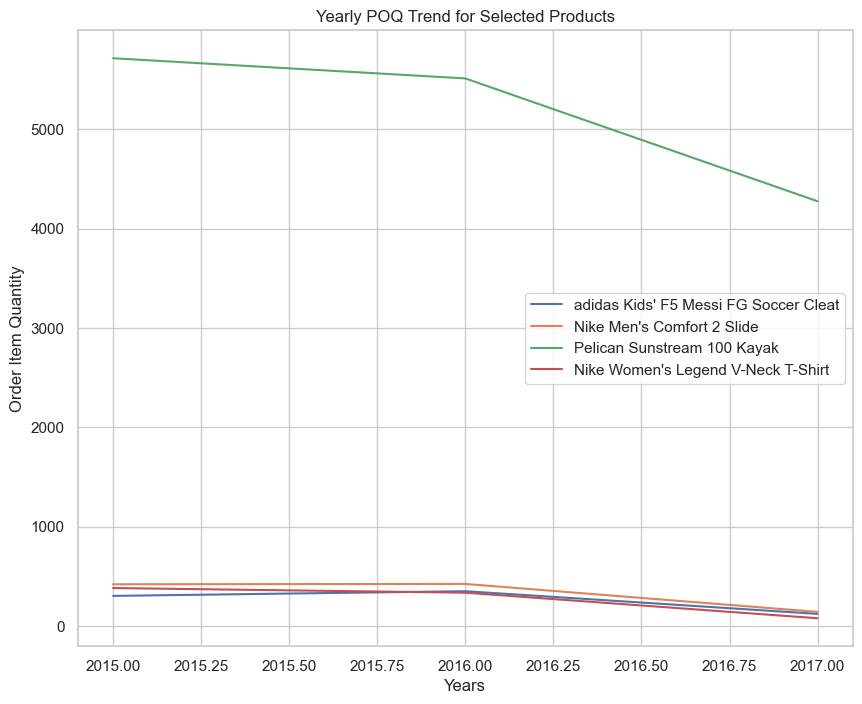

In [113]:
yearly_data = poq_years.copy()

products_to_plot = ["adidas Kids' F5 Messi FG Soccer Cleat", "Nike Men's Comfort 2 Slide", "Pelican Sunstream 100 Kayak",
                   "Nike Women's Legend V-Neck T-Shirt"]

plt.figure(figsize=(10, 8))
for product in products_to_plot:
    filtered_data = yearly_data[yearly_data["product_name"] == product]
    plt.plot(filtered_data["order_year"], filtered_data["order_qty"], label=product)

plt.xlabel("Years")
plt.ylabel("Order Item Quantity")
plt.title("Yearly POQ Trend for Selected Products")
plt.legend()
plt.show()

In [114]:
#Product Order quantity trend by Quarters

poq_quarters = merged_data.groupby(["order_quarter","product_id","product_name"]).agg(order_qty = ("order_item_quantity","sum")).reset_index()
poq_quarters

order_quarter  product_id                                product_name  \
0                1          37       adidas Kids' F5 Messi FG Soccer Cleat   
1                1          44  adidas Men's F10 Messi TRX FG Soccer Cleat   
2                1          93          Under Armour Men's Tech II T-Shirt   
3                1         116                  Nike Men's Comfort 2 Slide   
4                1         134          Nike Women's Legend V-Neck T-Shirt   
..             ...         ...                                         ...   
322              4        1359                          Adult dog supplies   
323              4        1360                                 Smart watch   
324              4        1361                                        Toys   
325              4        1362                        Fighting video games   
326              4        1363                              Summer dresses   

     order_qty  
0          242  
1          310  
2          284  
3          332  
4          218  
..         ...  
322        246  
323        145  
324        253  
325        228  
326        272  

[327 rows x 4 columns]

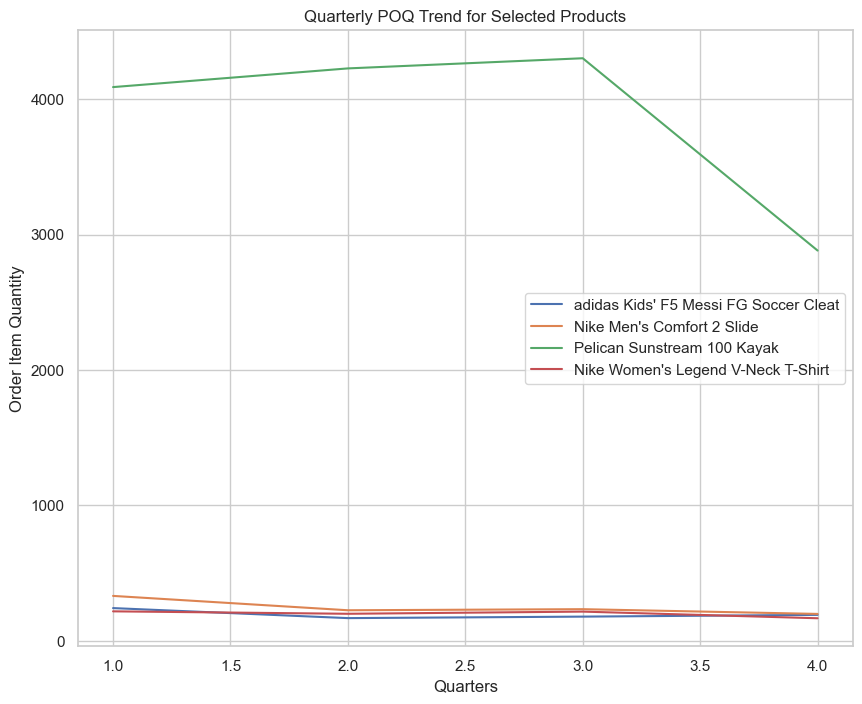

In [115]:
quarterly_data = poq_quarters.copy()

products_to_plot = ["adidas Kids' F5 Messi FG Soccer Cleat", "Nike Men's Comfort 2 Slide", "Pelican Sunstream 100 Kayak",
                   "Nike Women's Legend V-Neck T-Shirt"]

plt.figure(figsize=(10, 8))
for product in products_to_plot:
    filtered_data = quarterly_data[quarterly_data["product_name"] == product]
    plt.plot(filtered_data["order_quarter"], filtered_data["order_qty"], label=product)

plt.xlabel("Quarters")
plt.ylabel("Order Item Quantity")
plt.title("Quarterly POQ Trend for Selected Products")
plt.legend()
plt.show()

## 15. Top 10 Most ordered products/Top 10 Most Categories/Top 10 cities interms of revenue and sale units (quantity)

In [116]:
#Top 10 Most ordered products

top10_ordered_product = merged_data.groupby(["product_id","product_name"]).agg(total_sales = ("order_item_quantity","sum")).round(2).reset_index()
top10_ordered_product = top10_ordered_product.sort_values(by = "total_sales",ascending = False).head(10)
top10_ordered_product

product_id                                   product_name  total_sales
35         365               Perfect Fitness Perfect Rip Deck        73698
37         502           Nike Men's Dri-FIT Victory Golf Polo        62956
97        1014               O'Brien Men's Neoprene Life Vest        57803
15         191              Nike Men's Free 5.0+ Running Shoe        36680
44         627  Under Armour Girls' Toddler Spine Surge Runni        31735
36         403        Nike Men's CJ Elite 2 TD Football Cleat        22246
96        1004      Field & Stream Sportsman 16 Gun Fire Safe        17325
99        1073                    Pelican Sunstream 100 Kayak        15500
92         957  Diamondback Women's Serene Classic Comfort Bi        13729
93         977                       ENO Atlas Hammock Straps          998

Text(0.5, 0, ' ')

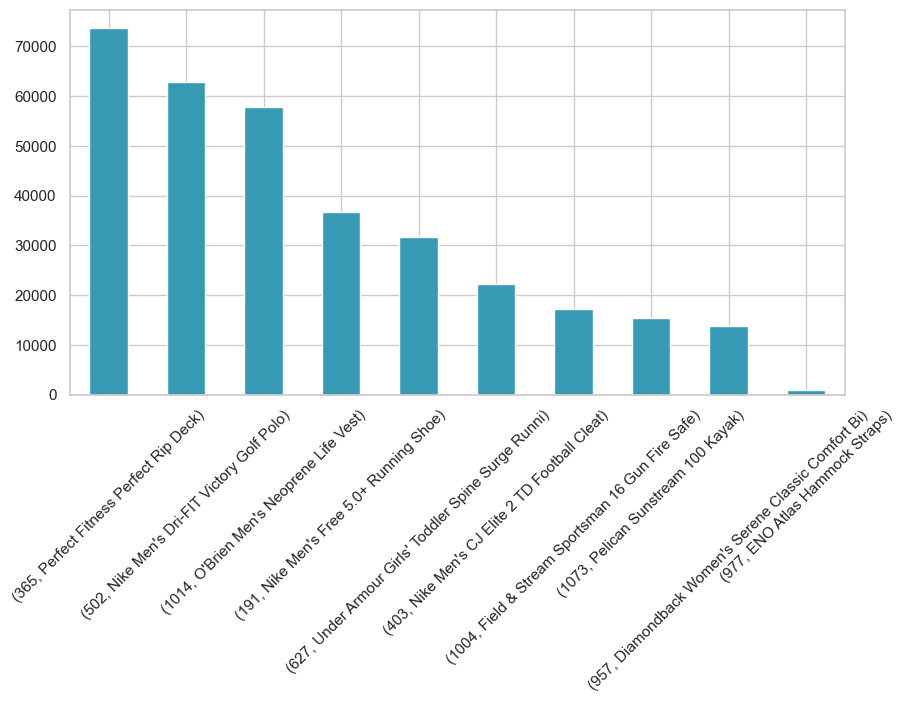

In [117]:
merged_data.groupby(['product_id', 'product_name'])['order_item_quantity'].sum().nlargest(10).plot(kind='bar',figsize=(10,5),color='#369ab5')
plt.xticks(rotation=45)
plt.xlabel(' ')

Text(0.5, 0, ' ')

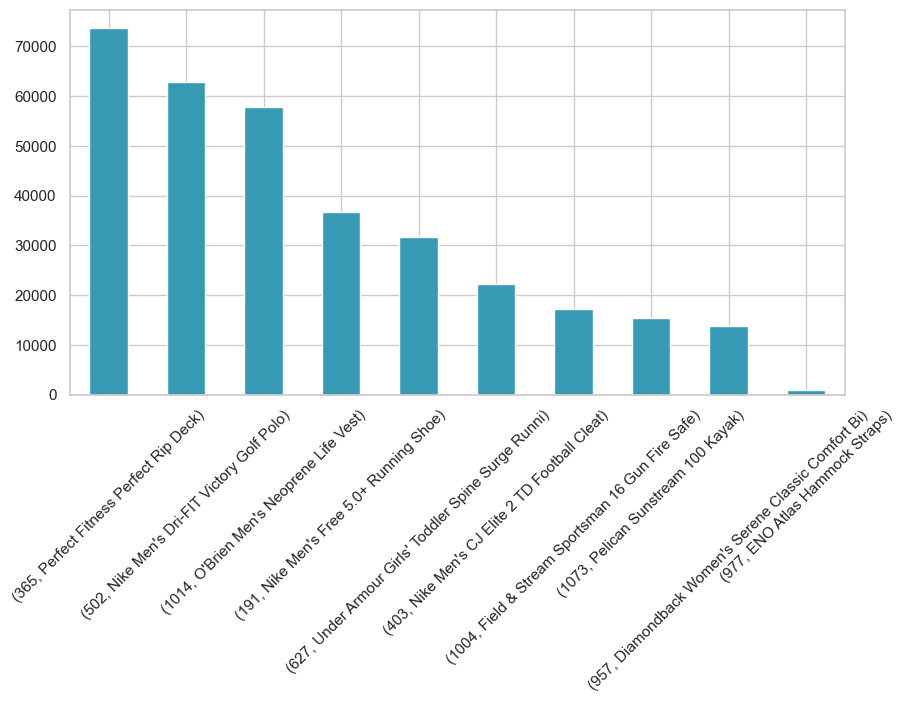

In [118]:
merged_data.groupby(['product_id', 'product_name'])['order_item_quantity'].sum().nlargest(10).plot(kind='bar',figsize=(10,5),color='#369ab5')
plt.xticks(rotation=45)
plt.xlabel(' ')

In [119]:
#Top 10 Most Categories
top10_Most_Categories =merged_data.groupby(["product_category_id","category_name"]).agg(total_sales = ("order_item_quantity","sum")).round(2).reset_index()
top10_Most_Categories = top10_Most_Categories.sort_values(by = "total_sales",ascending = False).head(10)
top10_Most_Categories

product_category_id         category_name  total_sales
12                   17                Cleats        73734
14                   24       Women's Apparel        62956
31                   46  Indoor/Outdoor Games        57803
6                     9      Cardio Equipment        37587
16                   29         Shop By Sport        32726
13                   18        Men's Footwear        22246
30                   45               Fishing        17325
32                   48          Water Sports        15540
28                   43      Camping & Hiking        13729
24                   37           Electronics         6061

Text(0.5, 0, '')

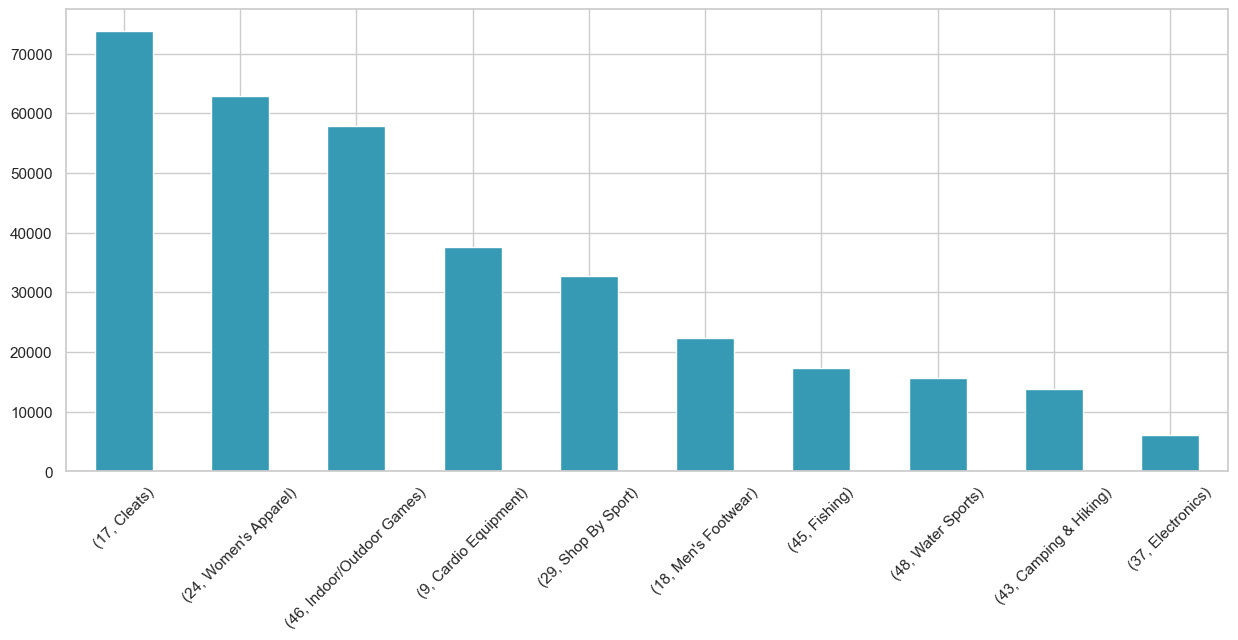

In [120]:
merged_data.groupby(['product_category_id', 'category_name'])['order_item_quantity'].sum().nlargest(10).plot(kind='bar',figsize=(15,6),color='#369ab5')
plt.xticks(rotation=45)
plt.xlabel('')

In [121]:
#Top 10 cities interms of revenue and sale units (quantity)

#Top 10 cities interms of revenue

top10_cities_revenue = merged_data.groupby(["order_city"]).agg(total_sales = ("sales_per_customer","sum")).round(2).reset_index()
top10_cities_revenue = top10_cities_revenue.sort_values(by = "total_sales",ascending = False).head(10)
top10_cities_revenue

order_city  total_sales
2256  New York City    392595.13
2872  Santo Domingo    388453.54
1876    Los Angeles    332631.26
3139    Tegucigalpa    328049.03
1958        Managua    301402.34
2075    Mexico City    267269.47
1964         Manila    245027.59
2806  San Francisco    229830.57
1861         London    229786.68
2469   Philadelphia    229544.08

Text(0.5, 0, '')

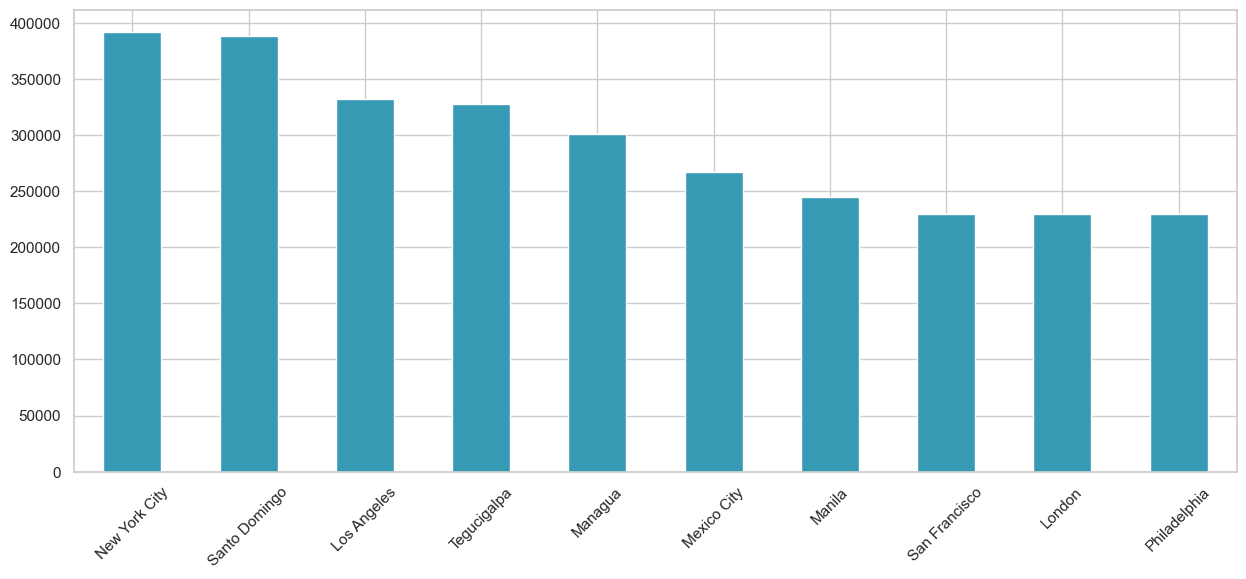

In [122]:
merged_data.groupby(['order_city'])['sales_per_customer'].sum().nlargest(10).plot(kind='bar',figsize=(15,6),color='#369ab5')
plt.xticks(rotation=45)
plt.xlabel('')

In [123]:
#Top 10 cities interms of sale units (quantity)

top10_sale_units_cities_qty = merged_data.groupby(["order_city"])["order_item_quantity"].sum().round(2).reset_index()
top10_sale_units_cities_qty = top10_sale_units_cities_qty.sort_values(by = "order_item_quantity",ascending = False).head(10)
top10_sale_units_cities_qty

order_city  order_item_quantity
2872  Santo Domingo                 4899
2256  New York City                 4877
1876    Los Angeles                 4068
3139    Tegucigalpa                 3913
1958        Managua                 3809
2075    Mexico City                 3258
2469   Philadelphia                 2880
1964         Manila                 2767
2806  San Francisco                 2753
2835   San Salvador                 2510

Text(0.5, 0, '')

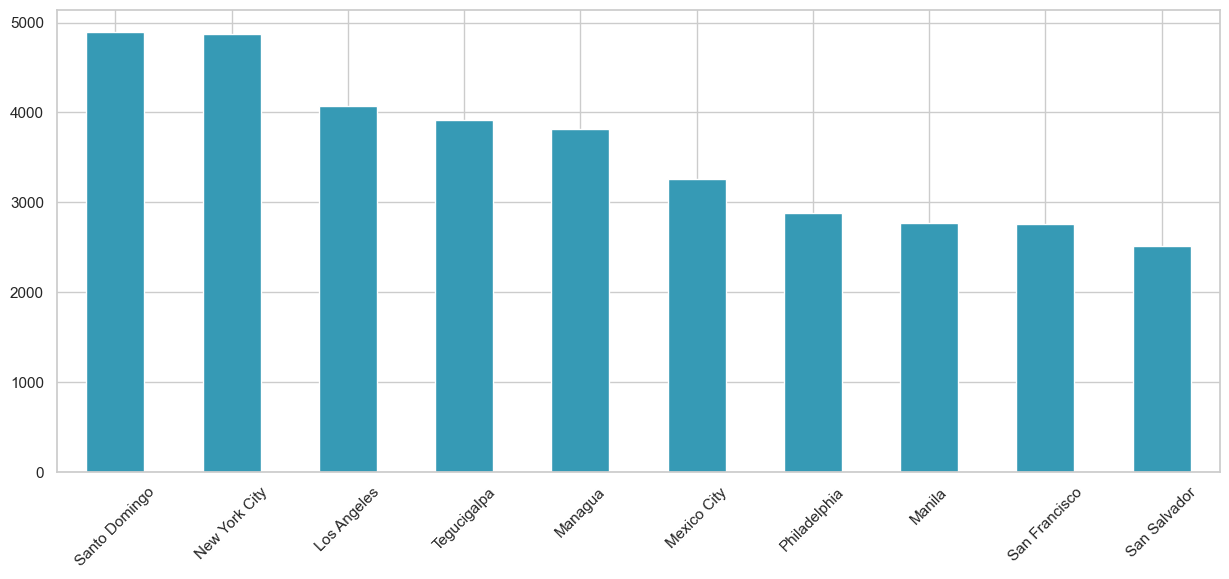

In [124]:
merged_data.groupby(['order_city'])['order_item_quantity'].sum().nlargest(10).plot(kind='bar',figsize=(15,6),color='#369ab5')
plt.xticks(rotation=45)
plt.xlabel('')

## 16. Top payment methods by each product category.

In [125]:
merged_data.groupby(['category_name', 'type']).size().reset_index(name='count').sort_values(by=['count'],ascending=False).head(10)

category_name      type  count
49                 Cleats     DEBIT   9450
137        Men's Footwear     DEBIT   8589
189       Women's Apparel     DEBIT   8199
121  Indoor/Outdoor Games     DEBIT   7436
51                 Cleats  TRANSFER   6827
73                Fishing     DEBIT   6588
139        Men's Footwear  TRANSFER   6150
185          Water Sports     DEBIT   5835
191       Women's Apparel  TRANSFER   5693
50                 Cleats   PAYMENT   5675

## 17. Which shipping mode is more efficient interms of not delaying?

In [126]:
on_time = merged_data[merged_data["late_delivery_risk"] == "Not Late"]
on_time_counts = on_time.groupby("shipping_mode").size()
on_time_count = on_time_counts.idxmax()
print(f"The Most Efficient Shipping Mode is '{on_time_count}' with {on_time_counts.max()} On-Time Deliveries.")

The Most Efficient Shipping Mode is 'Standard Class' with 64901 On-Time Deliveries.


## 18. Number of orders, sales, qty  by order status

In [127]:
merged_data.groupby('order_status').agg(orders=('order_id', 'count'),total_sales=('sales', 'sum'),total_quantity=('order_item_quantity', 'sum')).reset_index()

order_status  orders   total_sales  total_quantity
0         Canceled    3692  7.443704e+05            7875
1           Closed   19616  4.022624e+06           41458
2         Complete   59491  1.209531e+07          126624
3          On Hold    9804  1.981543e+06           20845
4   Payment Review    1893  3.836537e+05            4109
5          Pending   20227  4.120533e+06           43196
6  Pending Payment   39832  8.106698e+06           84736
7       Processing   21902  4.504064e+06           46623
8  Suspected Fraud    4062  8.259350e+05            8613

## 19. Which categories are most profitable categories (top5)?

In [128]:
most_profitable_categories = (merged_data.groupby('category_name').agg(total_profit=('order_profit_per_order', 'sum')).sort_values('total_profit', ascending=False).head(5).reset_index())
most_profitable_categories

category_name   total_profit
0           Fishing  756220.767190
1            Cleats  494636.919791
2  Camping & Hiking  427455.568106
3  Cardio Equipment  383011.098485
4   Women's Apparel  350421.029567

## 20. Which categoires have been given highest average discount (top5)?

In [129]:
highest_average_discount = merged_data.groupby("category_name")["order_item_discount"].mean().round(2).reset_index(name = "avg_discount")
highest_average_discount = highest_average_discount.sort_values(by = "avg_discount",ascending = False).head(5)
highest_average_discount

category_name  avg_discount
13          Computers        152.95
41  Strength Training         54.79
20             Garden         53.73
15             Crafts         46.80
8             Cameras         45.80

## 21. Any other analysis you can perform? (At least 5 additional analysis you required to work on beyond the supported questions)

In [130]:
# List of Products for which Urgent Stocks are needed
InvStock.loc[InvStock['current_stock']<=35][['product_id','product_name']]

product_id                                   product_name
5            58  Diamondback Boys' Insight 24 Performance Hybr
6            60                            SOLE E25 Elliptical
17          208                            SOLE E35 Elliptical
18          216  Yakima DoubleDown Ace Hitch Mount 4-Bike Rack
19          226              Bowflex SelectTech 1090 Dumbbells
34          364                                 Total Gym 1400
48          652  Merrell Women's Grassbow Sport Waterproof Hik
49          666  Merrell Men's All Out Flash Trail Running Sho
61          768               Titleist Club Glove Travel Cover
67          786             TaylorMade 2014 Purelite Stand Bag
81          858                        GolfBuddy VT3 GPS Watch
82          860         Bushnell Pro X7 Jolt Slope Rangefinder
95          982               insta-bed Neverflat Air Mattress
96         1004      Field & Stream Sportsman 16 Gun Fire Safe
100        1346                                   Sports Books
102        1348                                    CDs of rock
104        1350                             Children's heaters
106        1352                Industrial consumer electronics
108        1354                                           DVDs
110        1356                                  First aid kit
112        1358                                     Rock music
114        1360                                    Smart watch
116        1362                           Fighting video games

In [131]:
# Impact of Product Price Discounts on Sales:

impact_of_products_pricing = merged_data.groupby("product_name").agg(product_price = ("order_item_product_price","sum"),
discount_price = ("order_item_discount","sum"),sales_after_discount = ("sales_per_customer","sum")).round(2).reset_index()
impact_of_products_pricing

product_name  product_price  \
0                               Adult dog supplies       41524.80   
1                                     Baby sweater       12229.56   
2                          Bag Boy Beverage Holder        6972.21   
3                           Bag Boy M330 Push Cart        5519.31   
4                Bowflex SelectTech 1090 Dumbbells        5999.90   
..                                             ...            ...   
113          adidas Kids' F5 Messi FG Soccer Cleat        9167.38   
114     adidas Men's F10 Messi TRX FG Soccer Cleat       18296.95   
115      adidas Men's Germany Black Crest Away Tee        7225.00   
116  adidas Youth Germany Black/Red Away Match Soc       21980.00   
117               insta-bed Neverflat Air Mattress        8999.40   

     discount_price  sales_after_discount  
0           4206.50              37318.30  
1           1272.16              10957.40  
2           2106.64              19009.97  
3           1656.26              14981.66  
4            828.00               5171.90  
..              ...                   ...  
113         2700.72              24626.51  
114         5976.47              50354.21  
115         2195.17              19279.92  
116         6792.10              61037.90  
117          987.75               8011.65  

[118 rows x 4 columns]

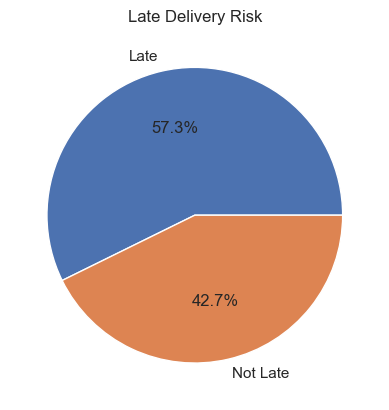

In [132]:
# More than half deliveries are late
merged_data['late_delivery_risk'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Late Delivery Risk')
plt.ylabel("")
plt.show()

In [133]:
# Products with most Late dealivery risk
product_availability_analysis = (merged_data.groupby('product_name').agg(delayed_orders=('late_delivery_risk', lambda x: (x == 'Late').sum())).sort_values(by=['delayed_orders'],ascending=False)).head(10).reset_index()
product_availability_analysis

product_name  delayed_orders
0               Perfect Fitness Perfect Rip Deck           14053
1        Nike Men's CJ Elite 2 TD Football Cleat           12664
2           Nike Men's Dri-FIT Victory Golf Polo           12017
3               O'Brien Men's Neoprene Life Vest           11043
4      Field & Stream Sportsman 16 Gun Fire Safe            9930
5                    Pelican Sunstream 100 Kayak            8866
6  Diamondback Women's Serene Classic Comfort Bi            7812
7              Nike Men's Free 5.0+ Running Shoe            6925
8  Under Armour Girls' Toddler Spine Surge Runni            6126
9                           Fighting video games             472

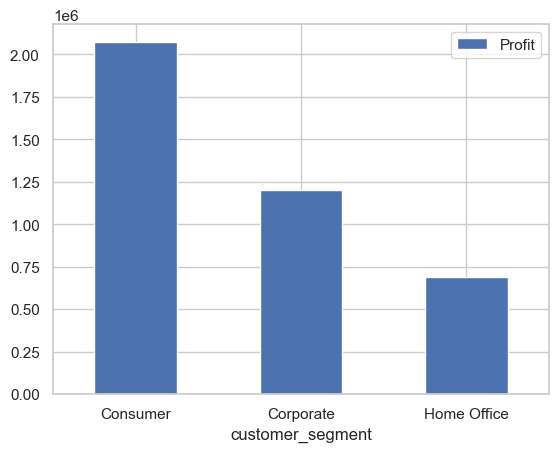

In [134]:
# Consumer Segment gives the most Profit
merged_data.groupby(by=['customer_segment']).agg(Profit=('order_profit_per_order',sum)).plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

In [135]:
# Department-wise Sales and Profitability Analysis:

department_wise = merged_data.groupby("department_name").agg(tot_sales = ("sales_per_customer","sum"),
tot_profit = ("order_profit_per_order","sum"),avg_sales = ("sales_per_customer","mean"),
avg_profit = ("order_profit_per_order","mean")).round(2).reset_index()
department_wise

department_name    tot_sales  tot_profit  avg_sales  avg_profit
0             Apparel   7167654.21   881882.93     146.28       18.00
1           Book Shop     11303.42      883.01      27.91        2.18
2          Discs Shop    205675.90    24193.12     101.52       11.94
3            Fan Shop  15378581.71  1834155.44     230.01       27.43
4             Fitness    357158.26    46538.06     144.07       18.77
5            Footwear   3599468.83   410222.50     247.81       28.24
6                Golf   4142100.96   497523.56     124.69       14.98
7   Health and Beauty     95358.11     9493.63     263.42       26.23
8            Outdoors   1125953.44   145251.46     116.25       15.00
9            Pet Shop     37318.30     3589.26      75.85        7.30
10         Technology    933829.24   113170.01     637.43       77.25

In [136]:
# Customer Segmentation by Geography:

customer_region = merged_data.groupby(["order_region","customer_segment"])["sales_per_customer"].mean().round(2).unstack()
customer_region

customer_segment  Consumer  Corporate  Home Office
order_region                                      
Canada              179.51     164.70       181.52
Caribbean           176.02     180.15       180.40
Central Africa      175.21     174.76       173.00
Central America     179.29     180.18       180.30
Central Asia        178.50     178.16       166.68
East Africa         182.85     182.33       181.97
East of USA         178.31     177.51       178.80
Eastern Asia        184.04     183.13       181.18
Eastern Europe      178.80     177.75       173.83
North Africa        176.67     178.00       176.52
Northern Europe     198.48     199.15       194.98
Oceania             180.16     176.16       176.87
South America       179.24     177.94       175.36
South Asia          181.39     181.39       178.00
South of  USA       175.88     174.86       170.96
Southeast Asia      183.32     185.62       174.27
Southern Africa     178.07     177.04       171.77
Southern Europe     196.82     191.99       193.92
US Center           177.08     169.93       181.05
West Africa         176.57     179.14       174.54
West Asia           175.42     175.01       177.96
West of USA         176.23     178.96       174.23
Western Europe      195.97     194.84       194.43

In [137]:
# Shipping mode preferences of Customer
merged_data['shipping_mode'].value_counts()

shipping_mode
Standard Class    107752
Second Class       35216
First Class        27814
Same Day            9737
Name: count, dtype: int64

In [138]:
# Analyze the frequency of orders over time
order_frequency_analysis = (merged_data.groupby(merged_data['order_date'].dt.to_period("M")).agg(unique_orders_count=('order_item_id', 'nunique')))
order_frequency_analysis

unique_orders_count
order_date                     
2015-01                    5322
2015-02                    4729
2015-03                    5362
2015-04                    5126
2015-05                    5357
2015-06                    5134
2015-07                    5299
2015-08                    5273
2015-09                    5140
2015-10                    5302
2015-11                    5235
2015-12                    5371
2016-01                    5317
2016-02                    4894
2016-03                    5210
2016-04                    5097
2016-05                    5302
2016-06                    5054
2016-07                    5305
2016-08                    5334
2016-09                    5160
2016-10                    5398
2016-11                    5210
2016-12                    5269
2017-01                    5217
2017-02                    4906
2017-03                    5347
2017-04                    5212
2017-05                    5317
2017-06                    4951
2017-07                    5318
2017-08                    5305
2017-09                    5189
2017-10                    2255
2017-11                    2055
2017-12                    2124
2018-01                    2123

In [139]:
unique_orders_count=('order_item_id', 'nunique')

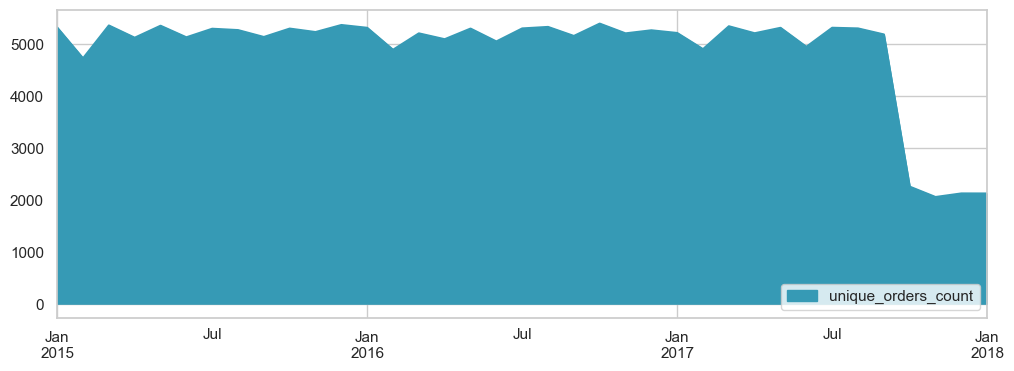

In [140]:
order_frequency_analysis.plot(kind='area',figsize=(12,4), color='#369ab5',label=unique_orders_count)
plt.xlabel('')
plt.legend(loc='lower right')
plt.show()

In [141]:
# Order status of customers by Shipping mode
# Standar class have complete more than First Class orders.
pd.crosstab(merged_data['shipping_mode'],merged_data['order_status'])

order_status    Canceled  Closed  Complete  On Hold  Payment Review  Pending  \
shipping_mode                                                                  
First Class          615    3017      9307     1455             315     3140   
Same Day             225    1124      3164      522              94     1125   
Second Class         661    3804     11655     1815             386     3886   
Standard Class      2191   11671     35365     6012            1098    12076   

order_status    Pending Payment  Processing  Suspected Fraud  
shipping_mode                                                 
First Class                5907        3372              686  
Same Day                   2095        1169              219  
Second Class               8017        4243              749  
Standard Class            23813       13118             2408

In [142]:
# Repeat customers
customer_purchases = merged_data.groupby('customer_id')['order_id'].nunique()
repeated_customers_count = sum(customer_purchases > 1)
total_customers = len(customer_purchases)
repeated_customers_percentage = round((repeated_customers_count / total_customers) * 100,2)
print("Percentage of repeated customers " ,repeated_customers_percentage,"%")

Percentage of repeated customers  56.98 %


# d. Create visualizations of the analysis (as per Sample reports provided - you need to create only charts and dashboard is optional)

In [143]:
def large_number(number):
    if number >= 1e6:  
        return f'{number / 1e6:.0f}M'
    elif number >= 1e3:  
        return f'{number / 1e3:.0f}k'
    else:
        return str(number)

In [144]:
total_inventory_units=InvStock['current_stock'].sum()

In [145]:
total_inventory_units=large_number(total_inventory_units)

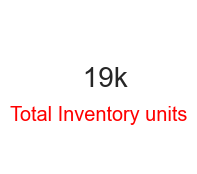

In [146]:
plt.figure(figsize=(2, 2))
plt.text(0.5, 0.5, f' {total_inventory_units}', ha='center', fontsize=20)
plt.axis('off') 
plt.suptitle('Total Inventory units', color='red', y=0.4,x=0.5)
plt.show()

In [147]:
merged_data['inve_value']=merged_data['order_item_product_price']*merged_data['current_stock']

In [148]:
total_inventory_value=round(merged_data['inve_value'].sum(),2)

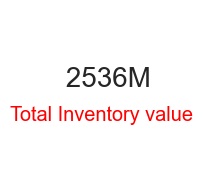

In [149]:
total_inventory_value=large_number(total_inventory_value)
plt.figure(figsize=(2, 2))
plt.text(0.5, 0.5, f' {total_inventory_value}', ha='center', fontsize=20)
plt.axis('off') 
plt.suptitle('Total Inventory value', color='red', y=0.4,x=0.5)
plt.show()

In [150]:
sales_unit=merged_data['order_item_quantity'].sum()
sales_unit=large_number(sales_unit)

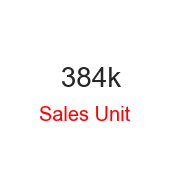

In [151]:
plt.figure(figsize=(2, 2))
plt.text(0.5, 0.5, f' {sales_unit}', ha='center', fontsize=20)
plt.axis('off') 
plt.suptitle('Sales Unit', color='red', y=0.4,x=0.5)
plt.show()

In [152]:
sales_value = merged_data['sales'].sum()
sales_value = large_number(sales_value)

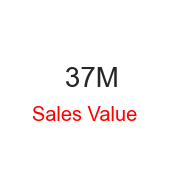

In [153]:
plt.figure(figsize=(2, 2))
plt.text(0.5, 0.5, f' {sales_value}', ha='center', fontsize=20)
plt.axis('off') 
plt.suptitle('Sales Value', color='red', y=0.4,x=0.5)
plt.show()

In [154]:
profit_value=round(merged_data['sales'].sum(),2)
profit_value=large_number(profit_value)

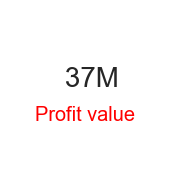

In [155]:
plt.figure(figsize=(2, 2))
plt.text(0.5, 0.5, f' {profit_value}', ha='center', fontsize=20)
plt.axis('off') 
plt.suptitle('Profit value', color='red', y=0.4,x=0.5)
plt.show()

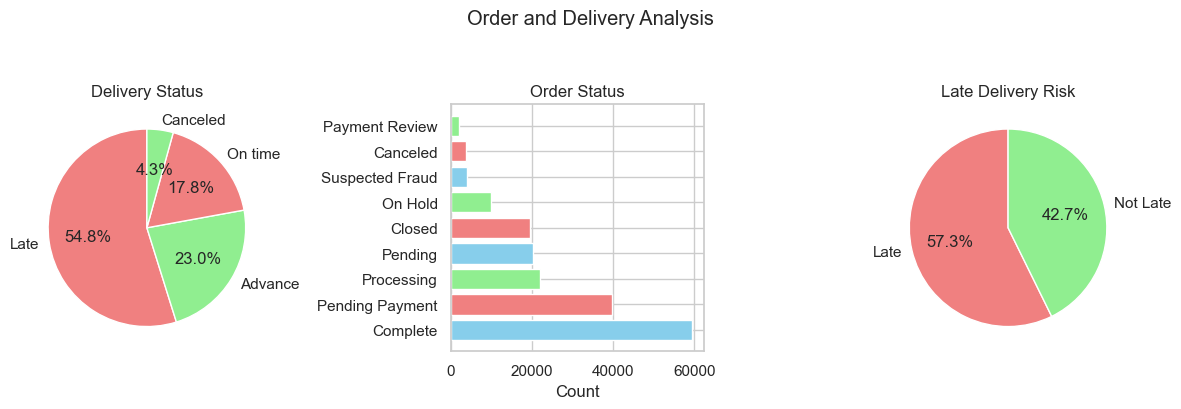

In [156]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
fig.suptitle('Order and Delivery Analysis', y=1.02)

# Delivery Status
delivery_status_counts = merged_data['delivery_status'].value_counts()
axes[0].pie(delivery_status_counts, labels=delivery_status_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
axes[0].set_title('Delivery Status')

# Order Status
order_status_counts = merged_data['order_status'].value_counts()
axes[1].barh(order_status_counts.index, order_status_counts, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1].set_title('Order Status')
axes[1].set_xlabel('Count')

# Late Delivery Risk
late_delivery_risk_counts = merged_data['late_delivery_risk'].value_counts()
axes[2].pie(late_delivery_risk_counts, labels=late_delivery_risk_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
axes[2].set_title('Late Delivery Risk')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

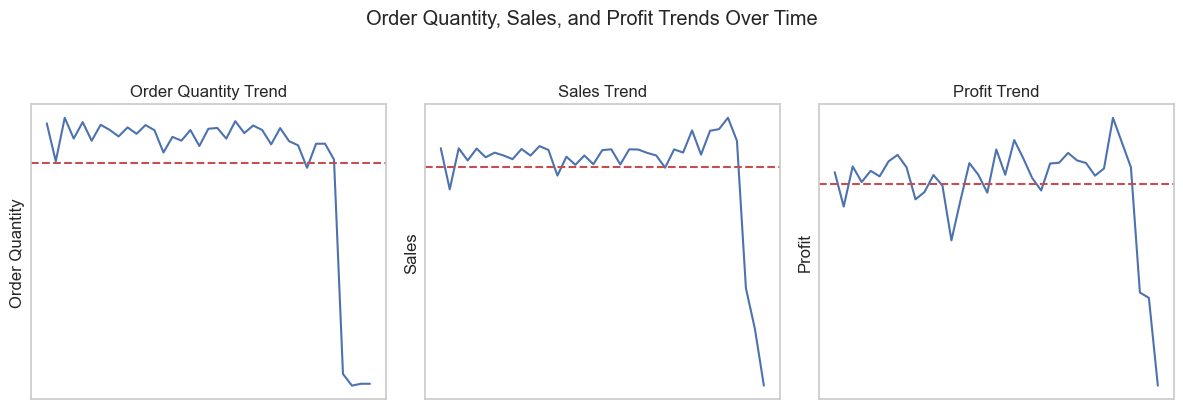

In [157]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
fig.suptitle('Order Quantity, Sales, and Profit Trends Over Time', y=1.02)

# Order Quantity Trend
OOT = merged_data.groupby(merged_data['order_date'].dt.strftime("%Y-%m"))['order_item_quantity'].sum().reset_index()
sns.lineplot(x='order_date', y='order_item_quantity', data=OOT, ax=axes[0])
axes[0].axhline(y=OOT['order_item_quantity'].mean(), color='r', linestyle='--', label='Average Orders')
axes[0].set_title('Order Quantity Trend')
axes[0].set_ylabel('Order Quantity')
axes[0].set_xlabel("") 
axes[0].set_xticks([]) 
axes[0].set_yticks([])

# Sales Trend
ST = merged_data.groupby(merged_data['order_date'].dt.strftime("%Y-%m"))['sales'].sum().reset_index()
sns.lineplot(x='order_date', y='sales', data=ST, ax=axes[1])
axes[1].axhline(y=ST['sales'].mean(), color='r', linestyle='--', label='Average Sales')
axes[1].set_title('Sales Trend')
axes[1].set_ylabel('Sales')
axes[1].set_xlabel("") 
axes[1].set_xticks([]) 
axes[1].set_yticks([])

# Profit Trend
PT = merged_data.groupby(merged_data['order_date'].dt.strftime("%Y-%m"))['benefit_per_order'].sum().reset_index()
sns.lineplot(x='order_date', y='benefit_per_order', data=PT, ax=axes[2])
axes[2].axhline(y=PT['benefit_per_order'].mean(), color='r', linestyle='--', label='Average Profit')
axes[2].set_title('Profit Trend')
axes[2].set_ylabel('Profit')
axes[2].set_xlabel("") 
axes[2].set_xticks([]) 
axes[2].set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

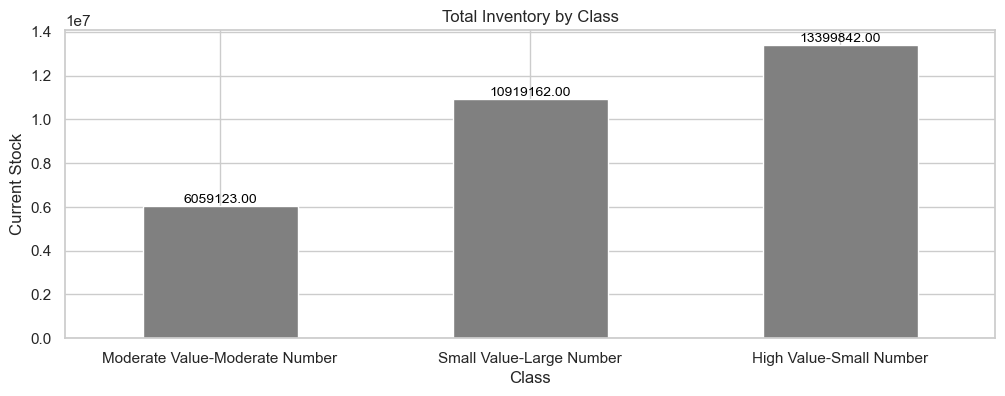

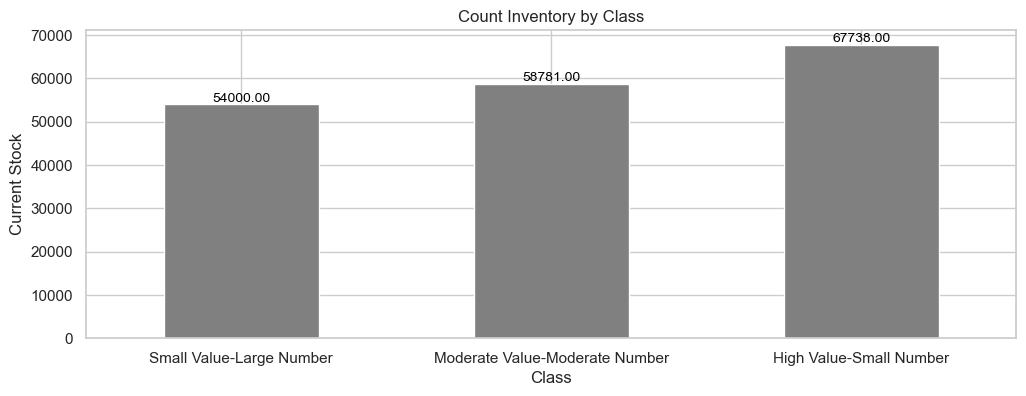

In [158]:
inventory_total = merged_data.groupby("class")['current_stock'].sum()
inventory_count = merged_data.groupby("class")['current_stock'].count()

plt.figure(figsize=(12,4))
ax = inventory_total.sort_values().plot(kind = 'bar',color = "gray")
ax.bar_label(ax.containers[0], fmt = '%.2f', label_type = 'edge', fontsize = 10, color = 'black')

plt.title('Total Inventory by Class')
plt.xlabel('Class')
plt.ylabel('Current Stock')
plt.xticks(rotation = 0, ha = 'center')
plt.show()

plt.figure(figsize = (12, 4))
ax = inventory_count.sort_values().plot(kind = 'bar',color = "gray")
ax.bar_label(ax.containers[0], fmt = '%.2f', label_type = 'edge', fontsize = 10, color = 'black')

plt.title('Count Inventory by Class')
plt.xlabel('Class')
plt.ylabel('Current Stock')
plt.xticks(rotation = 0, ha = 'center')
plt.show()

## 3. Any other visualizaitons (at least 2) you can create beyond visualizaitons mentioned in the sample reports & metrics?

In [159]:
b=merged_data.groupby(by=['order_year']).agg(Order_quantity=('order_item_quantity',sum)).reset_index()

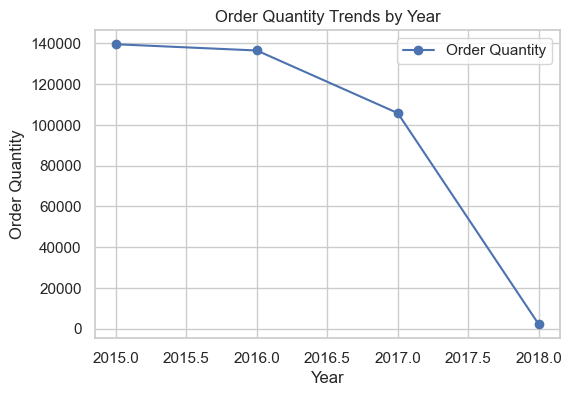

In [160]:
plt.figure(figsize=(6, 4))
plt.plot(b['order_year'],b['Order_quantity'], marker='o', linestyle='-', label='Order Quantity')
plt.xlabel('Year')
plt.ylabel('Order Quantity')
plt.title('Order Quantity Trends by Year')
plt.legend()
plt.show()

In [161]:
c=merged_data.groupby(by=['order_year']).agg(Sales=('sales',sum)).reset_index()

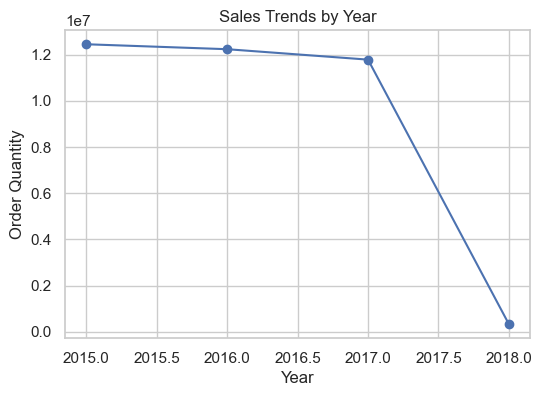

In [162]:
plt.figure(figsize=(6, 4))
plt.plot(c['order_year'],c['Sales'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Order Quantity')
plt.title('Sales Trends by Year')
plt.show()

In [163]:
d=merged_data.groupby(by=['order_year']).agg(Profit=('order_profit_per_order',sum)).reset_index()

In [164]:
d

order_year        Profit
0        2015  1.330701e+06
1        2016  1.300851e+06
2        2017  1.301509e+06
3        2018  3.384189e+04

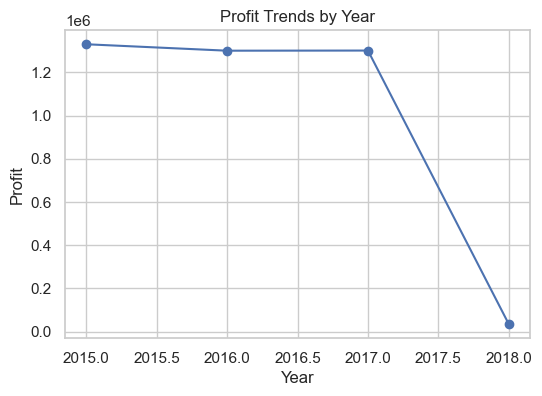

In [165]:
plt.figure(figsize=(6, 4))
plt.plot(d['order_year'],d['Profit'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Profit')
plt.title('Profit Trends by Year')
plt.show()

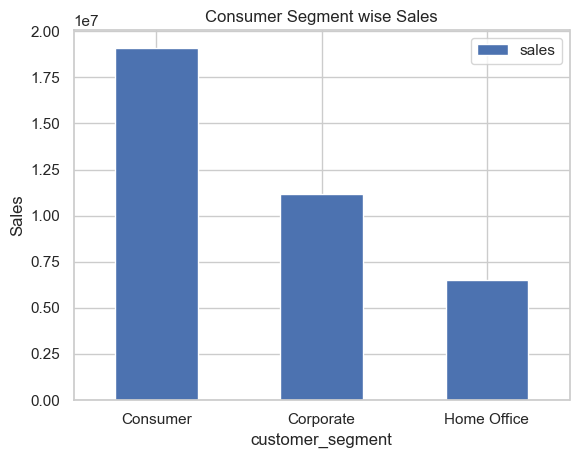

In [166]:
merged_data.groupby(by=['customer_segment']).agg(sales=('sales',sum)).plot(kind='bar')
plt.xticks(rotation=0)
plt.title("Consumer Segment wise Sales")
plt.ylabel("Sales")
plt.show()

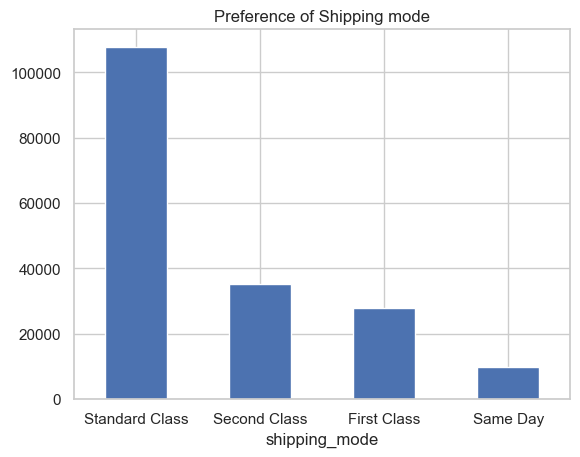

In [167]:
merged_data['shipping_mode'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.title("Preference of Shipping mode")
plt.show()

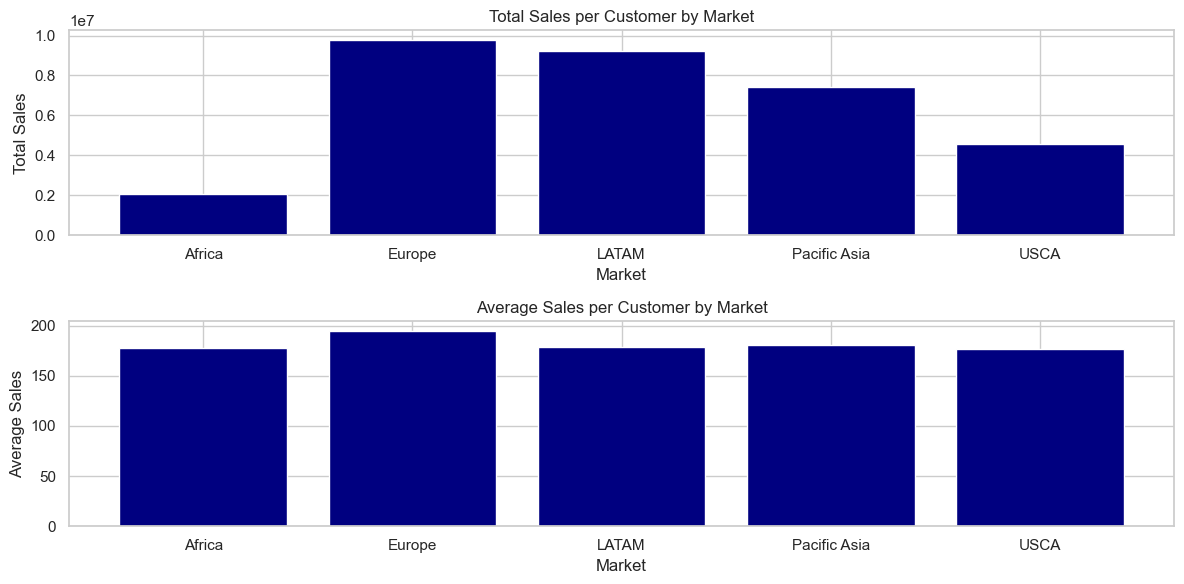

In [168]:
market_wise = merged_data.groupby("market").agg(total_sales = ("sales_per_customer","sum"),avg_sales = ("sales_per_customer","mean")).round(2).reset_index()
market_wise

plt.figure(figsize = (12, 6))

plt.subplot(2, 1, 1)
plt.bar(market_wise['market'], market_wise['total_sales'], color = 'navy')
plt.xlabel('Market')
plt.ylabel('Total Sales')
plt.title('Total Sales per Customer by Market')

plt.subplot(2, 1, 2)
plt.bar(market_wise['market'], market_wise['avg_sales'], color = 'navy')
plt.xlabel('Market')
plt.ylabel('Average Sales')
plt.title('Average Sales per Customer by Market')

plt.tight_layout()
plt.show()

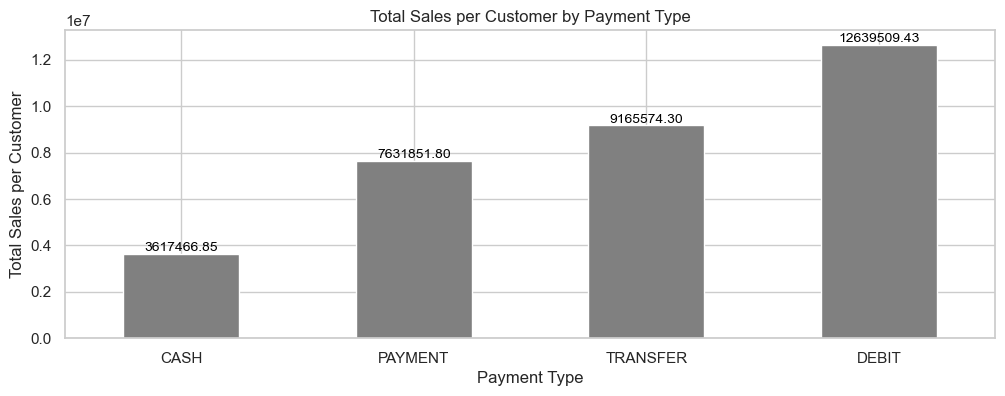

In [169]:
payment_type = merged_data.groupby("type")["sales_per_customer"].sum().round(2)

plt.figure(figsize = (12, 4))

ax = payment_type.sort_values().plot(kind = 'bar',color = "gray")
ax.bar_label(ax.containers[0], fmt = '%.2f', label_type = 'edge', fontsize = 10, color = 'black')
plt.xlabel('Payment Type')
plt.ylabel('Total Sales per Customer')
plt.title('Total Sales per Customer by Payment Type')
plt.xticks(rotation = 0, ha = 'center')

plt.show()

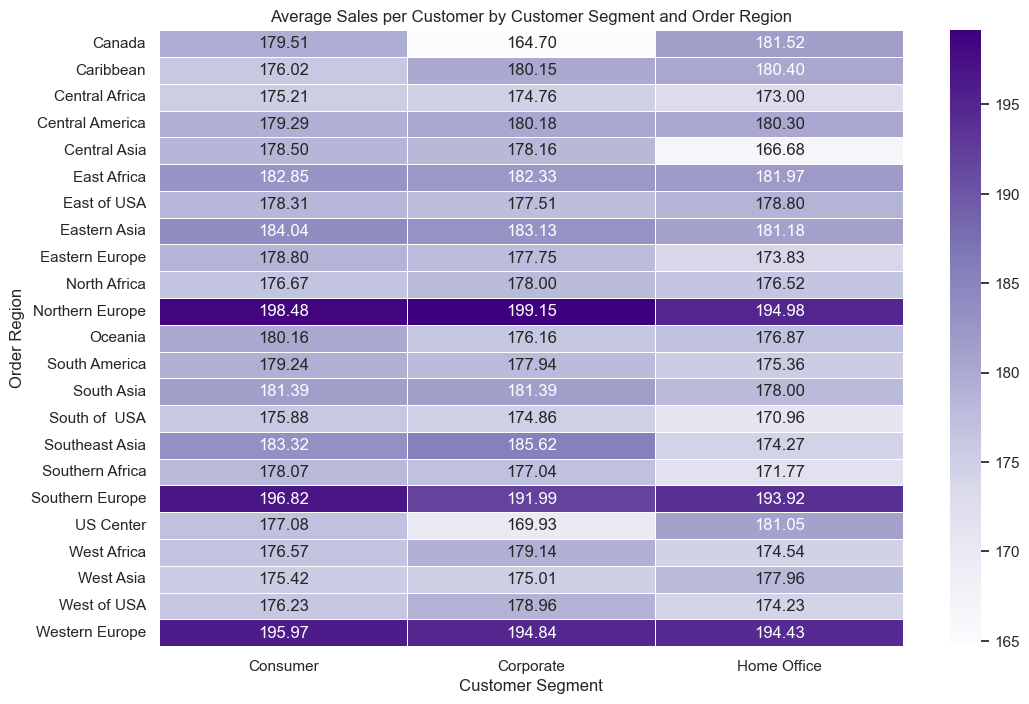

In [170]:
customer_segment_by_region = merged_data.groupby(["order_region","customer_segment"])["sales_per_customer"].mean().round(2).unstack()
customer_segment_by_region

plt.figure(figsize = (12, 8))

sns.heatmap(customer_segment_by_region, annot = True, cmap = "Purples", fmt = ".2f", linewidths = .5)

plt.xlabel('Customer Segment')
plt.ylabel('Order Region')
plt.title('Average Sales per Customer by Customer Segment and Order Region')

plt.show()

# Predictive modeling & perform the tasks as per your understanding

## 1. Build predictive model to predict the sales (Hint: You are required to aggregate the data at customer level. It means that one record for one customer

## 2. Prepare end to end code with proper comments

In [171]:
merged_data.columns

Index(['order-now', 'product_id', 'product_name', 'avg_lead_time',
       'avg_order_qty', 'current_stock', 'max_lead_time', 'max_order_qty',
       'mod', 'reorder_point', 'safety_stock', 'product_category_id',
       'category_name', 'class', 'customer_city', 'customer_country',
       'customer_fname', 'customer_id', 'customer_lname', 'customer_segment',
       'customer_state', 'customer_street', 'customer_zipcode',
       'delivery_status', 'department_id', 'department_name', 'market',
       'order_city', 'order_country', 'order_id', 'order_region',
       'order_state', 'order_status', 'shipping_mode', 'type',
       'benefit_per_order', 'days_for_shipment_scheduled',
       'days_for_shipping_real', 'latitude', 'longitude', 'order_customer_id',
       'order_item_cardprod_id', 'order_item_discount',
       'order_item_discount_rate', 'order_item_id', 'order_item_product_price',
       'order_item_profit_ratio', 'order_item_quantity', 'order_item_total',
       'order_profit_per

In [172]:
# Aggregation at Customer Level
customer_data = merged_data.groupby('customer_id').agg({
    'sales': 'sum',
        'avg_order_qty': 'mean',
        'order_item_discount_rate': 'mean',
        'order_item_profit_ratio': 'sum',
        'order_item_total': 'sum',
        'order_id': 'count',  # Number of orders
        'product_id': 'nunique',  # Number of unique products
        'avg_lead_time': 'mean',
        'max_lead_time': 'max',
        'current_stock': 'mean',
        'reorder_point': 'mean',
        'safety_stock': 'mean',
})

In [173]:
customer_data.head(5)

sales  avg_order_qty  order_item_discount_rate  \
customer_id                                                         
1             499.950012       3.000000                     0.060   
2            1819.730034       2.200000                     0.126   
3            3537.680094       2.111111                     0.105   
4            1719.630030       3.000000                     0.135   
5            1274.750023       2.142857                     0.140   

             order_item_profit_ratio  order_item_total  order_id  product_id  \
customer_id                                                                    
1                               0.34        472.450012         1           1   
2                               0.73       1618.660042        10           7   
3                               1.55       3189.200037        18           9   
4                              -1.68       1480.709993        14           6   
5                               2.11       1101.919998         7           5   

             avg_lead_time  max_lead_time  current_stock  reorder_point  \
customer_id                                                               
1                     10.0             30     321.000000     175.000000   
2                     10.0             30     158.100000     119.000000   
3                     10.0             30     165.833333     112.777778   
4                     10.0             30     293.142857     175.000000   
5                     10.0             30     170.714286     115.000000   

             safety_stock  
customer_id                
1              145.000000  
2               97.500000  
3               91.888889  
4              145.357143  
5               94.142857

In [174]:
linear_reg_data = customer_data.copy()

In [175]:
linear_reg_data.head(5)

sales  avg_order_qty  order_item_discount_rate  \
customer_id                                                         
1             499.950012       3.000000                     0.060   
2            1819.730034       2.200000                     0.126   
3            3537.680094       2.111111                     0.105   
4            1719.630030       3.000000                     0.135   
5            1274.750023       2.142857                     0.140   

             order_item_profit_ratio  order_item_total  order_id  product_id  \
customer_id                                                                    
1                               0.34        472.450012         1           1   
2                               0.73       1618.660042        10           7   
3                               1.55       3189.200037        18           9   
4                              -1.68       1480.709993        14           6   
5                               2.11       1101.919998         7           5   

             avg_lead_time  max_lead_time  current_stock  reorder_point  \
customer_id                                                               
1                     10.0             30     321.000000     175.000000   
2                     10.0             30     158.100000     119.000000   
3                     10.0             30     165.833333     112.777778   
4                     10.0             30     293.142857     175.000000   
5                     10.0             30     170.714286     115.000000   

             safety_stock  
customer_id                
1              145.000000  
2               97.500000  
3               91.888889  
4              145.357143  
5               94.142857

In [176]:
linear_reg_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20652 entries, 1 to 20757
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sales                     20652 non-null  float64
 1   avg_order_qty             20652 non-null  float64
 2   order_item_discount_rate  20652 non-null  float64
 3   order_item_profit_ratio   20652 non-null  float64
 4   order_item_total          20652 non-null  float64
 5   order_id                  20652 non-null  int64  
 6   product_id                20652 non-null  int64  
 7   avg_lead_time             20652 non-null  float64
 8   max_lead_time             20652 non-null  int64  
 9   current_stock             20652 non-null  float64
 10  reorder_point             20652 non-null  float64
 11  safety_stock              20652 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 2.0 MB


In [177]:
linear_reg_data.nunique()

sales                       12091
avg_order_qty                 251
order_item_discount_rate    10577
order_item_profit_ratio     11391
order_item_total            12631
order_id                       46
product_id                     17
avg_lead_time                   1
max_lead_time                   1
current_stock                7182
reorder_point                 251
safety_stock                 1669
dtype: int64

In [178]:
def custom_description( x ):
    
    non_missing = x.isnull().count()
    missing = x.isnull().sum()
    missing_pct = missing / non_missing
    
    p25 = x.quantile(0.25)
    p75 = x.quantile(0.75)
    
    iqr = p75 - p25
    
    lc_iqr = p25 - 1.5 * iqr
    uc_iqr = p75 + 1.5 * iqr
    
    return pd.Series( [ x.dtype, x.count(), x.nunique(), non_missing, missing, missing_pct, 
                       x.sum(), x.var(), x.std(), x.mean(), 
                       iqr, lc_iqr, uc_iqr, 
                       x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                       x.quantile(0.25), x.quantile(0.50), x.quantile(0.75), 
                       x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max()],
                     
                    index = ['dtype', 'rows','unique values', 'non_missing', 'missing', 'missing_pct',
                             'sum', 'var', 'std', 'mean',
                             'Interquartile Range', 'IQR lower bound', 'IQR upper bound',
                             'min', '1%', '5%', '10%', 
                             '25%', '50%', '75%', 
                             '90%', '95%', '99%', 'max'])

In [179]:
linear_reg_data.apply(custom_description)

sales avg_order_qty order_item_discount_rate  \
dtype                       float64       float64                  float64   
rows                          20652         20652                    20652   
unique values                 12091           251                    10577   
non_missing                   20652         20652                    20652   
missing                           0             0                        0   
missing_pct                     0.0           0.0                      0.0   
sum                  36784735.01338  35204.001999              2100.454682   
var                   2813429.49192      0.398133                 0.002329   
std                     1677.328081      0.630978                 0.048256   
mean                    1781.170589      1.704629                 0.101707   
Interquartile Range     2622.840057          1.25                  0.04675   
IQR lower bound        -3641.220077        -0.875                 0.006125   
IQR upper bound         6850.140151         4.125                 0.193125   
min                           11.29           1.0                      0.0   
1%                            11.29           1.0                      0.0   
5%                            31.08           1.0                     0.02   
10%                       59.080002           1.0                     0.04   
25%                      293.040008           1.0                  0.07625   
50%                     1499.825033      1.909091                      0.1   
75%                     2915.880065          2.25                    0.123   
90%                     4181.324104      2.454545                     0.16   
95%                     4939.512613           2.6                     0.18   
99%                     6471.194434           3.0                     0.25   
max                    10524.170178           3.0                     0.25   

                    order_item_profit_ratio order_item_total   order_id  \
dtype                               float64          float64      int64   
rows                                  20652            20652      20652   
unique values                         11391            12631         46   
non_missing                           20652            20652      20652   
missing                                   0                0          0   
missing_pct                             0.0              0.0        0.0   
sum                            21779.009992  33054402.380217     180519   
var                                3.750604    2275324.72893  70.155614   
std                                1.936648      1508.417956   8.375895   
mean                               1.054571      1600.542436   8.740994   
Interquartile Range                  1.9825      2366.200005       14.0   
IQR lower bound                    -2.87375     -3294.360004      -20.0   
IQR upper bound                     5.05625      6170.440014       36.0   
min                                   -9.59             8.47          1   
1%                                  -3.7249             9.69        1.0   
5%                                  -1.6145             28.9        1.0   
10%                                   -0.73        47.259998        1.0   
25%                                     0.1       254.940002        1.0   
50%                                    0.46      1294.504997        7.0   
75%                                  2.0825      2621.140007       15.0   
90%                                    3.74      3754.810058       21.0   
95%                                     4.7      4448.156548       24.0   
99%                                  6.4549      5818.855271       31.0   
max                                   11.39      9436.610088         47   

                    product_id avg_lead_time max_lead_time   current_stock  \
dtype                    int64       float64         int64         float64   
rows                     20652         20652   

In [180]:
linear_reg_data = linear_reg_data.apply(lambda x: x.clip( lower = x.quantile(0.01), upper = x.quantile(0.99) ))

In [181]:
linear_reg_data.isna().sum()

sales                       0
avg_order_qty               0
order_item_discount_rate    0
order_item_profit_ratio     0
order_item_total            0
order_id                    0
product_id                  0
avg_lead_time               0
max_lead_time               0
current_stock               0
reorder_point               0
safety_stock                0
dtype: int64

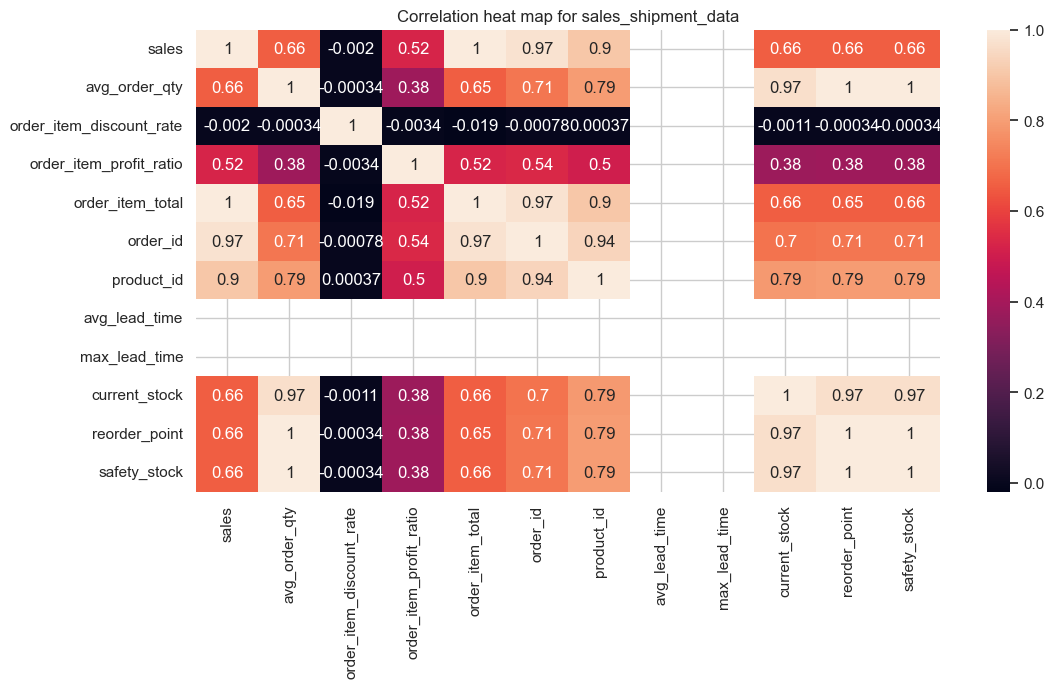

In [182]:
plt.figure(figsize=(12,6))
htmp = sns.heatmap(linear_reg_data.corr(),annot=True)
htmp.set_title('Correlation heat map for sales_shipment_data')
plt.show()

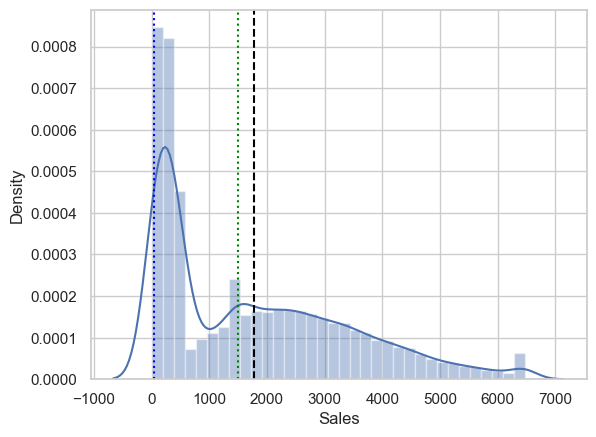

In [183]:
sns.distplot(linear_reg_data.sales)

# Calculate the mean, median, and mode
mean = linear_reg_data.sales.mean()
median = linear_reg_data.sales.median()
mode = linear_reg_data.sales.mode()[0]

# Annotate the plot with the mean, median, and mode
plt.axvline(mean, color='black', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle=':', label=f'Median: {median:.2f}')
plt.axvline(mode, color='blue', linestyle=':', label=f'Mode: {mode:.2f}')

# Add labels and title
plt.xlabel('Sales')

# Show the plot
plt.show()

In [184]:
linear_reg_data.sales.kurtosis()

-0.23962864664915218

### Bring it to Normality

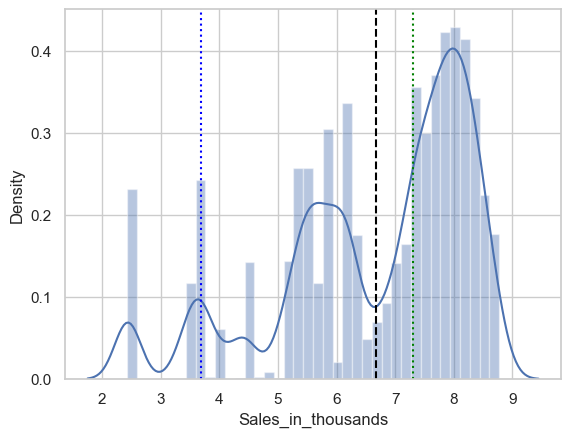

In [185]:
# Log Transformation
sns.distplot(np.log(linear_reg_data.sales))

mean = np.log(linear_reg_data.sales).mean()
median = np.log(linear_reg_data.sales).median()
mode = np.log(linear_reg_data.sales).mode()[0]

plt.axvline(mean, color='black', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle=':', label=f'Median: {median:.2f}')
plt.axvline(mode, color='blue', linestyle=':', label=f'Mode: {mode:.2f}')

plt.xlabel('Sales_in_thousands')

plt.show()

In [186]:
np.log(linear_reg_data.sales).kurtosis()

0.03755692849576997

In [187]:
linear_reg_data['log_sales']=np.log(linear_reg_data.sales)

### Train Test

In [188]:
train, test = train_test_split(linear_reg_data, test_size = 0.2, random_state = 1)

In [189]:
print('cars data:',linear_reg_data.shape)
print("---")
print('train data:',train.shape,'| ','test data',test.shape)

cars data: (20652, 13)
---
train data: (16521, 13) |  test data (4131, 13)


In [190]:
# Model Building
X_vars = linear_reg_data.columns.difference(['Sales','log_sales'])
y_var = 'log_sales'

In [191]:
formula_lm = 'log_sales ~ ' + ' + '.join( X_vars )

In [192]:
formula_lm

'log_sales ~ avg_lead_time + avg_order_qty + current_stock + max_lead_time + order_id + order_item_discount_rate + order_item_profit_ratio + order_item_total + product_id + reorder_point + safety_stock + sales'

### Model Initiation

In [193]:
model = smf.ols(formula_lm, train).fit()

In [194]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     7243.
Date:                Tue, 17 Dec 2024   Prob (F-statistic):               0.00
Time:                        03:24:57   Log-Likelihood:                -18366.
No. Observations:               16521   AIC:                         3.675e+04
Df Residuals:                   16511   BIC:                         3.683e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### Prediction

In [195]:
np.exp(model.predict(train)) 

customer_id
1794      1312.620108
11663     2123.351876
6425      4370.940982
8848      1962.820108
2611      1506.217236
             ...     
11047      992.138119
17395      168.059886
5238      5462.658939
12274     3679.840614
238      15381.259602
Length: 16521, dtype: float64

In [196]:
train.sales

customer_id
1794     2034.810020
11663    2089.670055
6425     4259.530083
8848     2579.710060
2611     2344.730047
            ...     
11047    1669.690014
17395     215.820007
5238     4429.550076
12274    2517.620052
238      5756.340094
Name: sales, Length: 16521, dtype: float64

In [197]:
mse_train = mean_squared_error ( train.sales, np.exp(model.predict(train)) ) 
mse_test = mean_squared_error( test.sales, np.exp(model.predict (test)) ) 
print ( 'MSE Train : ', mse_train,'| MSE Test : ', mse_test) 
print ( ' RMSE Train : ', np.sqrt(mse_train),'| RMSE Test : ', np.sqrt(mse_test))

MSE Train :  5246935.617142293 | MSE Test :  4900564.338343694
 RMSE Train :  2290.61904670818 | RMSE Test :  2213.7218294861923


## results of a linear regression model:

* R-squared of 0.79 suggests 79% variance in log-transformed sales is explained by the model, indicating effective feature selection.
* RMSE values around 2290.61 (training) and 2213.72 (test) imply model's average prediction error. Lower RMSE indicates better performance.

## To PKL file

In [198]:
linear_reg_data['Predicated_Sales'] = pd.concat([np.exp(model.predict(train)),np.exp(model.predict(test))]).sort_index()

In [199]:
linear_reg_data.to_pickle("D:\GitHub\Python\Supply Chain and Inventory Management\model-output-sourabhasekharrout.pkl")